# ** Описание **

In [1]:
from __future__ import division

import base64
import csv
import gzip

import zlib


from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from gensim.models import FastText
from sklearn.decomposition import TruncatedSVD
import numpy as np
from bs4 import BeautifulSoup

In [3]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [4]:
# def to_utf8(text):
#     if isinstance(text, unicode): text = text.encode('utf8')
#     return text

# def convert2unicode(f):
#     def tmp(text):
#         if not isinstance(text, unicode): text = text.decode('utf8')
#         return f(text)
#     return tmp

# def convert2lower(f):
#     def tmp(text):        
#         return f(text.lower())
#     return tmp

# #P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [5]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [12]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [13]:
html2text = html2text_bs
#html2text = html2text_parser

#### Методы для токенизации текста

In [14]:
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        return PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [15]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [16]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [17]:
from bs4 import BeautifulSoup
from collections import Counter

In [18]:
def calc_features(url, html_data):
    soup = BeautifulSoup(html_data, "html.parser") 
    try:
        title = soup.title.string
    except:
        title = ""
    visible_texts = html2text_bs_visible(html_data)
        # Кол-во ссылок на разные страницы
    links = []
    anchors = []
    for link in soup.find_all('a', attrs={'href': re.compile("^http://")}):
        if (link.get('href') == link.get_text()): # Безанкорная ссылка
            continue
        links.append(link.get('href'))
        anchors.append(link.get_text())
    desc_cnt = 0
    a_cnt = 0
    div_cnt = 0

    
    desc_cnt = len(soup.find_all('a', {"class": "description"}) + soup.find_all('div', {"class": "description"}) + soup.find_all('title', {"class": "description"}))
     
    a_cnt = len(soup.find_all('a'))
     
    div_cnt = len(soup.find_all('div'))

    
    script_cnt = len(soup.find_all('script'))
    
    #ищем картинки
    img = soup.find_all('img')
    if img is not None:
        img_cnt = len(img)
    else:
        img_cnt = 0
    
    links_cnt = len(links) 
    anchors_string = ' '.join(anchors)
    anchor_words_num = len(anchors_string.split())
    if anchor_words_num != 0:
        anchor_avg_word_len = sum([len(word) for word in anchors_string.split()]) / anchor_words_num
    else:
        anchor_avg_word_len = 0
    words = list(html2word(html_data))
    words_num = len(words)
    if words_num != 0:
        avg_word_len = sum([len(word) for word in words]) / words_num
    else:
        avg_word_len = 0
    title_avg_word_len = 0
    title_words_num = 0
    if title is not None:
        title_words_num = len(title.split())
        if title_words_num != 0:
            title_avg_word_len = sum([len(word) for word in title.split()]) / title_words_num
        title = [pymorphy_tokenizer(word) for word in title.split() if pymorphy_tokenizer(word) is not None]
        title = ' '.join(title)
    else:
        title = ""
        
    compression_level = len(gzip.compress(bytes(html_data, 'utf-8'))) / len(html_data)
    '''
    # добавим просто счетчики
    visible_text = [pymorphy_tokenizer(word) for word in words]
    spam_vocab = ['скачать', 'секс', 'бесплатно', 'порно', 'быстро', 'заработать', 'доход', 'кредит', 'xxx', 'знакомство', 'деньги',
                 'дешевый', 'займ', 'доступное', 'ставки', 'крипта', 'коллектор', 'успех', 'продажа', 'скидки', 'распродажа', 'лекарство',
                 'срочно', 'гарантия', 'подарок', 'выигрыш', 'позвони', 'поздравляем']
    spam_cnt = 0
    for spam in spam_vocab:
        if spam in visible_text:
            spam_cnt += 1
            
            счетчики не очень работают, либо нужен больше словарь просто
    ''' 
    text = ' '.join(words)
    
    
    # работа с url
    dot_cnt = 0
    slash_cnt = 0
    
    for letter in url:
        if letter == '.':
            dot_cnt += 1
        elif letter == '/':
            slash_cnt += 1
        
    return [words_num, avg_word_len, title_words_num, anchor_words_num, compression_level, links_cnt, len(anchors), len(url), anchor_avg_word_len,
            title_avg_word_len, img_cnt, desc_cnt, a_cnt, div_cnt, len(set(words)), dot_cnt, slash_cnt, script_cnt, text, title]

In [20]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спамчик порно 1 2 3 xxx знакомствами заработать
</html>
'''
test_url = 'http://ololo.mail.ru/'
test_features = calc_features(test_url, test_html_data)
print(test_features)

[10, 5.4, 2, 0, 1.4536082474226804, 0, 0, 21, 0, 7.0, 0, 0, 0, 0, 10, 2, 3, 0, 'заголовок ololo спамчик порно 1 2 3 xxx знакомствами заработать', 'заголовок ololo']


In [21]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    global LAST_HTML
    with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [22]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv'
# TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))
# train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))
# ololo = load_csv(TRAIN_DATA_FILE, calc_features)

23:44:09 INFO:Complete items 00000 in worker_id 0
23:44:09 INFO:Complete items 00000 in worker_id 1
23:44:09 INFO:Complete items 00000 in worker_id 2
23:44:09 INFO:Complete items 00000 in worker_id 3
23:45:10 INFO:Complete items 01000 in worker_id 0
23:45:20 INFO:Complete items 01000 in worker_id 2
23:45:22 INFO:Complete items 01000 in worker_id 3
23:45:40 INFO:Complete items 01000 in worker_id 1
23:46:21 INFO:Complete items 02000 in worker_id 0
23:46:26 INFO:Complete items 02000 in worker_id 2
23:46:33 INFO:Complete items 02000 in worker_id 3
23:46:41 INFO:Complete items 02000 in worker_id 1
23:47:22 INFO:Complete items 03000 in worker_id 0
23:47:37 INFO:Complete items 03000 in worker_id 2
23:47:42 INFO:Complete items 03000 in worker_id 1
23:47:44 INFO:Complete items 03000 in worker_id 3
23:48:37 INFO:Complete items 04000 in worker_id 0
23:48:42 INFO:Complete items 04000 in worker_id 2
23:49:05 INFO:Complete items 04000 in worker_id 1
23:49:10 INFO:Complete items 04000 in worker_id 3


CPU times: user 1.18 s, sys: 373 ms, total: 1.56 s
Wall time: 8min 55s


In [553]:
len(train_docs)

7044

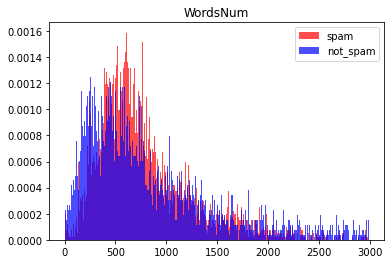

In [789]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('WordsNum')
plt.legend()
plt.show()

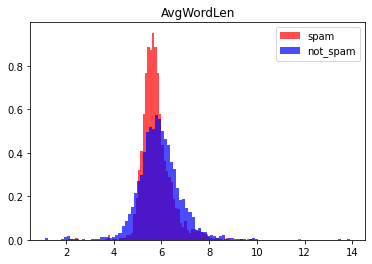

In [790]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

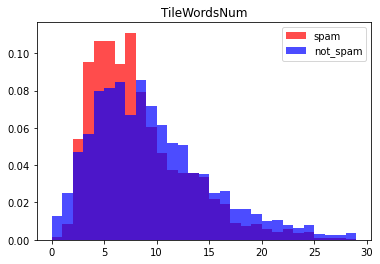

In [791]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('TileWordsNum')
plt.legend()
plt.show()

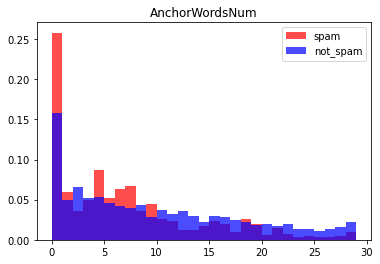

In [792]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AnchorWordsNum')
plt.legend()
plt.show()

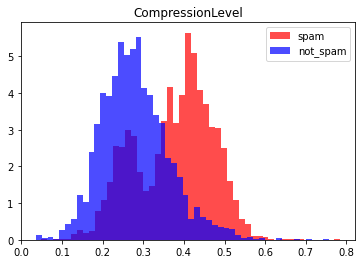

In [793]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = 50
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('CompressionLevel')
plt.legend()
plt.show()

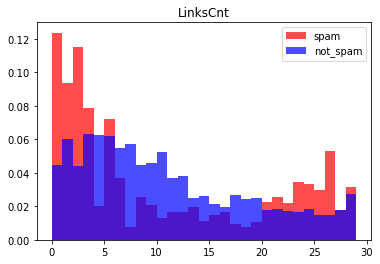

In [794]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('LinksCnt')
plt.legend()
plt.show()

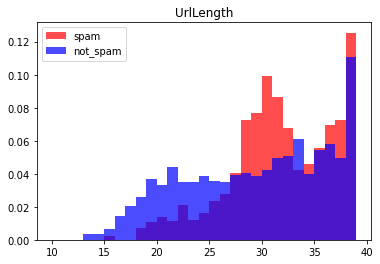

In [795]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = range(10, 40, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('UrlLength')
plt.legend()
plt.show()

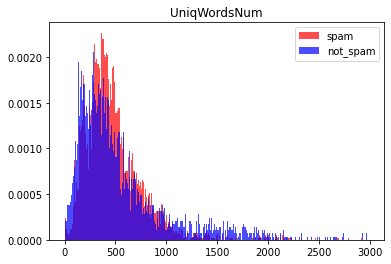

In [85]:
is_spam_data = [doc.features[-5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[-5] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('UniqWordsNum')
plt.legend()
plt.show()

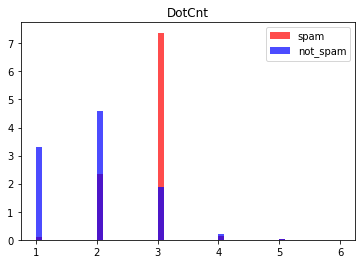

In [142]:
is_spam_data = [doc.features[-4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[-4] for doc in train_docs if doc[1] == False]
bins = 50
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('DotCnt')
plt.legend()
plt.show()

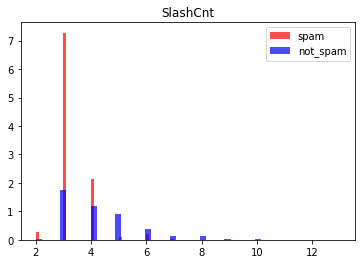

In [143]:
is_spam_data = [doc.features[-3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[-3] for doc in train_docs if doc[1] == False]
bins = 50
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('SlashCnt')
plt.legend()
plt.show()

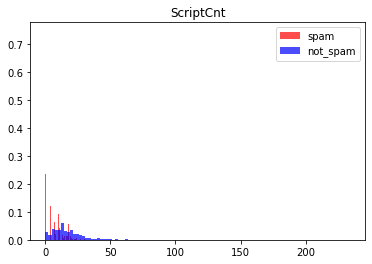

In [40]:
is_spam_data = [doc.features[-3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[-3] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('ScriptCnt')
plt.legend()
plt.show()

In [23]:
labels = [int(doc[1]) for doc in train_docs]

In [24]:
%%time

TEST_DATA_FILE  = 'kaggle_test_data_tab.csv'
# TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

test_docs = list(load_csv_multiprocess(TEST_DATA_FILE, calc_features))

23:53:05 INFO:Complete items 00000 in worker_id 0
23:53:05 INFO:Complete items 00000 in worker_id 1
23:53:05 INFO:Complete items 00000 in worker_id 2
23:53:05 INFO:Complete items 00000 in worker_id 3
23:54:16 INFO:Complete items 01000 in worker_id 2
23:54:25 INFO:Complete items 01000 in worker_id 1
23:54:51 INFO:Complete items 01000 in worker_id 3
23:55:37 INFO:Complete items 02000 in worker_id 2
23:55:37 INFO:Complete items 02000 in worker_id 1
23:57:08 INFO:Complete items 03000 in worker_id 2
23:57:09 INFO:Complete items 03000 in worker_id 1
23:58:17 INFO:Complete items 04000 in worker_id 2
23:58:23 INFO:Complete items 04000 in worker_id 1
23:58:32 INFO:Complete items 01000 in worker_id 0
23:59:19 INFO:Complete items 05000 in worker_id 2
23:59:51 INFO:Complete items 05000 in worker_id 1
23:59:58 INFO:Complete items 02000 in worker_id 0
00:00:19 INFO:Complete items 02000 in worker_id 3
00:00:28 INFO:Complete items 06000 in worker_id 2
00:01:41 INFO:Complete items 03000 in worker_id 0


CPU times: user 2.91 s, sys: 945 ms, total: 3.85 s
Wall time: 27min 57s


#### Для обработки текста

In [25]:
def _from_string_to_string(string):
    def _addspace(matchobj):
        def _define_class(obj, cl):
            for k,v in cl.items():
                if re.sub(v, '', obj) == '':
                    return k
        classes = {'ra': '[А-Яа-я]', 'ea': '[A-Za-z]', 'pu': '[^ \w]', 'di': '\d', 'sp': ' '}
        data_classes = []
        for a in matchobj.group(0):
            data_classes.append(_define_class(a,classes))
        res = ''
        for i,obj in enumerate(data_classes):
            res+=matchobj.group(0)[i]
            if i<len(data_classes)-1:
                if obj!=data_classes[i+1]:
                    res+=' '
        return res
    
    string = ' ' + string + ' '
    p_string = re.sub(' ', '  ', string)
    while re.search('.[^ \w].|\d\D.|.\D\d|[A-Za-z][А-Яа-я]|[А-Яа-я][A-Za-z]', string)!=None:
        string = re.sub(' ', '  ', string)
        string = re.sub('.[^ \w].|\d\D.|.\D\d|[A-Za-z][А-Яа-я]|[А-Яа-я][A-Za-z]',_addspace,string)
        string = re.sub(' +', ' ', string)
        if p_string == string:
            break
        p_string = string
    return re.sub(' +', ' ', string.strip())

## Повозимся с tf-idf

In [26]:
train_features = [doc.features[:-2] for doc in train_docs]

In [27]:
test_features = [doc.features[:-2] for doc in test_docs]

In [28]:
train_texts = [doc.features[-2] for doc in train_docs]

In [29]:
test_texts = [doc.features[-2] for doc in test_docs]

In [30]:
train_titles = [doc.features[-1] for doc in train_docs]

In [31]:
test_titles = [doc.features[-1] for doc in test_docs]

In [32]:
tf_idf_Vect = TfidfVectorizer(min_df=0.000142).fit(train_texts)

In [33]:
svd = TruncatedSVD(n_components=50)

In [34]:
train_tf_idf = tf_idf_Vect.transform(train_texts)

In [35]:
test_tf_idf = tf_idf_Vect.transform(test_texts)

In [36]:
train_svd = svd.fit_transform(train_tf_idf)

In [37]:
test_svd = svd.transform(test_tf_idf)

## Найдем ближайшие расстояния

Только портит scor, если брать тексты целиком

In [266]:
#from sklearn.metrics.pairwise import cosine_similarity

In [267]:
#cos_distances_train = cosine_similarity(train_tf_idf)
#sorted_dist = np.apply_along_axis(np.sort, axis=1, arr=cos_distances_train)[:, ::-1]
#train_dist = sorted_dist[:, 1: 5 + 1]

In [268]:
#cos_distances_test = cosine_similarity(test_tf_idf)
#sorted_dist = np.apply_along_axis(np.sort, axis=1, arr=cos_distances_test)[:, ::-1]
#test_dist = sorted_dist[:, 1: 5 + 1]

Возьмем расстояния между заголовками

In [269]:
#tf_idf_Vect_titles = TfidfVectorizer(stop_words='english').fit(train_titles)

In [270]:
#titles_tf_idf_train = tf_idf_Vect_titles.transform(train_titles)

In [271]:
#titles_tf_idf_test = tf_idf_Vect_titles.transform(test_titles)

In [272]:
#from sklearn.metrics import pairwise_distances

In [273]:
#pd_train = pairwise_distances(titles_tf_idf_train, metric='cosine')
#tmp = []
#for i in pd_train:
#    tmp.append(sorted(i)[1:11])
#train_dist = np.array(tmp)

In [274]:
#pd_test = pairwise_distances(titles_tf_idf_test, metric='cosine')
#tmp = []
#for i in pd_test:
#    tmp.append(sorted(i)[1:11])
#test_dist = np.array(tmp)

## Стакнем фичи

In [41]:
train_features = np.concatenate((train_features, train_svd), axis=1)

In [42]:
test_features = np.concatenate((test_features, test_svd), axis=1)

In [43]:
train_features.shape

(7044, 68)

## Отшкалируем фичи

In [44]:
from sklearn.preprocessing import StandardScaler

In [45]:
my_sk = StandardScaler()
train_features = my_sk.fit_transform(train_features)
test_features = my_sk.transform(test_features)

** Классификатор: **
Нужно реализовать

In [46]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator
from statistics import mean
from gensim.models import FastText
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPClassifier
import json
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import catboost
from sklearn.ensemble import StackingClassifier

In [47]:
class Easy_Classifier:
    
    def __init__(self):
        self.boost = catboost.CatBoostClassifier()
        self.flag = False
        

    def predict(self, doc):   
        doc = np.array(doc).reshape(1, -1)
        if self.flag == False:
            return self.boost.predict(doc)
        else:
            return self.stack.predict(doc)
     
    def predict_all(self, docs, features):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(features[doc_num])            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res

    def predict_proba(self, doc):   
        doc = np.array(doc).reshape(1, -1)
        return self.best_model.predict_proba(doc)
    
    def predict_proba_all(self, docs, features):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict_proba(features[doc_num])            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def create_stacking(self, X, y):
        self.extra_tree = ExtraTreesClassifier()
        #self.grad_boost = GradientBoostingClassifier()
        
        self.extra_tree.fit(X, y)
        #self.grad_boost.fit(X, y)
        
        estimators = [('et', self.extra_tree), ('cb', self.boost)]
        
        self.stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
        
        self.stack.fit(X, y)
        
        self.flag = True
    
    def cross_val_score(self, X, y):
        if self.flag == False:
            print(cross_val_score(self.boost, X, y, cv=5))
        else:
            print(cross_val_score(self.stack, X, y, cv=5))

    def train(self, X, y):
        self.boost.fit(X, y)
     
    def validation(self, params_boost, X, y):
        kfold = StratifiedKFold(n_splits=5)
        gs = GridSearchCV(self.boost, param_grid = params_boost, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)
        gs.fit(X, y)
        self.best_model = gs.best_estimator_
        print(gs.best_score_)

In [48]:
class Classifier:
    
    def __init__(self):
        self.extra_tree = ExtraTreesClassifier()
        self.forest = RandomForestClassifier()
        self.grad_boost = GradientBoostingClassifier()
        self.catboost = catboost.CatBoostClassifier()
        

    def predict(self, doc):   
        doc = np.array(doc).reshape(1, -1)
        return self.stack.predict(doc)
     
    def predict_all(self, docs, features):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(features[doc_num])            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res

    def predict_proba(self, doc):   
        doc = np.array(doc).reshape(1, -1)
        return self.stack.predict_proba(doc)
    
    def predict_proba_all(self, docs, features):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict_proba(features[doc_num])            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res

    def train(self, X, y):
        self.extra_tree.fit(X, y)
        self.forest.fit(X, y)
        self.grad_boost.fit(X, y)
        self.catboost.fit(X, y)
        
    def create_stacking(self, X, y):
        estimators = [('rf', self.forest), ('et', self.extra_tree), ('gb', self.grad_boost), ('cb', self.catboost)]
        
        self.stack = StackingClassifier(estimators=estimators, final_estimator=MLPClassifier())
        
        self.stack.fit(X, y)
     
    def validation(self, params_extra, params_forest, params_boost, params_catboost, X, y):
        kfold = StratifiedKFold(n_splits=5)

        
        gsExtC = GridSearchCV(self.extra_tree, param_grid = params_extra, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

        gsExtC.fit(X, y)

        self.ExtC_best = gsExtC.best_estimator_

        # Best score
        print("ExtraTrees ", gsExtC.best_score_)
        
        gsRFC = GridSearchCV(self.forest, param_grid = params_forest, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

        gsRFC.fit(X, y)

        self.RFC_best = gsRFC.best_estimator_

        # Best score
        print("Random Forest ", gsRFC.best_score_)
        
        gsGBC = GridSearchCV(self.grad_boost,param_grid = params_boost, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

        gsGBC.fit(X, y)

        self.GBC_best = gsGBC.best_estimator_

        # Best score
        print("Gradient Boosting ", gsGBC.best_score_)
        
        gsCatBoost = GridSearchCV(self.catboost, param_grid = params_catboost, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

        gsCatBoost.fit(X, y)

        self.CB_best = gsCatBoost.best_estimator_

        # Best score
        print("Catboost ", gsCatBoost.best_score_)
        
        estimators = [('rf', self.RFC_best), ('et', self.ExtC_best), ('gb', self.GBC_best), ('cb', self.CB_best)]
        
        self.stack = StackingClassifier(estimators=estimators, final_estimator=MLPClassifier())
        
        self.stack.fit(X, y)
        
    def cross_val_score(self, X, y):
        print(cross_val_score(self.stack, X, y, cv=5))

## Train

In [49]:
classifier = Easy_Classifier()

In [50]:
classifier.train(train_features, labels)

Learning rate set to 0.023711
0:	learn: 0.6569747	total: 77.6ms	remaining: 1m 17s
1:	learn: 0.6255373	total: 88.6ms	remaining: 44.2s
2:	learn: 0.5940175	total: 99.5ms	remaining: 33.1s
3:	learn: 0.5648829	total: 110ms	remaining: 27.5s
4:	learn: 0.5406418	total: 121ms	remaining: 24s
5:	learn: 0.5156721	total: 132ms	remaining: 21.9s
6:	learn: 0.4941867	total: 143ms	remaining: 20.3s
7:	learn: 0.4732191	total: 154ms	remaining: 19.1s
8:	learn: 0.4547947	total: 166ms	remaining: 18.3s
9:	learn: 0.4368046	total: 177ms	remaining: 17.5s
10:	learn: 0.4203215	total: 188ms	remaining: 16.9s
11:	learn: 0.4046518	total: 200ms	remaining: 16.4s
12:	learn: 0.3917529	total: 215ms	remaining: 16.4s
13:	learn: 0.3791404	total: 234ms	remaining: 16.4s
14:	learn: 0.3670807	total: 245ms	remaining: 16.1s
15:	learn: 0.3552957	total: 256ms	remaining: 15.8s
16:	learn: 0.3449209	total: 267ms	remaining: 15.4s
17:	learn: 0.3361307	total: 279ms	remaining: 15.2s
18:	learn: 0.3272908	total: 290ms	remaining: 15s
19:	learn: 

165:	learn: 0.0896921	total: 2.25s	remaining: 11.3s
166:	learn: 0.0893469	total: 2.26s	remaining: 11.3s
167:	learn: 0.0889884	total: 2.27s	remaining: 11.2s
168:	learn: 0.0887414	total: 2.28s	remaining: 11.2s
169:	learn: 0.0883617	total: 2.29s	remaining: 11.2s
170:	learn: 0.0880670	total: 2.3s	remaining: 11.2s
171:	learn: 0.0877413	total: 2.31s	remaining: 11.1s
172:	learn: 0.0874884	total: 2.33s	remaining: 11.1s
173:	learn: 0.0871797	total: 2.33s	remaining: 11.1s
174:	learn: 0.0867958	total: 2.35s	remaining: 11.1s
175:	learn: 0.0865044	total: 2.36s	remaining: 11s
176:	learn: 0.0862233	total: 2.37s	remaining: 11s
177:	learn: 0.0859496	total: 2.38s	remaining: 11s
178:	learn: 0.0856930	total: 2.39s	remaining: 11s
179:	learn: 0.0853724	total: 2.4s	remaining: 10.9s
180:	learn: 0.0851300	total: 2.41s	remaining: 10.9s
181:	learn: 0.0848567	total: 2.42s	remaining: 10.9s
182:	learn: 0.0846118	total: 2.43s	remaining: 10.9s
183:	learn: 0.0844146	total: 2.44s	remaining: 10.8s
184:	learn: 0.0842024	

328:	learn: 0.0561983	total: 4.11s	remaining: 8.39s
329:	learn: 0.0560862	total: 4.12s	remaining: 8.37s
330:	learn: 0.0559867	total: 4.14s	remaining: 8.37s
331:	learn: 0.0558495	total: 4.16s	remaining: 8.36s
332:	learn: 0.0556738	total: 4.17s	remaining: 8.35s
333:	learn: 0.0555995	total: 4.18s	remaining: 8.35s
334:	learn: 0.0554995	total: 4.2s	remaining: 8.34s
335:	learn: 0.0554149	total: 4.22s	remaining: 8.34s
336:	learn: 0.0553602	total: 4.23s	remaining: 8.32s
337:	learn: 0.0552202	total: 4.24s	remaining: 8.31s
338:	learn: 0.0550777	total: 4.25s	remaining: 8.29s
339:	learn: 0.0549354	total: 4.26s	remaining: 8.28s
340:	learn: 0.0548181	total: 4.27s	remaining: 8.26s
341:	learn: 0.0546258	total: 4.29s	remaining: 8.25s
342:	learn: 0.0544182	total: 4.3s	remaining: 8.24s
343:	learn: 0.0543651	total: 4.33s	remaining: 8.25s
344:	learn: 0.0542585	total: 4.34s	remaining: 8.24s
345:	learn: 0.0540401	total: 4.36s	remaining: 8.23s
346:	learn: 0.0539196	total: 4.37s	remaining: 8.22s
347:	learn: 0.

490:	learn: 0.0371596	total: 6s	remaining: 6.22s
491:	learn: 0.0370893	total: 6.02s	remaining: 6.21s
492:	learn: 0.0370326	total: 6.03s	remaining: 6.2s
493:	learn: 0.0369692	total: 6.04s	remaining: 6.19s
494:	learn: 0.0368519	total: 6.05s	remaining: 6.17s
495:	learn: 0.0368064	total: 6.06s	remaining: 6.16s
496:	learn: 0.0366730	total: 6.07s	remaining: 6.14s
497:	learn: 0.0365762	total: 6.08s	remaining: 6.13s
498:	learn: 0.0365315	total: 6.09s	remaining: 6.12s
499:	learn: 0.0364805	total: 6.1s	remaining: 6.1s
500:	learn: 0.0363601	total: 6.11s	remaining: 6.09s
501:	learn: 0.0362582	total: 6.13s	remaining: 6.08s
502:	learn: 0.0361545	total: 6.13s	remaining: 6.06s
503:	learn: 0.0360897	total: 6.15s	remaining: 6.05s
504:	learn: 0.0360098	total: 6.16s	remaining: 6.03s
505:	learn: 0.0358981	total: 6.17s	remaining: 6.02s
506:	learn: 0.0358112	total: 6.18s	remaining: 6.01s
507:	learn: 0.0356737	total: 6.19s	remaining: 6s
508:	learn: 0.0356006	total: 6.2s	remaining: 5.98s
509:	learn: 0.0355232	

654:	learn: 0.0259831	total: 7.87s	remaining: 4.14s
655:	learn: 0.0259234	total: 7.88s	remaining: 4.13s
656:	learn: 0.0258713	total: 7.89s	remaining: 4.12s
657:	learn: 0.0258097	total: 7.9s	remaining: 4.11s
658:	learn: 0.0257315	total: 7.92s	remaining: 4.1s
659:	learn: 0.0257205	total: 7.93s	remaining: 4.09s
660:	learn: 0.0256610	total: 7.95s	remaining: 4.08s
661:	learn: 0.0256032	total: 7.96s	remaining: 4.07s
662:	learn: 0.0255520	total: 7.98s	remaining: 4.06s
663:	learn: 0.0254919	total: 8s	remaining: 4.05s
664:	learn: 0.0254408	total: 8.01s	remaining: 4.03s
665:	learn: 0.0253884	total: 8.02s	remaining: 4.02s
666:	learn: 0.0253168	total: 8.03s	remaining: 4.01s
667:	learn: 0.0252609	total: 8.04s	remaining: 4s
668:	learn: 0.0252408	total: 8.05s	remaining: 3.98s
669:	learn: 0.0252100	total: 8.06s	remaining: 3.97s
670:	learn: 0.0251857	total: 8.08s	remaining: 3.96s
671:	learn: 0.0251574	total: 8.1s	remaining: 3.95s
672:	learn: 0.0250855	total: 8.11s	remaining: 3.94s
673:	learn: 0.0250354

831:	learn: 0.0182649	total: 9.93s	remaining: 2s
832:	learn: 0.0182149	total: 9.94s	remaining: 1.99s
833:	learn: 0.0181910	total: 9.95s	remaining: 1.98s
834:	learn: 0.0181431	total: 9.96s	remaining: 1.97s
835:	learn: 0.0181058	total: 9.97s	remaining: 1.96s
836:	learn: 0.0180840	total: 9.98s	remaining: 1.94s
837:	learn: 0.0180664	total: 9.99s	remaining: 1.93s
838:	learn: 0.0180352	total: 10s	remaining: 1.92s
839:	learn: 0.0180113	total: 10s	remaining: 1.91s
840:	learn: 0.0179805	total: 10s	remaining: 1.9s
841:	learn: 0.0179461	total: 10s	remaining: 1.88s
842:	learn: 0.0179339	total: 10s	remaining: 1.87s
843:	learn: 0.0179078	total: 10.1s	remaining: 1.86s
844:	learn: 0.0178744	total: 10.1s	remaining: 1.85s
845:	learn: 0.0178427	total: 10.1s	remaining: 1.83s
846:	learn: 0.0178047	total: 10.1s	remaining: 1.82s
847:	learn: 0.0177693	total: 10.1s	remaining: 1.81s
848:	learn: 0.0177198	total: 10.1s	remaining: 1.8s
849:	learn: 0.0176881	total: 10.1s	remaining: 1.79s
850:	learn: 0.0176483	total

994:	learn: 0.0138394	total: 11.8s	remaining: 59.4ms
995:	learn: 0.0138190	total: 11.8s	remaining: 47.5ms
996:	learn: 0.0137881	total: 11.8s	remaining: 35.7ms
997:	learn: 0.0137807	total: 11.9s	remaining: 23.8ms
998:	learn: 0.0137599	total: 11.9s	remaining: 11.9ms
999:	learn: 0.0137408	total: 11.9s	remaining: 0us


In [51]:
classifier.cross_val_score(train_features, labels)

Learning rate set to 0.021556
0:	learn: 0.6607266	total: 13.4ms	remaining: 13.4s
1:	learn: 0.6337417	total: 23.3ms	remaining: 11.7s
2:	learn: 0.6052743	total: 33.4ms	remaining: 11.1s
3:	learn: 0.5796462	total: 43.7ms	remaining: 10.9s
4:	learn: 0.5586521	total: 54.3ms	remaining: 10.8s
5:	learn: 0.5374369	total: 64.6ms	remaining: 10.7s
6:	learn: 0.5167900	total: 74.7ms	remaining: 10.6s
7:	learn: 0.4967686	total: 84.6ms	remaining: 10.5s
8:	learn: 0.4788054	total: 95.4ms	remaining: 10.5s
9:	learn: 0.4639995	total: 106ms	remaining: 10.4s
10:	learn: 0.4494572	total: 116ms	remaining: 10.4s
11:	learn: 0.4369293	total: 126ms	remaining: 10.4s
12:	learn: 0.4210796	total: 136ms	remaining: 10.3s
13:	learn: 0.4099155	total: 146ms	remaining: 10.3s
14:	learn: 0.3975034	total: 156ms	remaining: 10.3s
15:	learn: 0.3848422	total: 167ms	remaining: 10.2s
16:	learn: 0.3734275	total: 177ms	remaining: 10.2s
17:	learn: 0.3636782	total: 188ms	remaining: 10.3s
18:	learn: 0.3534073	total: 199ms	remaining: 10.3s
19

163:	learn: 0.0968701	total: 1.82s	remaining: 9.29s
164:	learn: 0.0965404	total: 1.84s	remaining: 9.29s
165:	learn: 0.0962058	total: 1.85s	remaining: 9.29s
166:	learn: 0.0958442	total: 1.86s	remaining: 9.27s
167:	learn: 0.0955291	total: 1.87s	remaining: 9.26s
168:	learn: 0.0952246	total: 1.88s	remaining: 9.24s
169:	learn: 0.0947881	total: 1.89s	remaining: 9.22s
170:	learn: 0.0944843	total: 1.9s	remaining: 9.21s
171:	learn: 0.0941171	total: 1.91s	remaining: 9.2s
172:	learn: 0.0937323	total: 1.92s	remaining: 9.18s
173:	learn: 0.0933025	total: 1.93s	remaining: 9.17s
174:	learn: 0.0929250	total: 1.94s	remaining: 9.16s
175:	learn: 0.0926885	total: 1.95s	remaining: 9.14s
176:	learn: 0.0923143	total: 1.96s	remaining: 9.13s
177:	learn: 0.0920665	total: 1.97s	remaining: 9.11s
178:	learn: 0.0917552	total: 1.98s	remaining: 9.1s
179:	learn: 0.0913153	total: 1.99s	remaining: 9.09s
180:	learn: 0.0910626	total: 2s	remaining: 9.07s
181:	learn: 0.0906114	total: 2.01s	remaining: 9.05s
182:	learn: 0.0902

327:	learn: 0.0590773	total: 3.65s	remaining: 7.48s
328:	learn: 0.0588656	total: 3.67s	remaining: 7.49s
329:	learn: 0.0587079	total: 3.69s	remaining: 7.48s
330:	learn: 0.0585538	total: 3.69s	remaining: 7.47s
331:	learn: 0.0584773	total: 3.71s	remaining: 7.46s
332:	learn: 0.0583592	total: 3.71s	remaining: 7.44s
333:	learn: 0.0581783	total: 3.73s	remaining: 7.43s
334:	learn: 0.0581129	total: 3.73s	remaining: 7.42s
335:	learn: 0.0579746	total: 3.75s	remaining: 7.4s
336:	learn: 0.0578136	total: 3.76s	remaining: 7.39s
337:	learn: 0.0576986	total: 3.77s	remaining: 7.39s
338:	learn: 0.0575644	total: 3.79s	remaining: 7.39s
339:	learn: 0.0573968	total: 3.8s	remaining: 7.38s
340:	learn: 0.0572384	total: 3.82s	remaining: 7.39s
341:	learn: 0.0571570	total: 3.83s	remaining: 7.38s
342:	learn: 0.0569953	total: 3.84s	remaining: 7.36s
343:	learn: 0.0569067	total: 3.86s	remaining: 7.36s
344:	learn: 0.0568166	total: 3.87s	remaining: 7.35s
345:	learn: 0.0566111	total: 3.88s	remaining: 7.34s
346:	learn: 0.

493:	learn: 0.0391879	total: 5.51s	remaining: 5.64s
494:	learn: 0.0390638	total: 5.52s	remaining: 5.63s
495:	learn: 0.0389538	total: 5.53s	remaining: 5.62s
496:	learn: 0.0388246	total: 5.54s	remaining: 5.61s
497:	learn: 0.0387520	total: 5.55s	remaining: 5.6s
498:	learn: 0.0387207	total: 5.57s	remaining: 5.59s
499:	learn: 0.0386037	total: 5.58s	remaining: 5.58s
500:	learn: 0.0384364	total: 5.59s	remaining: 5.56s
501:	learn: 0.0383535	total: 5.6s	remaining: 5.55s
502:	learn: 0.0383087	total: 5.61s	remaining: 5.54s
503:	learn: 0.0381759	total: 5.62s	remaining: 5.53s
504:	learn: 0.0380932	total: 5.63s	remaining: 5.52s
505:	learn: 0.0379521	total: 5.64s	remaining: 5.5s
506:	learn: 0.0378430	total: 5.65s	remaining: 5.49s
507:	learn: 0.0377711	total: 5.66s	remaining: 5.48s
508:	learn: 0.0376894	total: 5.67s	remaining: 5.47s
509:	learn: 0.0376236	total: 5.68s	remaining: 5.46s
510:	learn: 0.0375333	total: 5.69s	remaining: 5.44s
511:	learn: 0.0374236	total: 5.7s	remaining: 5.43s
512:	learn: 0.03

661:	learn: 0.0263922	total: 7.34s	remaining: 3.75s
662:	learn: 0.0263407	total: 7.36s	remaining: 3.74s
663:	learn: 0.0262832	total: 7.37s	remaining: 3.73s
664:	learn: 0.0262068	total: 7.38s	remaining: 3.72s
665:	learn: 0.0261492	total: 7.39s	remaining: 3.71s
666:	learn: 0.0261048	total: 7.4s	remaining: 3.69s
667:	learn: 0.0260550	total: 7.41s	remaining: 3.68s
668:	learn: 0.0259844	total: 7.42s	remaining: 3.67s
669:	learn: 0.0259403	total: 7.44s	remaining: 3.66s
670:	learn: 0.0259000	total: 7.45s	remaining: 3.65s
671:	learn: 0.0258660	total: 7.47s	remaining: 3.65s
672:	learn: 0.0257895	total: 7.49s	remaining: 3.64s
673:	learn: 0.0257354	total: 7.5s	remaining: 3.63s
674:	learn: 0.0256980	total: 7.51s	remaining: 3.62s
675:	learn: 0.0256553	total: 7.52s	remaining: 3.6s
676:	learn: 0.0256070	total: 7.53s	remaining: 3.59s
677:	learn: 0.0255603	total: 7.54s	remaining: 3.58s
678:	learn: 0.0255270	total: 7.56s	remaining: 3.57s
679:	learn: 0.0254750	total: 7.57s	remaining: 3.56s
680:	learn: 0.0

823:	learn: 0.0190850	total: 9.18s	remaining: 1.96s
824:	learn: 0.0190484	total: 9.19s	remaining: 1.95s
825:	learn: 0.0190223	total: 9.2s	remaining: 1.94s
826:	learn: 0.0189735	total: 9.21s	remaining: 1.93s
827:	learn: 0.0189541	total: 9.22s	remaining: 1.92s
828:	learn: 0.0189475	total: 9.23s	remaining: 1.9s
829:	learn: 0.0189158	total: 9.24s	remaining: 1.89s
830:	learn: 0.0188694	total: 9.26s	remaining: 1.88s
831:	learn: 0.0188542	total: 9.27s	remaining: 1.87s
832:	learn: 0.0188264	total: 9.28s	remaining: 1.86s
833:	learn: 0.0188059	total: 9.29s	remaining: 1.85s
834:	learn: 0.0187835	total: 9.3s	remaining: 1.84s
835:	learn: 0.0187771	total: 9.31s	remaining: 1.82s
836:	learn: 0.0187410	total: 9.32s	remaining: 1.81s
837:	learn: 0.0186918	total: 9.33s	remaining: 1.8s
838:	learn: 0.0186237	total: 9.34s	remaining: 1.79s
839:	learn: 0.0185958	total: 9.35s	remaining: 1.78s
840:	learn: 0.0185503	total: 9.36s	remaining: 1.77s
841:	learn: 0.0184905	total: 9.37s	remaining: 1.76s
842:	learn: 0.01

993:	learn: 0.0139019	total: 11s	remaining: 66.6ms
994:	learn: 0.0138816	total: 11.1s	remaining: 55.5ms
995:	learn: 0.0138769	total: 11.1s	remaining: 44.4ms
996:	learn: 0.0138639	total: 11.1s	remaining: 33.3ms
997:	learn: 0.0138295	total: 11.1s	remaining: 22.2ms
998:	learn: 0.0138092	total: 11.1s	remaining: 11.1ms
999:	learn: 0.0137883	total: 11.1s	remaining: 0us
Learning rate set to 0.021556
0:	learn: 0.6642980	total: 14.7ms	remaining: 14.7s
1:	learn: 0.6346848	total: 27ms	remaining: 13.5s
2:	learn: 0.6110030	total: 37.2ms	remaining: 12.4s
3:	learn: 0.5807403	total: 56.3ms	remaining: 14s
4:	learn: 0.5589109	total: 70ms	remaining: 13.9s
5:	learn: 0.5352209	total: 85.5ms	remaining: 14.2s
6:	learn: 0.5147438	total: 103ms	remaining: 14.6s
7:	learn: 0.4939558	total: 117ms	remaining: 14.5s
8:	learn: 0.4758587	total: 135ms	remaining: 14.9s
9:	learn: 0.4576957	total: 152ms	remaining: 15.1s
10:	learn: 0.4447656	total: 162ms	remaining: 14.6s
11:	learn: 0.4288269	total: 173ms	remaining: 14.3s
12

160:	learn: 0.0947246	total: 2.04s	remaining: 10.6s
161:	learn: 0.0943801	total: 2.06s	remaining: 10.6s
162:	learn: 0.0940054	total: 2.07s	remaining: 10.6s
163:	learn: 0.0936627	total: 2.08s	remaining: 10.6s
164:	learn: 0.0933414	total: 2.09s	remaining: 10.6s
165:	learn: 0.0930066	total: 2.1s	remaining: 10.6s
166:	learn: 0.0925845	total: 2.12s	remaining: 10.6s
167:	learn: 0.0920371	total: 2.13s	remaining: 10.5s
168:	learn: 0.0917921	total: 2.14s	remaining: 10.5s
169:	learn: 0.0915360	total: 2.15s	remaining: 10.5s
170:	learn: 0.0912521	total: 2.16s	remaining: 10.5s
171:	learn: 0.0908616	total: 2.17s	remaining: 10.5s
172:	learn: 0.0905371	total: 2.19s	remaining: 10.4s
173:	learn: 0.0902447	total: 2.19s	remaining: 10.4s
174:	learn: 0.0898854	total: 2.21s	remaining: 10.4s
175:	learn: 0.0896890	total: 2.22s	remaining: 10.4s
176:	learn: 0.0893695	total: 2.23s	remaining: 10.4s
177:	learn: 0.0890943	total: 2.24s	remaining: 10.3s
178:	learn: 0.0887857	total: 2.26s	remaining: 10.3s
179:	learn: 0

323:	learn: 0.0577447	total: 4.09s	remaining: 8.54s
324:	learn: 0.0576778	total: 4.11s	remaining: 8.53s
325:	learn: 0.0575095	total: 4.12s	remaining: 8.51s
326:	learn: 0.0573773	total: 4.13s	remaining: 8.5s
327:	learn: 0.0572402	total: 4.14s	remaining: 8.49s
328:	learn: 0.0569979	total: 4.15s	remaining: 8.47s
329:	learn: 0.0568241	total: 4.16s	remaining: 8.45s
330:	learn: 0.0567118	total: 4.17s	remaining: 8.44s
331:	learn: 0.0566107	total: 4.19s	remaining: 8.43s
332:	learn: 0.0565018	total: 4.2s	remaining: 8.41s
333:	learn: 0.0562948	total: 4.21s	remaining: 8.39s
334:	learn: 0.0562379	total: 4.22s	remaining: 8.38s
335:	learn: 0.0560921	total: 4.23s	remaining: 8.37s
336:	learn: 0.0559008	total: 4.24s	remaining: 8.35s
337:	learn: 0.0557611	total: 4.25s	remaining: 8.33s
338:	learn: 0.0556473	total: 4.26s	remaining: 8.31s
339:	learn: 0.0555268	total: 4.28s	remaining: 8.3s
340:	learn: 0.0553722	total: 4.29s	remaining: 8.29s
341:	learn: 0.0552132	total: 4.3s	remaining: 8.28s
342:	learn: 0.05

488:	learn: 0.0385542	total: 5.97s	remaining: 6.24s
489:	learn: 0.0384420	total: 5.98s	remaining: 6.22s
490:	learn: 0.0384190	total: 5.99s	remaining: 6.21s
491:	learn: 0.0384005	total: 6s	remaining: 6.2s
492:	learn: 0.0382560	total: 6.01s	remaining: 6.18s
493:	learn: 0.0381563	total: 6.02s	remaining: 6.17s
494:	learn: 0.0381107	total: 6.03s	remaining: 6.16s
495:	learn: 0.0380184	total: 6.04s	remaining: 6.14s
496:	learn: 0.0379056	total: 6.05s	remaining: 6.13s
497:	learn: 0.0377662	total: 6.06s	remaining: 6.11s
498:	learn: 0.0376811	total: 6.08s	remaining: 6.1s
499:	learn: 0.0376212	total: 6.08s	remaining: 6.08s
500:	learn: 0.0375723	total: 6.09s	remaining: 6.07s
501:	learn: 0.0374635	total: 6.11s	remaining: 6.06s
502:	learn: 0.0373575	total: 6.12s	remaining: 6.04s
503:	learn: 0.0373412	total: 6.13s	remaining: 6.03s
504:	learn: 0.0373070	total: 6.14s	remaining: 6.01s
505:	learn: 0.0372509	total: 6.15s	remaining: 6s
506:	learn: 0.0372078	total: 6.16s	remaining: 5.99s
507:	learn: 0.037119

656:	learn: 0.0273499	total: 7.85s	remaining: 4.1s
657:	learn: 0.0273381	total: 7.87s	remaining: 4.09s
658:	learn: 0.0272990	total: 7.88s	remaining: 4.08s
659:	learn: 0.0272440	total: 7.89s	remaining: 4.06s
660:	learn: 0.0271729	total: 7.9s	remaining: 4.05s
661:	learn: 0.0271363	total: 7.91s	remaining: 4.04s
662:	learn: 0.0270975	total: 7.92s	remaining: 4.03s
663:	learn: 0.0270289	total: 7.93s	remaining: 4.01s
664:	learn: 0.0270090	total: 7.94s	remaining: 4s
665:	learn: 0.0269681	total: 7.95s	remaining: 3.99s
666:	learn: 0.0269442	total: 7.96s	remaining: 3.97s
667:	learn: 0.0269258	total: 7.97s	remaining: 3.96s
668:	learn: 0.0269031	total: 7.98s	remaining: 3.95s
669:	learn: 0.0268229	total: 7.99s	remaining: 3.94s
670:	learn: 0.0267761	total: 8s	remaining: 3.92s
671:	learn: 0.0267086	total: 8.01s	remaining: 3.91s
672:	learn: 0.0266606	total: 8.02s	remaining: 3.9s
673:	learn: 0.0266126	total: 8.03s	remaining: 3.89s
674:	learn: 0.0265943	total: 8.04s	remaining: 3.87s
675:	learn: 0.0265529

822:	learn: 0.0206635	total: 9.66s	remaining: 2.08s
823:	learn: 0.0206070	total: 9.68s	remaining: 2.07s
824:	learn: 0.0205359	total: 9.69s	remaining: 2.06s
825:	learn: 0.0205236	total: 9.7s	remaining: 2.04s
826:	learn: 0.0205081	total: 9.71s	remaining: 2.03s
827:	learn: 0.0204505	total: 9.72s	remaining: 2.02s
828:	learn: 0.0204160	total: 9.73s	remaining: 2.01s
829:	learn: 0.0203740	total: 9.74s	remaining: 2s
830:	learn: 0.0202947	total: 9.75s	remaining: 1.98s
831:	learn: 0.0202271	total: 9.76s	remaining: 1.97s
832:	learn: 0.0201914	total: 9.77s	remaining: 1.96s
833:	learn: 0.0201684	total: 9.78s	remaining: 1.95s
834:	learn: 0.0201384	total: 9.79s	remaining: 1.94s
835:	learn: 0.0201256	total: 9.8s	remaining: 1.92s
836:	learn: 0.0201096	total: 9.81s	remaining: 1.91s
837:	learn: 0.0200978	total: 9.82s	remaining: 1.9s
838:	learn: 0.0200676	total: 9.83s	remaining: 1.89s
839:	learn: 0.0200276	total: 9.84s	remaining: 1.88s
840:	learn: 0.0199862	total: 9.85s	remaining: 1.86s
841:	learn: 0.0199

992:	learn: 0.0157882	total: 11.5s	remaining: 81.2ms
993:	learn: 0.0157607	total: 11.5s	remaining: 69.6ms
994:	learn: 0.0157142	total: 11.6s	remaining: 58.1ms
995:	learn: 0.0157142	total: 11.6s	remaining: 46.5ms
996:	learn: 0.0156768	total: 11.6s	remaining: 34.9ms
997:	learn: 0.0156612	total: 11.6s	remaining: 23.3ms
998:	learn: 0.0156386	total: 11.6s	remaining: 11.6ms
999:	learn: 0.0155958	total: 11.6s	remaining: 0us
Learning rate set to 0.021556
0:	learn: 0.6656867	total: 14.8ms	remaining: 14.8s
1:	learn: 0.6366791	total: 24.8ms	remaining: 12.4s
2:	learn: 0.6079007	total: 34.8ms	remaining: 11.6s
3:	learn: 0.5819347	total: 44.9ms	remaining: 11.2s
4:	learn: 0.5596896	total: 55ms	remaining: 10.9s
5:	learn: 0.5387995	total: 65.6ms	remaining: 10.9s
6:	learn: 0.5168442	total: 75.4ms	remaining: 10.7s
7:	learn: 0.4964693	total: 85.7ms	remaining: 10.6s
8:	learn: 0.4782724	total: 95.8ms	remaining: 10.5s
9:	learn: 0.4609106	total: 106ms	remaining: 10.5s
10:	learn: 0.4446510	total: 116ms	remainin

166:	learn: 0.0930682	total: 1.83s	remaining: 9.12s
167:	learn: 0.0926760	total: 1.84s	remaining: 9.13s
168:	learn: 0.0923538	total: 1.85s	remaining: 9.12s
169:	learn: 0.0919881	total: 1.86s	remaining: 9.1s
170:	learn: 0.0915449	total: 1.87s	remaining: 9.08s
171:	learn: 0.0912510	total: 1.89s	remaining: 9.09s
172:	learn: 0.0909130	total: 1.9s	remaining: 9.07s
173:	learn: 0.0906359	total: 1.91s	remaining: 9.06s
174:	learn: 0.0903086	total: 1.92s	remaining: 9.04s
175:	learn: 0.0900240	total: 1.93s	remaining: 9.03s
176:	learn: 0.0897295	total: 1.94s	remaining: 9.01s
177:	learn: 0.0893869	total: 1.95s	remaining: 9s
178:	learn: 0.0890340	total: 1.96s	remaining: 8.99s
179:	learn: 0.0886888	total: 1.97s	remaining: 8.97s
180:	learn: 0.0884162	total: 1.98s	remaining: 8.96s
181:	learn: 0.0880922	total: 1.99s	remaining: 8.94s
182:	learn: 0.0877597	total: 2s	remaining: 8.93s
183:	learn: 0.0875743	total: 2.01s	remaining: 8.91s
184:	learn: 0.0873504	total: 2.02s	remaining: 8.9s
185:	learn: 0.0870366

328:	learn: 0.0566429	total: 3.67s	remaining: 7.48s
329:	learn: 0.0564507	total: 3.69s	remaining: 7.49s
330:	learn: 0.0563491	total: 3.7s	remaining: 7.48s
331:	learn: 0.0562050	total: 3.71s	remaining: 7.47s
332:	learn: 0.0560478	total: 3.72s	remaining: 7.45s
333:	learn: 0.0558578	total: 3.73s	remaining: 7.44s
334:	learn: 0.0556073	total: 3.74s	remaining: 7.43s
335:	learn: 0.0555411	total: 3.75s	remaining: 7.42s
336:	learn: 0.0554036	total: 3.77s	remaining: 7.41s
337:	learn: 0.0552783	total: 3.78s	remaining: 7.4s
338:	learn: 0.0551263	total: 3.79s	remaining: 7.39s
339:	learn: 0.0549665	total: 3.8s	remaining: 7.38s
340:	learn: 0.0547946	total: 3.81s	remaining: 7.36s
341:	learn: 0.0546406	total: 3.82s	remaining: 7.35s
342:	learn: 0.0544694	total: 3.83s	remaining: 7.34s
343:	learn: 0.0543064	total: 3.85s	remaining: 7.34s
344:	learn: 0.0541261	total: 3.86s	remaining: 7.33s
345:	learn: 0.0539740	total: 3.87s	remaining: 7.32s
346:	learn: 0.0537376	total: 3.89s	remaining: 7.33s
347:	learn: 0.0

502:	learn: 0.0364678	total: 5.72s	remaining: 5.66s
503:	learn: 0.0363960	total: 5.74s	remaining: 5.64s
504:	learn: 0.0362762	total: 5.75s	remaining: 5.63s
505:	learn: 0.0361862	total: 5.76s	remaining: 5.62s
506:	learn: 0.0360917	total: 5.77s	remaining: 5.61s
507:	learn: 0.0360478	total: 5.78s	remaining: 5.6s
508:	learn: 0.0359742	total: 5.79s	remaining: 5.58s
509:	learn: 0.0358427	total: 5.8s	remaining: 5.57s
510:	learn: 0.0358017	total: 5.81s	remaining: 5.56s
511:	learn: 0.0357141	total: 5.82s	remaining: 5.55s
512:	learn: 0.0356238	total: 5.83s	remaining: 5.54s
513:	learn: 0.0355332	total: 5.84s	remaining: 5.52s
514:	learn: 0.0354640	total: 5.86s	remaining: 5.52s
515:	learn: 0.0353945	total: 5.87s	remaining: 5.5s
516:	learn: 0.0353148	total: 5.88s	remaining: 5.49s
517:	learn: 0.0352175	total: 5.89s	remaining: 5.48s
518:	learn: 0.0351336	total: 5.91s	remaining: 5.48s
519:	learn: 0.0350545	total: 5.92s	remaining: 5.46s
520:	learn: 0.0349462	total: 5.93s	remaining: 5.46s
521:	learn: 0.0

661:	learn: 0.0260894	total: 7.8s	remaining: 3.98s
662:	learn: 0.0259750	total: 7.81s	remaining: 3.97s
663:	learn: 0.0258914	total: 7.83s	remaining: 3.96s
664:	learn: 0.0258449	total: 7.83s	remaining: 3.95s
665:	learn: 0.0257894	total: 7.84s	remaining: 3.93s
666:	learn: 0.0257562	total: 7.86s	remaining: 3.92s
667:	learn: 0.0257125	total: 7.87s	remaining: 3.91s
668:	learn: 0.0256501	total: 7.88s	remaining: 3.9s
669:	learn: 0.0255983	total: 7.89s	remaining: 3.89s
670:	learn: 0.0255606	total: 7.9s	remaining: 3.87s
671:	learn: 0.0255087	total: 7.92s	remaining: 3.86s
672:	learn: 0.0254951	total: 7.93s	remaining: 3.85s
673:	learn: 0.0254371	total: 7.94s	remaining: 3.84s
674:	learn: 0.0253612	total: 7.95s	remaining: 3.83s
675:	learn: 0.0253010	total: 7.96s	remaining: 3.81s
676:	learn: 0.0252683	total: 7.97s	remaining: 3.8s
677:	learn: 0.0252204	total: 7.98s	remaining: 3.79s
678:	learn: 0.0251369	total: 7.99s	remaining: 3.78s
679:	learn: 0.0250879	total: 8.01s	remaining: 3.77s
680:	learn: 0.02

833:	learn: 0.0184467	total: 10.1s	remaining: 2.02s
834:	learn: 0.0184116	total: 10.1s	remaining: 2s
835:	learn: 0.0183807	total: 10.2s	remaining: 1.99s
836:	learn: 0.0183489	total: 10.2s	remaining: 1.98s
837:	learn: 0.0182961	total: 10.2s	remaining: 1.97s
838:	learn: 0.0182781	total: 10.2s	remaining: 1.96s
839:	learn: 0.0182535	total: 10.2s	remaining: 1.94s
840:	learn: 0.0182007	total: 10.2s	remaining: 1.93s
841:	learn: 0.0181489	total: 10.2s	remaining: 1.92s
842:	learn: 0.0181188	total: 10.2s	remaining: 1.91s
843:	learn: 0.0181017	total: 10.2s	remaining: 1.89s
844:	learn: 0.0180835	total: 10.3s	remaining: 1.88s
845:	learn: 0.0180774	total: 10.3s	remaining: 1.87s
846:	learn: 0.0180570	total: 10.3s	remaining: 1.86s
847:	learn: 0.0180297	total: 10.3s	remaining: 1.84s
848:	learn: 0.0180036	total: 10.3s	remaining: 1.83s
849:	learn: 0.0179534	total: 10.3s	remaining: 1.82s
850:	learn: 0.0179248	total: 10.3s	remaining: 1.81s
851:	learn: 0.0179051	total: 10.3s	remaining: 1.8s
852:	learn: 0.01

996:	learn: 0.0139205	total: 12.2s	remaining: 36.8ms
997:	learn: 0.0138843	total: 12.3s	remaining: 24.6ms
998:	learn: 0.0138433	total: 12.3s	remaining: 12.3ms
999:	learn: 0.0138186	total: 12.3s	remaining: 0us
Learning rate set to 0.021556
0:	learn: 0.6621516	total: 36.7ms	remaining: 36.6s
1:	learn: 0.6335600	total: 50.6ms	remaining: 25.3s
2:	learn: 0.6042152	total: 70.1ms	remaining: 23.3s
3:	learn: 0.5769186	total: 83.7ms	remaining: 20.8s
4:	learn: 0.5556200	total: 97.6ms	remaining: 19.4s
5:	learn: 0.5342717	total: 125ms	remaining: 20.7s
6:	learn: 0.5129910	total: 147ms	remaining: 20.8s
7:	learn: 0.4924035	total: 175ms	remaining: 21.7s
8:	learn: 0.4742711	total: 192ms	remaining: 21.2s
9:	learn: 0.4577764	total: 220ms	remaining: 21.8s
10:	learn: 0.4412327	total: 239ms	remaining: 21.5s
11:	learn: 0.4253460	total: 259ms	remaining: 21.3s
12:	learn: 0.4094339	total: 275ms	remaining: 20.9s
13:	learn: 0.3972938	total: 287ms	remaining: 20.2s
14:	learn: 0.3857533	total: 299ms	remaining: 19.6s
1

161:	learn: 0.0956594	total: 2.1s	remaining: 10.9s
162:	learn: 0.0952452	total: 2.11s	remaining: 10.8s
163:	learn: 0.0950285	total: 2.13s	remaining: 10.8s
164:	learn: 0.0947267	total: 2.14s	remaining: 10.8s
165:	learn: 0.0943163	total: 2.15s	remaining: 10.8s
166:	learn: 0.0939778	total: 2.16s	remaining: 10.8s
167:	learn: 0.0934099	total: 2.17s	remaining: 10.8s
168:	learn: 0.0931561	total: 2.19s	remaining: 10.8s
169:	learn: 0.0927833	total: 2.2s	remaining: 10.8s
170:	learn: 0.0924216	total: 2.22s	remaining: 10.7s
171:	learn: 0.0920220	total: 2.23s	remaining: 10.8s
172:	learn: 0.0916171	total: 2.25s	remaining: 10.7s
173:	learn: 0.0912760	total: 2.26s	remaining: 10.7s
174:	learn: 0.0909293	total: 2.27s	remaining: 10.7s
175:	learn: 0.0906805	total: 2.29s	remaining: 10.7s
176:	learn: 0.0903320	total: 2.3s	remaining: 10.7s
177:	learn: 0.0899858	total: 2.31s	remaining: 10.7s
178:	learn: 0.0896123	total: 2.33s	remaining: 10.7s
179:	learn: 0.0892494	total: 2.34s	remaining: 10.7s
180:	learn: 0.0

321:	learn: 0.0586227	total: 3.97s	remaining: 8.35s
322:	learn: 0.0584710	total: 3.98s	remaining: 8.34s
323:	learn: 0.0583450	total: 3.99s	remaining: 8.32s
324:	learn: 0.0581842	total: 4s	remaining: 8.31s
325:	learn: 0.0580226	total: 4.01s	remaining: 8.29s
326:	learn: 0.0578727	total: 4.02s	remaining: 8.27s
327:	learn: 0.0577815	total: 4.03s	remaining: 8.26s
328:	learn: 0.0575185	total: 4.04s	remaining: 8.24s
329:	learn: 0.0573614	total: 4.05s	remaining: 8.22s
330:	learn: 0.0571597	total: 4.06s	remaining: 8.21s
331:	learn: 0.0570390	total: 4.07s	remaining: 8.19s
332:	learn: 0.0569486	total: 4.08s	remaining: 8.17s
333:	learn: 0.0568578	total: 4.09s	remaining: 8.16s
334:	learn: 0.0566322	total: 4.1s	remaining: 8.14s
335:	learn: 0.0564682	total: 4.11s	remaining: 8.13s
336:	learn: 0.0562469	total: 4.12s	remaining: 8.11s
337:	learn: 0.0561170	total: 4.13s	remaining: 8.1s
338:	learn: 0.0559049	total: 4.14s	remaining: 8.08s
339:	learn: 0.0557488	total: 4.16s	remaining: 8.07s
340:	learn: 0.055

488:	learn: 0.0392587	total: 5.79s	remaining: 6.05s
489:	learn: 0.0391410	total: 5.8s	remaining: 6.04s
490:	learn: 0.0391038	total: 5.82s	remaining: 6.03s
491:	learn: 0.0389679	total: 5.83s	remaining: 6.02s
492:	learn: 0.0388823	total: 5.84s	remaining: 6s
493:	learn: 0.0388058	total: 5.85s	remaining: 5.99s
494:	learn: 0.0387535	total: 5.86s	remaining: 5.98s
495:	learn: 0.0386608	total: 5.87s	remaining: 5.96s
496:	learn: 0.0385553	total: 5.88s	remaining: 5.95s
497:	learn: 0.0385386	total: 5.89s	remaining: 5.94s
498:	learn: 0.0384749	total: 5.9s	remaining: 5.92s
499:	learn: 0.0384163	total: 5.91s	remaining: 5.91s
500:	learn: 0.0382850	total: 5.92s	remaining: 5.9s
501:	learn: 0.0381993	total: 5.93s	remaining: 5.88s
502:	learn: 0.0381623	total: 5.94s	remaining: 5.87s
503:	learn: 0.0380878	total: 5.95s	remaining: 5.86s
504:	learn: 0.0379923	total: 5.96s	remaining: 5.84s
505:	learn: 0.0378996	total: 5.97s	remaining: 5.83s
506:	learn: 0.0378294	total: 5.98s	remaining: 5.82s
507:	learn: 0.0377

650:	learn: 0.0280255	total: 7.63s	remaining: 4.09s
651:	learn: 0.0279691	total: 7.65s	remaining: 4.08s
652:	learn: 0.0279174	total: 7.66s	remaining: 4.07s
653:	learn: 0.0278101	total: 7.67s	remaining: 4.06s
654:	learn: 0.0277196	total: 7.68s	remaining: 4.04s
655:	learn: 0.0276478	total: 7.69s	remaining: 4.03s
656:	learn: 0.0276185	total: 7.7s	remaining: 4.02s
657:	learn: 0.0275841	total: 7.71s	remaining: 4.01s
658:	learn: 0.0275175	total: 7.72s	remaining: 3.99s
659:	learn: 0.0274846	total: 7.74s	remaining: 3.99s
660:	learn: 0.0274205	total: 7.75s	remaining: 3.98s
661:	learn: 0.0273546	total: 7.77s	remaining: 3.97s
662:	learn: 0.0272867	total: 7.78s	remaining: 3.96s
663:	learn: 0.0272125	total: 7.8s	remaining: 3.94s
664:	learn: 0.0271827	total: 7.81s	remaining: 3.93s
665:	learn: 0.0271244	total: 7.82s	remaining: 3.92s
666:	learn: 0.0270724	total: 7.83s	remaining: 3.91s
667:	learn: 0.0269891	total: 7.84s	remaining: 3.9s
668:	learn: 0.0269421	total: 7.85s	remaining: 3.89s
669:	learn: 0.0

816:	learn: 0.0204809	total: 9.48s	remaining: 2.12s
817:	learn: 0.0204457	total: 9.5s	remaining: 2.11s
818:	learn: 0.0204169	total: 9.51s	remaining: 2.1s
819:	learn: 0.0203739	total: 9.52s	remaining: 2.09s
820:	learn: 0.0203405	total: 9.53s	remaining: 2.08s
821:	learn: 0.0202490	total: 9.54s	remaining: 2.07s
822:	learn: 0.0202278	total: 9.55s	remaining: 2.05s
823:	learn: 0.0201917	total: 9.56s	remaining: 2.04s
824:	learn: 0.0201705	total: 9.57s	remaining: 2.03s
825:	learn: 0.0201012	total: 9.58s	remaining: 2.02s
826:	learn: 0.0200689	total: 9.59s	remaining: 2.01s
827:	learn: 0.0200408	total: 9.6s	remaining: 1.99s
828:	learn: 0.0200284	total: 9.61s	remaining: 1.98s
829:	learn: 0.0199872	total: 9.62s	remaining: 1.97s
830:	learn: 0.0199473	total: 9.63s	remaining: 1.96s
831:	learn: 0.0199322	total: 9.64s	remaining: 1.95s
832:	learn: 0.0199055	total: 9.65s	remaining: 1.94s
833:	learn: 0.0198805	total: 9.66s	remaining: 1.92s
834:	learn: 0.0198445	total: 9.67s	remaining: 1.91s
835:	learn: 0.0

982:	learn: 0.0154856	total: 11.3s	remaining: 196ms
983:	learn: 0.0154499	total: 11.3s	remaining: 184ms
984:	learn: 0.0154182	total: 11.3s	remaining: 173ms
985:	learn: 0.0153755	total: 11.3s	remaining: 161ms
986:	learn: 0.0153579	total: 11.4s	remaining: 150ms
987:	learn: 0.0153410	total: 11.4s	remaining: 138ms
988:	learn: 0.0153347	total: 11.4s	remaining: 127ms
989:	learn: 0.0153124	total: 11.4s	remaining: 115ms
990:	learn: 0.0152896	total: 11.4s	remaining: 103ms
991:	learn: 0.0152612	total: 11.4s	remaining: 92ms
992:	learn: 0.0152556	total: 11.4s	remaining: 80.5ms
993:	learn: 0.0152196	total: 11.4s	remaining: 69ms
994:	learn: 0.0151813	total: 11.4s	remaining: 57.5ms
995:	learn: 0.0151750	total: 11.5s	remaining: 46ms
996:	learn: 0.0151488	total: 11.5s	remaining: 34.5ms
997:	learn: 0.0151218	total: 11.5s	remaining: 23ms
998:	learn: 0.0151000	total: 11.5s	remaining: 11.5ms
999:	learn: 0.0150907	total: 11.5s	remaining: 0us
Learning rate set to 0.021558
0:	learn: 0.6622429	total: 13.5ms	re

151:	learn: 0.1006817	total: 1.68s	remaining: 9.38s
152:	learn: 0.1000721	total: 1.7s	remaining: 9.39s
153:	learn: 0.0997653	total: 1.71s	remaining: 9.38s
154:	learn: 0.0993226	total: 1.72s	remaining: 9.37s
155:	learn: 0.0989232	total: 1.73s	remaining: 9.36s
156:	learn: 0.0985634	total: 1.74s	remaining: 9.34s
157:	learn: 0.0981747	total: 1.75s	remaining: 9.33s
158:	learn: 0.0978204	total: 1.76s	remaining: 9.31s
159:	learn: 0.0972447	total: 1.77s	remaining: 9.3s
160:	learn: 0.0969078	total: 1.78s	remaining: 9.29s
161:	learn: 0.0965943	total: 1.79s	remaining: 9.27s
162:	learn: 0.0961885	total: 1.8s	remaining: 9.26s
163:	learn: 0.0959393	total: 1.81s	remaining: 9.24s
164:	learn: 0.0956320	total: 1.82s	remaining: 9.23s
165:	learn: 0.0953379	total: 1.83s	remaining: 9.21s
166:	learn: 0.0950120	total: 1.84s	remaining: 9.2s
167:	learn: 0.0945216	total: 1.85s	remaining: 9.18s
168:	learn: 0.0941760	total: 1.86s	remaining: 9.17s
169:	learn: 0.0938709	total: 1.87s	remaining: 9.15s
170:	learn: 0.09

312:	learn: 0.0603295	total: 3.52s	remaining: 7.73s
313:	learn: 0.0602222	total: 3.53s	remaining: 7.72s
314:	learn: 0.0601057	total: 3.54s	remaining: 7.71s
315:	learn: 0.0599765	total: 3.56s	remaining: 7.7s
316:	learn: 0.0598347	total: 3.56s	remaining: 7.68s
317:	learn: 0.0596696	total: 3.58s	remaining: 7.67s
318:	learn: 0.0595587	total: 3.59s	remaining: 7.66s
319:	learn: 0.0594008	total: 3.6s	remaining: 7.66s
320:	learn: 0.0592990	total: 3.62s	remaining: 7.66s
321:	learn: 0.0591544	total: 3.64s	remaining: 7.66s
322:	learn: 0.0589941	total: 3.65s	remaining: 7.65s
323:	learn: 0.0588668	total: 3.66s	remaining: 7.64s
324:	learn: 0.0587070	total: 3.67s	remaining: 7.63s
325:	learn: 0.0585482	total: 3.68s	remaining: 7.61s
326:	learn: 0.0583696	total: 3.69s	remaining: 7.6s
327:	learn: 0.0582529	total: 3.7s	remaining: 7.59s
328:	learn: 0.0580186	total: 3.71s	remaining: 7.57s
329:	learn: 0.0578686	total: 3.72s	remaining: 7.56s
330:	learn: 0.0577577	total: 3.74s	remaining: 7.55s
331:	learn: 0.05

476:	learn: 0.0391229	total: 5.36s	remaining: 5.88s
477:	learn: 0.0390497	total: 5.37s	remaining: 5.87s
478:	learn: 0.0389080	total: 5.38s	remaining: 5.86s
479:	learn: 0.0388531	total: 5.4s	remaining: 5.84s
480:	learn: 0.0387233	total: 5.41s	remaining: 5.83s
481:	learn: 0.0386379	total: 5.42s	remaining: 5.82s
482:	learn: 0.0385878	total: 5.43s	remaining: 5.81s
483:	learn: 0.0384443	total: 5.44s	remaining: 5.8s
484:	learn: 0.0383318	total: 5.45s	remaining: 5.78s
485:	learn: 0.0382603	total: 5.46s	remaining: 5.77s
486:	learn: 0.0381314	total: 5.47s	remaining: 5.76s
487:	learn: 0.0380288	total: 5.48s	remaining: 5.75s
488:	learn: 0.0379698	total: 5.49s	remaining: 5.74s
489:	learn: 0.0379022	total: 5.5s	remaining: 5.72s
490:	learn: 0.0378476	total: 5.51s	remaining: 5.71s
491:	learn: 0.0377226	total: 5.52s	remaining: 5.7s
492:	learn: 0.0376744	total: 5.53s	remaining: 5.69s
493:	learn: 0.0375397	total: 5.54s	remaining: 5.67s
494:	learn: 0.0374893	total: 5.55s	remaining: 5.66s
495:	learn: 0.03

643:	learn: 0.0269616	total: 7.2s	remaining: 3.98s
644:	learn: 0.0268739	total: 7.22s	remaining: 3.97s
645:	learn: 0.0268195	total: 7.24s	remaining: 3.97s
646:	learn: 0.0267842	total: 7.25s	remaining: 3.96s
647:	learn: 0.0267018	total: 7.26s	remaining: 3.95s
648:	learn: 0.0266224	total: 7.28s	remaining: 3.94s
649:	learn: 0.0265762	total: 7.29s	remaining: 3.93s
650:	learn: 0.0265080	total: 7.3s	remaining: 3.92s
651:	learn: 0.0264437	total: 7.32s	remaining: 3.9s
652:	learn: 0.0263788	total: 7.33s	remaining: 3.89s
653:	learn: 0.0263459	total: 7.34s	remaining: 3.88s
654:	learn: 0.0262578	total: 7.36s	remaining: 3.87s
655:	learn: 0.0261733	total: 7.37s	remaining: 3.87s
656:	learn: 0.0261320	total: 7.38s	remaining: 3.85s
657:	learn: 0.0260927	total: 7.4s	remaining: 3.85s
658:	learn: 0.0260547	total: 7.42s	remaining: 3.84s
659:	learn: 0.0260058	total: 7.43s	remaining: 3.83s
660:	learn: 0.0259638	total: 7.44s	remaining: 3.81s
661:	learn: 0.0259163	total: 7.45s	remaining: 3.8s
662:	learn: 0.025

804:	learn: 0.0191641	total: 9.01s	remaining: 2.18s
805:	learn: 0.0191281	total: 9.03s	remaining: 2.17s
806:	learn: 0.0190628	total: 9.04s	remaining: 2.16s
807:	learn: 0.0190315	total: 9.05s	remaining: 2.15s
808:	learn: 0.0189974	total: 9.06s	remaining: 2.14s
809:	learn: 0.0189821	total: 9.07s	remaining: 2.13s
810:	learn: 0.0189264	total: 9.08s	remaining: 2.12s
811:	learn: 0.0188624	total: 9.09s	remaining: 2.1s
812:	learn: 0.0188288	total: 9.1s	remaining: 2.09s
813:	learn: 0.0187862	total: 9.11s	remaining: 2.08s
814:	learn: 0.0187478	total: 9.12s	remaining: 2.07s
815:	learn: 0.0187241	total: 9.13s	remaining: 2.06s
816:	learn: 0.0186966	total: 9.14s	remaining: 2.05s
817:	learn: 0.0186723	total: 9.15s	remaining: 2.04s
818:	learn: 0.0186353	total: 9.16s	remaining: 2.02s
819:	learn: 0.0185905	total: 9.17s	remaining: 2.01s
820:	learn: 0.0185466	total: 9.19s	remaining: 2s
821:	learn: 0.0185301	total: 9.2s	remaining: 1.99s
822:	learn: 0.0184813	total: 9.21s	remaining: 1.98s
823:	learn: 0.0184

970:	learn: 0.0142445	total: 10.8s	remaining: 324ms
971:	learn: 0.0142293	total: 10.8s	remaining: 312ms
972:	learn: 0.0142113	total: 10.9s	remaining: 301ms
973:	learn: 0.0141884	total: 10.9s	remaining: 290ms
974:	learn: 0.0141650	total: 10.9s	remaining: 279ms
975:	learn: 0.0141305	total: 10.9s	remaining: 268ms
976:	learn: 0.0141006	total: 10.9s	remaining: 257ms
977:	learn: 0.0140871	total: 10.9s	remaining: 245ms
978:	learn: 0.0140557	total: 10.9s	remaining: 234ms
979:	learn: 0.0140224	total: 10.9s	remaining: 223ms
980:	learn: 0.0139983	total: 10.9s	remaining: 212ms
981:	learn: 0.0139675	total: 11s	remaining: 201ms
982:	learn: 0.0139371	total: 11s	remaining: 190ms
983:	learn: 0.0139054	total: 11s	remaining: 179ms
984:	learn: 0.0138647	total: 11s	remaining: 167ms
985:	learn: 0.0138529	total: 11s	remaining: 156ms
986:	learn: 0.0138279	total: 11s	remaining: 145ms
987:	learn: 0.0138119	total: 11s	remaining: 134ms
988:	learn: 0.0137973	total: 11.1s	remaining: 123ms
989:	learn: 0.0137769	tota

## Validation

In [502]:
CB_param_grid = {'iterations': [1000],
          'max_depth': [6, 7, 8, 9, 10, 12, 14, 16, 18],
          'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9],
          'gamma' : [0.05, 0.5, 0.1],
          'eta': np.arange(0.025, 0.5, 0.025),
          'scale_pos_weight': np.arange(0.5, 2.2, 0.1)
         }

In [503]:
forest_param_grid = {
    'max_depth': [None, 1, 5, 10, 12, 15, 50],
    'max_features': range(10, 90, 5),
    'min_samples_leaf': range(1, 21, 5),
    'bootstrap': [True, False],
    'criterion': ["gini", "entropy"],
    'n_estimators': [15, 25, 50, 100, 200, 300]
}

## Валидация

In [1197]:
## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

In [1198]:
## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100, 300],
              "criterion": ["gini"]}

In [1199]:
# Gradient boosting tunning
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }


In [1200]:
CB_param_grid = {'iterations': [1000],
          'depth': [4, 5, 6],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
          'random_seed': [42]
         }


In [1201]:
classifier.validation(ex_param_grid, rf_param_grid, gb_param_grid, CB_param_grid, train_features, labels)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
ExtraTrees  0.9707675510469219
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Random Forest  0.9726929499920278
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Gradient Boosting  0.9763081272465168
Fitting 5 folds for each of 18 candidates, totalling 90 fits
0:	learn: 0.6423698	total: 20.9ms	remaining: 20.8s
1:	learn: 0.6063884	total: 40.5ms	remaining: 20.2s
2:	learn: 0.5748595	total: 52.7ms	remaining: 17.5s
3:	learn: 0.5471962	total: 67.7ms	remaining: 16.9s
4:	learn: 0.5199106	total: 81.3ms	remaining: 16.2s
5:	learn: 0.4930437	total: 94.7ms	remaining: 15.7s
6:	learn: 0.4693687	total: 108ms	remaining: 15.3s
7:	learn: 0.4502785	total: 137ms	remaining: 17s
8:	learn: 0.4279510	total: 151ms	remaining: 16.6s
9:	learn: 0.4101393	total: 163ms	remaining: 16.2s
10:	learn: 0.3967559	total: 177ms	remaining: 15.9s
11:	learn: 0.3842946	total: 191ms	remaining: 15.7s
12:	learn: 0.3682311	total: 202ms	remaining:

156:	learn: 0.0832773	total: 2.91s	remaining: 15.6s
157:	learn: 0.0827801	total: 2.92s	remaining: 15.6s
158:	learn: 0.0821248	total: 2.94s	remaining: 15.5s
159:	learn: 0.0817649	total: 2.95s	remaining: 15.5s
160:	learn: 0.0812802	total: 2.96s	remaining: 15.4s
161:	learn: 0.0808675	total: 2.97s	remaining: 15.4s
162:	learn: 0.0801429	total: 2.99s	remaining: 15.3s
163:	learn: 0.0796663	total: 3s	remaining: 15.3s
164:	learn: 0.0789692	total: 3.02s	remaining: 15.3s
165:	learn: 0.0785752	total: 3.04s	remaining: 15.3s
166:	learn: 0.0782313	total: 3.09s	remaining: 15.4s
167:	learn: 0.0778158	total: 3.18s	remaining: 15.7s
168:	learn: 0.0771238	total: 3.26s	remaining: 16s
169:	learn: 0.0767606	total: 3.28s	remaining: 16s
170:	learn: 0.0764354	total: 3.29s	remaining: 16s
171:	learn: 0.0760899	total: 3.31s	remaining: 15.9s
172:	learn: 0.0757944	total: 3.32s	remaining: 15.9s
173:	learn: 0.0754741	total: 3.34s	remaining: 15.8s
174:	learn: 0.0751743	total: 3.35s	remaining: 15.8s
175:	learn: 0.0748293

319:	learn: 0.0355681	total: 5.68s	remaining: 12.1s
320:	learn: 0.0353580	total: 5.7s	remaining: 12.1s
321:	learn: 0.0351589	total: 5.71s	remaining: 12s
322:	learn: 0.0349732	total: 5.73s	remaining: 12s
323:	learn: 0.0348130	total: 5.74s	remaining: 12s
324:	learn: 0.0346603	total: 5.75s	remaining: 11.9s
325:	learn: 0.0344786	total: 5.76s	remaining: 11.9s
326:	learn: 0.0341944	total: 5.77s	remaining: 11.9s
327:	learn: 0.0340307	total: 5.8s	remaining: 11.9s
328:	learn: 0.0338847	total: 5.81s	remaining: 11.9s
329:	learn: 0.0336902	total: 5.83s	remaining: 11.8s
330:	learn: 0.0335315	total: 5.84s	remaining: 11.8s
331:	learn: 0.0333472	total: 5.85s	remaining: 11.8s
332:	learn: 0.0331760	total: 5.86s	remaining: 11.7s
333:	learn: 0.0330282	total: 5.87s	remaining: 11.7s
334:	learn: 0.0327952	total: 5.88s	remaining: 11.7s
335:	learn: 0.0325624	total: 5.9s	remaining: 11.7s
336:	learn: 0.0323814	total: 5.91s	remaining: 11.6s
337:	learn: 0.0322387	total: 5.92s	remaining: 11.6s
338:	learn: 0.0320718

489:	learn: 0.0141267	total: 8.19s	remaining: 8.52s
490:	learn: 0.0140412	total: 8.21s	remaining: 8.51s
491:	learn: 0.0139319	total: 8.22s	remaining: 8.49s
492:	learn: 0.0138475	total: 8.25s	remaining: 8.49s
493:	learn: 0.0137633	total: 8.28s	remaining: 8.48s
494:	learn: 0.0136996	total: 8.29s	remaining: 8.46s
495:	learn: 0.0136190	total: 8.31s	remaining: 8.44s
496:	learn: 0.0135695	total: 8.32s	remaining: 8.42s
497:	learn: 0.0135121	total: 8.33s	remaining: 8.4s
498:	learn: 0.0134529	total: 8.34s	remaining: 8.38s
499:	learn: 0.0133941	total: 8.35s	remaining: 8.35s
500:	learn: 0.0132868	total: 8.36s	remaining: 8.33s
501:	learn: 0.0132068	total: 8.37s	remaining: 8.31s
502:	learn: 0.0131574	total: 8.39s	remaining: 8.29s
503:	learn: 0.0131006	total: 8.4s	remaining: 8.27s
504:	learn: 0.0130366	total: 8.41s	remaining: 8.25s
505:	learn: 0.0129828	total: 8.43s	remaining: 8.22s
506:	learn: 0.0129019	total: 8.44s	remaining: 8.2s
507:	learn: 0.0128577	total: 8.45s	remaining: 8.18s
508:	learn: 0.0

654:	learn: 0.0060244	total: 10.9s	remaining: 5.74s
655:	learn: 0.0060014	total: 10.9s	remaining: 5.72s
656:	learn: 0.0059817	total: 10.9s	remaining: 5.7s
657:	learn: 0.0059493	total: 10.9s	remaining: 5.68s
658:	learn: 0.0059172	total: 10.9s	remaining: 5.66s
659:	learn: 0.0058768	total: 11s	remaining: 5.65s
660:	learn: 0.0058521	total: 11s	remaining: 5.64s
661:	learn: 0.0058258	total: 11s	remaining: 5.63s
662:	learn: 0.0057961	total: 11.1s	remaining: 5.62s
663:	learn: 0.0057557	total: 11.1s	remaining: 5.61s
664:	learn: 0.0057249	total: 11.1s	remaining: 5.59s
665:	learn: 0.0056858	total: 11.1s	remaining: 5.58s
666:	learn: 0.0056550	total: 11.1s	remaining: 5.56s
667:	learn: 0.0056316	total: 11.2s	remaining: 5.55s
668:	learn: 0.0056023	total: 11.2s	remaining: 5.53s
669:	learn: 0.0055727	total: 11.2s	remaining: 5.51s
670:	learn: 0.0055462	total: 11.2s	remaining: 5.5s
671:	learn: 0.0055290	total: 11.2s	remaining: 5.48s
672:	learn: 0.0055063	total: 11.2s	remaining: 5.46s
673:	learn: 0.005479

823:	learn: 0.0026750	total: 13.8s	remaining: 2.94s
824:	learn: 0.0026645	total: 13.8s	remaining: 2.93s
825:	learn: 0.0026526	total: 13.8s	remaining: 2.91s
826:	learn: 0.0026406	total: 13.8s	remaining: 2.89s
827:	learn: 0.0026249	total: 13.9s	remaining: 2.88s
828:	learn: 0.0026125	total: 13.9s	remaining: 2.86s
829:	learn: 0.0025988	total: 13.9s	remaining: 2.85s
830:	learn: 0.0025853	total: 13.9s	remaining: 2.83s
831:	learn: 0.0025674	total: 13.9s	remaining: 2.81s
832:	learn: 0.0025563	total: 14s	remaining: 2.8s
833:	learn: 0.0025449	total: 14s	remaining: 2.79s
834:	learn: 0.0025342	total: 14s	remaining: 2.77s
835:	learn: 0.0025199	total: 14s	remaining: 2.75s
836:	learn: 0.0025090	total: 14.1s	remaining: 2.74s
837:	learn: 0.0024913	total: 14.1s	remaining: 2.72s
838:	learn: 0.0024828	total: 14.1s	remaining: 2.71s
839:	learn: 0.0024752	total: 14.1s	remaining: 2.69s
840:	learn: 0.0024640	total: 14.1s	remaining: 2.67s
841:	learn: 0.0024494	total: 14.1s	remaining: 2.65s
842:	learn: 0.0024389

989:	learn: 0.0012502	total: 16.6s	remaining: 167ms
990:	learn: 0.0012440	total: 16.6s	remaining: 150ms
991:	learn: 0.0012366	total: 16.6s	remaining: 134ms
992:	learn: 0.0012286	total: 16.6s	remaining: 117ms
993:	learn: 0.0012228	total: 16.6s	remaining: 100ms
994:	learn: 0.0012175	total: 16.6s	remaining: 83.5ms
995:	learn: 0.0012115	total: 16.6s	remaining: 66.8ms
996:	learn: 0.0012040	total: 16.7s	remaining: 50.1ms
997:	learn: 0.0011944	total: 16.7s	remaining: 33.4ms
998:	learn: 0.0011903	total: 16.7s	remaining: 16.7ms
999:	learn: 0.0011849	total: 16.7s	remaining: 0us
Catboost  0.9762582371720961
0:	learn: 0.6423698	total: 22.1ms	remaining: 22.1s
1:	learn: 0.6063884	total: 39.5ms	remaining: 19.7s
2:	learn: 0.5748595	total: 54.4ms	remaining: 18.1s
3:	learn: 0.5471962	total: 69.9ms	remaining: 17.4s
4:	learn: 0.5199106	total: 82.6ms	remaining: 16.4s
5:	learn: 0.4930437	total: 102ms	remaining: 16.8s
6:	learn: 0.4693687	total: 120ms	remaining: 17s
7:	learn: 0.4502785	total: 130ms	remaining:

158:	learn: 0.0821248	total: 2.09s	remaining: 11s
159:	learn: 0.0817649	total: 2.1s	remaining: 11s
160:	learn: 0.0812802	total: 2.11s	remaining: 11s
161:	learn: 0.0808675	total: 2.12s	remaining: 11s
162:	learn: 0.0801429	total: 2.13s	remaining: 11s
163:	learn: 0.0796663	total: 2.14s	remaining: 10.9s
164:	learn: 0.0789692	total: 2.15s	remaining: 10.9s
165:	learn: 0.0785752	total: 2.16s	remaining: 10.9s
166:	learn: 0.0782313	total: 2.18s	remaining: 10.9s
167:	learn: 0.0778158	total: 2.2s	remaining: 10.9s
168:	learn: 0.0771238	total: 2.21s	remaining: 10.9s
169:	learn: 0.0767606	total: 2.22s	remaining: 10.8s
170:	learn: 0.0764354	total: 2.23s	remaining: 10.8s
171:	learn: 0.0760899	total: 2.24s	remaining: 10.8s
172:	learn: 0.0757944	total: 2.25s	remaining: 10.8s
173:	learn: 0.0754741	total: 2.26s	remaining: 10.7s
174:	learn: 0.0751743	total: 2.27s	remaining: 10.7s
175:	learn: 0.0748293	total: 2.3s	remaining: 10.8s
176:	learn: 0.0744396	total: 2.31s	remaining: 10.7s
177:	learn: 0.0739496	tot

333:	learn: 0.0330282	total: 4.34s	remaining: 8.65s
334:	learn: 0.0327952	total: 4.35s	remaining: 8.64s
335:	learn: 0.0325624	total: 4.36s	remaining: 8.62s
336:	learn: 0.0323814	total: 4.37s	remaining: 8.6s
337:	learn: 0.0322387	total: 4.38s	remaining: 8.59s
338:	learn: 0.0320718	total: 4.4s	remaining: 8.57s
339:	learn: 0.0318885	total: 4.41s	remaining: 8.55s
340:	learn: 0.0318015	total: 4.42s	remaining: 8.54s
341:	learn: 0.0316525	total: 4.43s	remaining: 8.52s
342:	learn: 0.0314695	total: 4.45s	remaining: 8.52s
343:	learn: 0.0313242	total: 4.46s	remaining: 8.51s
344:	learn: 0.0311994	total: 4.47s	remaining: 8.49s
345:	learn: 0.0310480	total: 4.48s	remaining: 8.48s
346:	learn: 0.0309269	total: 4.5s	remaining: 8.46s
347:	learn: 0.0307894	total: 4.51s	remaining: 8.44s
348:	learn: 0.0306506	total: 4.52s	remaining: 8.43s
349:	learn: 0.0304716	total: 4.53s	remaining: 8.41s
350:	learn: 0.0302995	total: 4.54s	remaining: 8.4s
351:	learn: 0.0300070	total: 4.55s	remaining: 8.38s
352:	learn: 0.02

493:	learn: 0.0137633	total: 6.36s	remaining: 6.52s
494:	learn: 0.0136996	total: 6.39s	remaining: 6.52s
495:	learn: 0.0136190	total: 6.4s	remaining: 6.51s
496:	learn: 0.0135695	total: 6.42s	remaining: 6.49s
497:	learn: 0.0135121	total: 6.42s	remaining: 6.48s
498:	learn: 0.0134529	total: 6.43s	remaining: 6.46s
499:	learn: 0.0133941	total: 6.45s	remaining: 6.45s
500:	learn: 0.0132868	total: 6.46s	remaining: 6.43s
501:	learn: 0.0132068	total: 6.47s	remaining: 6.42s
502:	learn: 0.0131574	total: 6.48s	remaining: 6.4s
503:	learn: 0.0131006	total: 6.49s	remaining: 6.39s
504:	learn: 0.0130366	total: 6.5s	remaining: 6.37s
505:	learn: 0.0129828	total: 6.51s	remaining: 6.36s
506:	learn: 0.0129019	total: 6.52s	remaining: 6.34s
507:	learn: 0.0128577	total: 6.53s	remaining: 6.33s
508:	learn: 0.0127899	total: 6.54s	remaining: 6.31s
509:	learn: 0.0127176	total: 6.56s	remaining: 6.3s
510:	learn: 0.0126768	total: 6.57s	remaining: 6.29s
511:	learn: 0.0126184	total: 6.58s	remaining: 6.27s
512:	learn: 0.01

664:	learn: 0.0057249	total: 8.63s	remaining: 4.35s
665:	learn: 0.0056858	total: 8.64s	remaining: 4.33s
666:	learn: 0.0056550	total: 8.67s	remaining: 4.33s
667:	learn: 0.0056316	total: 8.69s	remaining: 4.32s
668:	learn: 0.0056023	total: 8.7s	remaining: 4.3s
669:	learn: 0.0055727	total: 8.71s	remaining: 4.29s
670:	learn: 0.0055462	total: 8.72s	remaining: 4.28s
671:	learn: 0.0055290	total: 8.73s	remaining: 4.26s
672:	learn: 0.0055063	total: 8.74s	remaining: 4.25s
673:	learn: 0.0054790	total: 8.76s	remaining: 4.24s
674:	learn: 0.0054550	total: 8.77s	remaining: 4.22s
675:	learn: 0.0054390	total: 8.78s	remaining: 4.21s
676:	learn: 0.0054047	total: 8.79s	remaining: 4.19s
677:	learn: 0.0053828	total: 8.8s	remaining: 4.18s
678:	learn: 0.0053642	total: 8.81s	remaining: 4.16s
679:	learn: 0.0053347	total: 8.82s	remaining: 4.15s
680:	learn: 0.0053123	total: 8.83s	remaining: 4.14s
681:	learn: 0.0052912	total: 8.86s	remaining: 4.13s
682:	learn: 0.0052557	total: 8.87s	remaining: 4.12s
683:	learn: 0.0

824:	learn: 0.0026645	total: 11.3s	remaining: 2.4s
825:	learn: 0.0026526	total: 11.3s	remaining: 2.39s
826:	learn: 0.0026406	total: 11.4s	remaining: 2.38s
827:	learn: 0.0026249	total: 11.4s	remaining: 2.36s
828:	learn: 0.0026125	total: 11.4s	remaining: 2.35s
829:	learn: 0.0025988	total: 11.4s	remaining: 2.33s
830:	learn: 0.0025853	total: 11.4s	remaining: 2.32s
831:	learn: 0.0025674	total: 11.4s	remaining: 2.31s
832:	learn: 0.0025563	total: 11.4s	remaining: 2.29s
833:	learn: 0.0025449	total: 11.4s	remaining: 2.28s
834:	learn: 0.0025342	total: 11.5s	remaining: 2.26s
835:	learn: 0.0025199	total: 11.5s	remaining: 2.25s
836:	learn: 0.0025090	total: 11.5s	remaining: 2.23s
837:	learn: 0.0024913	total: 11.5s	remaining: 2.22s
838:	learn: 0.0024828	total: 11.5s	remaining: 2.21s
839:	learn: 0.0024752	total: 11.5s	remaining: 2.19s
840:	learn: 0.0024640	total: 11.5s	remaining: 2.18s
841:	learn: 0.0024494	total: 11.5s	remaining: 2.16s
842:	learn: 0.0024389	total: 11.5s	remaining: 2.15s
843:	learn: 0

990:	learn: 0.0012440	total: 13.4s	remaining: 122ms
991:	learn: 0.0012366	total: 13.4s	remaining: 108ms
992:	learn: 0.0012286	total: 13.4s	remaining: 94.7ms
993:	learn: 0.0012228	total: 13.4s	remaining: 81.1ms
994:	learn: 0.0012175	total: 13.5s	remaining: 67.6ms
995:	learn: 0.0012115	total: 13.5s	remaining: 54.1ms
996:	learn: 0.0012040	total: 13.5s	remaining: 40.5ms
997:	learn: 0.0011944	total: 13.5s	remaining: 27ms
998:	learn: 0.0011903	total: 13.5s	remaining: 13.5ms
999:	learn: 0.0011849	total: 13.5s	remaining: 0us
0:	learn: 0.6429601	total: 14.9ms	remaining: 14.9s
1:	learn: 0.6034561	total: 26.2ms	remaining: 13.1s
2:	learn: 0.5719799	total: 36.4ms	remaining: 12.1s
3:	learn: 0.5399398	total: 46.6ms	remaining: 11.6s
4:	learn: 0.5142903	total: 57.1ms	remaining: 11.4s
5:	learn: 0.4914062	total: 67.6ms	remaining: 11.2s
6:	learn: 0.4687730	total: 77.7ms	remaining: 11s
7:	learn: 0.4496668	total: 91ms	remaining: 11.3s
8:	learn: 0.4299598	total: 107ms	remaining: 11.8s
9:	learn: 0.4123225	tot

156:	learn: 0.0752762	total: 2.12s	remaining: 11.4s
157:	learn: 0.0749025	total: 2.13s	remaining: 11.3s
158:	learn: 0.0744509	total: 2.14s	remaining: 11.3s
159:	learn: 0.0740639	total: 2.15s	remaining: 11.3s
160:	learn: 0.0734709	total: 2.16s	remaining: 11.3s
161:	learn: 0.0729795	total: 2.17s	remaining: 11.2s
162:	learn: 0.0724003	total: 2.18s	remaining: 11.2s
163:	learn: 0.0720336	total: 2.19s	remaining: 11.2s
164:	learn: 0.0715699	total: 2.2s	remaining: 11.2s
165:	learn: 0.0711333	total: 2.21s	remaining: 11.1s
166:	learn: 0.0704180	total: 2.22s	remaining: 11.1s
167:	learn: 0.0698342	total: 2.24s	remaining: 11.1s
168:	learn: 0.0694680	total: 2.26s	remaining: 11.1s
169:	learn: 0.0689994	total: 2.27s	remaining: 11.1s
170:	learn: 0.0686301	total: 2.28s	remaining: 11.1s
171:	learn: 0.0681535	total: 2.29s	remaining: 11s
172:	learn: 0.0676899	total: 2.3s	remaining: 11s
173:	learn: 0.0672336	total: 2.31s	remaining: 11s
174:	learn: 0.0667546	total: 2.32s	remaining: 11s
175:	learn: 0.0662836	

327:	learn: 0.0269596	total: 4.2s	remaining: 8.61s
328:	learn: 0.0267111	total: 4.22s	remaining: 8.6s
329:	learn: 0.0265585	total: 4.23s	remaining: 8.59s
330:	learn: 0.0264141	total: 4.25s	remaining: 8.59s
331:	learn: 0.0261642	total: 4.26s	remaining: 8.57s
332:	learn: 0.0259169	total: 4.27s	remaining: 8.55s
333:	learn: 0.0257589	total: 4.28s	remaining: 8.54s
334:	learn: 0.0255506	total: 4.29s	remaining: 8.52s
335:	learn: 0.0253146	total: 4.3s	remaining: 8.5s
336:	learn: 0.0251518	total: 4.31s	remaining: 8.49s
337:	learn: 0.0249547	total: 4.33s	remaining: 8.47s
338:	learn: 0.0248395	total: 4.34s	remaining: 8.46s
339:	learn: 0.0246669	total: 4.36s	remaining: 8.46s
340:	learn: 0.0245000	total: 4.37s	remaining: 8.45s
341:	learn: 0.0243781	total: 4.39s	remaining: 8.44s
342:	learn: 0.0242017	total: 4.4s	remaining: 8.43s
343:	learn: 0.0240553	total: 4.41s	remaining: 8.42s
344:	learn: 0.0239046	total: 4.42s	remaining: 8.4s
345:	learn: 0.0237580	total: 4.43s	remaining: 8.38s
346:	learn: 0.0235

501:	learn: 0.0086437	total: 6.24s	remaining: 6.19s
502:	learn: 0.0086030	total: 6.25s	remaining: 6.17s
503:	learn: 0.0085562	total: 6.26s	remaining: 6.16s
504:	learn: 0.0085199	total: 6.27s	remaining: 6.15s
505:	learn: 0.0084593	total: 6.29s	remaining: 6.14s
506:	learn: 0.0084038	total: 6.3s	remaining: 6.12s
507:	learn: 0.0083633	total: 6.31s	remaining: 6.11s
508:	learn: 0.0083181	total: 6.32s	remaining: 6.09s
509:	learn: 0.0082718	total: 6.33s	remaining: 6.08s
510:	learn: 0.0082088	total: 6.34s	remaining: 6.07s
511:	learn: 0.0081676	total: 6.36s	remaining: 6.06s
512:	learn: 0.0081296	total: 6.38s	remaining: 6.05s
513:	learn: 0.0080821	total: 6.39s	remaining: 6.04s
514:	learn: 0.0080356	total: 6.4s	remaining: 6.03s
515:	learn: 0.0079846	total: 6.41s	remaining: 6.01s
516:	learn: 0.0079487	total: 6.42s	remaining: 6s
517:	learn: 0.0079064	total: 6.43s	remaining: 5.99s
518:	learn: 0.0078536	total: 6.45s	remaining: 5.97s
519:	learn: 0.0078123	total: 6.46s	remaining: 5.96s
520:	learn: 0.007

671:	learn: 0.0031172	total: 8.29s	remaining: 4.05s
672:	learn: 0.0031047	total: 8.3s	remaining: 4.03s
673:	learn: 0.0030921	total: 8.31s	remaining: 4.02s
674:	learn: 0.0030773	total: 8.32s	remaining: 4.01s
675:	learn: 0.0030551	total: 8.33s	remaining: 3.99s
676:	learn: 0.0030402	total: 8.35s	remaining: 3.98s
677:	learn: 0.0030204	total: 8.35s	remaining: 3.97s
678:	learn: 0.0029995	total: 8.37s	remaining: 3.95s
679:	learn: 0.0029849	total: 8.38s	remaining: 3.94s
680:	learn: 0.0029740	total: 8.38s	remaining: 3.93s
681:	learn: 0.0029500	total: 8.4s	remaining: 3.91s
682:	learn: 0.0029354	total: 8.41s	remaining: 3.9s
683:	learn: 0.0029182	total: 8.42s	remaining: 3.89s
684:	learn: 0.0029025	total: 8.43s	remaining: 3.87s
685:	learn: 0.0028860	total: 8.44s	remaining: 3.86s
686:	learn: 0.0028746	total: 8.45s	remaining: 3.85s
687:	learn: 0.0028633	total: 8.46s	remaining: 3.83s
688:	learn: 0.0028484	total: 8.47s	remaining: 3.82s
689:	learn: 0.0028331	total: 8.48s	remaining: 3.81s
690:	learn: 0.0

831:	learn: 0.0012635	total: 10.1s	remaining: 2.05s
832:	learn: 0.0012572	total: 10.1s	remaining: 2.03s
833:	learn: 0.0012531	total: 10.2s	remaining: 2.02s
834:	learn: 0.0012480	total: 10.2s	remaining: 2.01s
835:	learn: 0.0012426	total: 10.2s	remaining: 2s
836:	learn: 0.0012426	total: 10.2s	remaining: 1.99s
837:	learn: 0.0012343	total: 10.2s	remaining: 1.97s
838:	learn: 0.0012270	total: 10.2s	remaining: 1.96s
839:	learn: 0.0012220	total: 10.2s	remaining: 1.95s
840:	learn: 0.0012140	total: 10.2s	remaining: 1.94s
841:	learn: 0.0012077	total: 10.3s	remaining: 1.92s
842:	learn: 0.0012034	total: 10.3s	remaining: 1.91s
843:	learn: 0.0011952	total: 10.3s	remaining: 1.9s
844:	learn: 0.0011875	total: 10.3s	remaining: 1.89s
845:	learn: 0.0011822	total: 10.3s	remaining: 1.87s
846:	learn: 0.0011743	total: 10.3s	remaining: 1.86s
847:	learn: 0.0011679	total: 10.3s	remaining: 1.85s
848:	learn: 0.0011600	total: 10.3s	remaining: 1.84s
849:	learn: 0.0011556	total: 10.3s	remaining: 1.82s
850:	learn: 0.00

0:	learn: 0.6407565	total: 14.3ms	remaining: 14.2s
1:	learn: 0.6019589	total: 27ms	remaining: 13.5s
2:	learn: 0.5675964	total: 40.9ms	remaining: 13.6s
3:	learn: 0.5393296	total: 53.6ms	remaining: 13.4s
4:	learn: 0.5146967	total: 67.1ms	remaining: 13.3s
5:	learn: 0.4918451	total: 92ms	remaining: 15.2s
6:	learn: 0.4708367	total: 106ms	remaining: 15.1s
7:	learn: 0.4487593	total: 119ms	remaining: 14.7s
8:	learn: 0.4250987	total: 129ms	remaining: 14.2s
9:	learn: 0.4071523	total: 140ms	remaining: 13.9s
10:	learn: 0.3954525	total: 152ms	remaining: 13.6s
11:	learn: 0.3796575	total: 163ms	remaining: 13.4s
12:	learn: 0.3662338	total: 173ms	remaining: 13.2s
13:	learn: 0.3569834	total: 185ms	remaining: 13s
14:	learn: 0.3462553	total: 196ms	remaining: 12.9s
15:	learn: 0.3340447	total: 207ms	remaining: 12.7s
16:	learn: 0.3242910	total: 221ms	remaining: 12.8s
17:	learn: 0.3143123	total: 235ms	remaining: 12.8s
18:	learn: 0.3049883	total: 246ms	remaining: 12.7s
19:	learn: 0.2971477	total: 256ms	remaini

161:	learn: 0.0732365	total: 2.09s	remaining: 10.8s
162:	learn: 0.0728551	total: 2.1s	remaining: 10.8s
163:	learn: 0.0723973	total: 2.11s	remaining: 10.8s
164:	learn: 0.0719919	total: 2.12s	remaining: 10.7s
165:	learn: 0.0716034	total: 2.13s	remaining: 10.7s
166:	learn: 0.0712534	total: 2.14s	remaining: 10.7s
167:	learn: 0.0709054	total: 2.15s	remaining: 10.7s
168:	learn: 0.0705653	total: 2.16s	remaining: 10.6s
169:	learn: 0.0701727	total: 2.17s	remaining: 10.6s
170:	learn: 0.0698595	total: 2.18s	remaining: 10.6s
171:	learn: 0.0693682	total: 2.19s	remaining: 10.6s
172:	learn: 0.0689630	total: 2.2s	remaining: 10.5s
173:	learn: 0.0685940	total: 2.21s	remaining: 10.5s
174:	learn: 0.0682452	total: 2.22s	remaining: 10.5s
175:	learn: 0.0678166	total: 2.23s	remaining: 10.5s
176:	learn: 0.0672581	total: 2.25s	remaining: 10.4s
177:	learn: 0.0670125	total: 2.26s	remaining: 10.4s
178:	learn: 0.0666848	total: 2.28s	remaining: 10.4s
179:	learn: 0.0659530	total: 2.29s	remaining: 10.4s
180:	learn: 0.

337:	learn: 0.0258337	total: 4.13s	remaining: 8.09s
338:	learn: 0.0256567	total: 4.14s	remaining: 8.08s
339:	learn: 0.0254237	total: 4.15s	remaining: 8.06s
340:	learn: 0.0252714	total: 4.17s	remaining: 8.05s
341:	learn: 0.0251368	total: 4.18s	remaining: 8.05s
342:	learn: 0.0249677	total: 4.21s	remaining: 8.06s
343:	learn: 0.0247980	total: 4.22s	remaining: 8.05s
344:	learn: 0.0246619	total: 4.23s	remaining: 8.04s
345:	learn: 0.0245083	total: 4.25s	remaining: 8.03s
346:	learn: 0.0244096	total: 4.26s	remaining: 8.02s
347:	learn: 0.0242056	total: 4.27s	remaining: 8s
348:	learn: 0.0240724	total: 4.29s	remaining: 7.99s
349:	learn: 0.0238760	total: 4.3s	remaining: 7.98s
350:	learn: 0.0236921	total: 4.31s	remaining: 7.98s
351:	learn: 0.0236032	total: 4.33s	remaining: 7.97s
352:	learn: 0.0233611	total: 4.35s	remaining: 7.97s
353:	learn: 0.0232418	total: 4.36s	remaining: 7.96s
354:	learn: 0.0231196	total: 4.38s	remaining: 7.96s
355:	learn: 0.0230298	total: 4.4s	remaining: 7.96s
356:	learn: 0.022

503:	learn: 0.0089809	total: 6.19s	remaining: 6.09s
504:	learn: 0.0089200	total: 6.21s	remaining: 6.08s
505:	learn: 0.0088518	total: 6.21s	remaining: 6.07s
506:	learn: 0.0087840	total: 6.22s	remaining: 6.05s
507:	learn: 0.0087198	total: 6.24s	remaining: 6.04s
508:	learn: 0.0086656	total: 6.25s	remaining: 6.03s
509:	learn: 0.0086060	total: 6.26s	remaining: 6.01s
510:	learn: 0.0085529	total: 6.27s	remaining: 6s
511:	learn: 0.0084789	total: 6.28s	remaining: 5.98s
512:	learn: 0.0084321	total: 6.29s	remaining: 5.97s
513:	learn: 0.0083878	total: 6.3s	remaining: 5.96s
514:	learn: 0.0083320	total: 6.31s	remaining: 5.94s
515:	learn: 0.0082865	total: 6.32s	remaining: 5.93s
516:	learn: 0.0082360	total: 6.33s	remaining: 5.91s
517:	learn: 0.0081877	total: 6.34s	remaining: 5.9s
518:	learn: 0.0081397	total: 6.35s	remaining: 5.88s
519:	learn: 0.0080936	total: 6.36s	remaining: 5.87s
520:	learn: 0.0080585	total: 6.38s	remaining: 5.87s
521:	learn: 0.0080233	total: 6.39s	remaining: 5.86s
522:	learn: 0.007

673:	learn: 0.0031681	total: 8.22s	remaining: 3.98s
674:	learn: 0.0031563	total: 8.23s	remaining: 3.96s
675:	learn: 0.0031381	total: 8.24s	remaining: 3.95s
676:	learn: 0.0031233	total: 8.26s	remaining: 3.94s
677:	learn: 0.0031055	total: 8.27s	remaining: 3.92s
678:	learn: 0.0030886	total: 8.28s	remaining: 3.91s
679:	learn: 0.0030669	total: 8.29s	remaining: 3.9s
680:	learn: 0.0030478	total: 8.3s	remaining: 3.89s
681:	learn: 0.0030273	total: 8.32s	remaining: 3.88s
682:	learn: 0.0030019	total: 8.33s	remaining: 3.86s
683:	learn: 0.0029884	total: 8.34s	remaining: 3.85s
684:	learn: 0.0029702	total: 8.35s	remaining: 3.84s
685:	learn: 0.0029550	total: 8.36s	remaining: 3.83s
686:	learn: 0.0029402	total: 8.37s	remaining: 3.81s
687:	learn: 0.0029273	total: 8.38s	remaining: 3.8s
688:	learn: 0.0029101	total: 8.39s	remaining: 3.79s
689:	learn: 0.0028983	total: 8.4s	remaining: 3.77s
690:	learn: 0.0028800	total: 8.41s	remaining: 3.76s
691:	learn: 0.0028648	total: 8.42s	remaining: 3.75s
692:	learn: 0.00

837:	learn: 0.0012713	total: 10.3s	remaining: 1.99s
838:	learn: 0.0012645	total: 10.3s	remaining: 1.98s
839:	learn: 0.0012592	total: 10.3s	remaining: 1.97s
840:	learn: 0.0012524	total: 10.3s	remaining: 1.96s
841:	learn: 0.0012466	total: 10.4s	remaining: 1.94s
842:	learn: 0.0012426	total: 10.4s	remaining: 1.93s
843:	learn: 0.0012371	total: 10.4s	remaining: 1.92s
844:	learn: 0.0012307	total: 10.4s	remaining: 1.9s
845:	learn: 0.0012251	total: 10.4s	remaining: 1.89s
846:	learn: 0.0012192	total: 10.4s	remaining: 1.88s
847:	learn: 0.0012136	total: 10.4s	remaining: 1.87s
848:	learn: 0.0012095	total: 10.4s	remaining: 1.85s
849:	learn: 0.0012005	total: 10.4s	remaining: 1.84s
850:	learn: 0.0011936	total: 10.4s	remaining: 1.83s
851:	learn: 0.0011857	total: 10.5s	remaining: 1.81s
852:	learn: 0.0011857	total: 10.5s	remaining: 1.8s
853:	learn: 0.0011792	total: 10.5s	remaining: 1.79s
854:	learn: 0.0011739	total: 10.5s	remaining: 1.78s
855:	learn: 0.0011697	total: 10.5s	remaining: 1.77s
856:	learn: 0.

0:	learn: 0.6517945	total: 14ms	remaining: 13.9s
1:	learn: 0.6120744	total: 40ms	remaining: 20s
2:	learn: 0.5805806	total: 52ms	remaining: 17.3s
3:	learn: 0.5556968	total: 62.4ms	remaining: 15.5s
4:	learn: 0.5318155	total: 73.5ms	remaining: 14.6s
5:	learn: 0.5095442	total: 84.2ms	remaining: 13.9s
6:	learn: 0.4787222	total: 95.1ms	remaining: 13.5s
7:	learn: 0.4598778	total: 106ms	remaining: 13.2s
8:	learn: 0.4368618	total: 116ms	remaining: 12.8s
9:	learn: 0.4167725	total: 127ms	remaining: 12.6s
10:	learn: 0.4030584	total: 137ms	remaining: 12.4s
11:	learn: 0.3894469	total: 147ms	remaining: 12.1s
12:	learn: 0.3720552	total: 158ms	remaining: 12s
13:	learn: 0.3592378	total: 168ms	remaining: 11.9s
14:	learn: 0.3457953	total: 180ms	remaining: 11.8s
15:	learn: 0.3343233	total: 191ms	remaining: 11.8s
16:	learn: 0.3259665	total: 203ms	remaining: 11.7s
17:	learn: 0.3177394	total: 214ms	remaining: 11.7s
18:	learn: 0.3077457	total: 225ms	remaining: 11.6s
19:	learn: 0.3002079	total: 239ms	remaining:

162:	learn: 0.0737795	total: 2.07s	remaining: 10.6s
163:	learn: 0.0733022	total: 2.09s	remaining: 10.6s
164:	learn: 0.0728180	total: 2.1s	remaining: 10.6s
165:	learn: 0.0722548	total: 2.11s	remaining: 10.6s
166:	learn: 0.0718254	total: 2.12s	remaining: 10.6s
167:	learn: 0.0713872	total: 2.13s	remaining: 10.6s
168:	learn: 0.0710445	total: 2.14s	remaining: 10.5s
169:	learn: 0.0704499	total: 2.16s	remaining: 10.5s
170:	learn: 0.0701490	total: 2.17s	remaining: 10.5s
171:	learn: 0.0695845	total: 2.18s	remaining: 10.5s
172:	learn: 0.0692716	total: 2.19s	remaining: 10.5s
173:	learn: 0.0689020	total: 2.21s	remaining: 10.5s
174:	learn: 0.0686760	total: 2.22s	remaining: 10.5s
175:	learn: 0.0681667	total: 2.23s	remaining: 10.5s
176:	learn: 0.0676615	total: 2.25s	remaining: 10.4s
177:	learn: 0.0672784	total: 2.26s	remaining: 10.4s
178:	learn: 0.0668086	total: 2.27s	remaining: 10.4s
179:	learn: 0.0664310	total: 2.28s	remaining: 10.4s
180:	learn: 0.0659982	total: 2.29s	remaining: 10.4s
181:	learn: 0

336:	learn: 0.0255916	total: 4.14s	remaining: 8.15s
337:	learn: 0.0254656	total: 4.15s	remaining: 8.14s
338:	learn: 0.0253100	total: 4.17s	remaining: 8.13s
339:	learn: 0.0251481	total: 4.18s	remaining: 8.12s
340:	learn: 0.0249844	total: 4.2s	remaining: 8.12s
341:	learn: 0.0247680	total: 4.22s	remaining: 8.12s
342:	learn: 0.0246130	total: 4.23s	remaining: 8.11s
343:	learn: 0.0244441	total: 4.25s	remaining: 8.11s
344:	learn: 0.0242119	total: 4.26s	remaining: 8.1s
345:	learn: 0.0238688	total: 4.28s	remaining: 8.08s
346:	learn: 0.0236730	total: 4.29s	remaining: 8.07s
347:	learn: 0.0235174	total: 4.3s	remaining: 8.05s
348:	learn: 0.0233466	total: 4.31s	remaining: 8.04s
349:	learn: 0.0231756	total: 4.32s	remaining: 8.02s
350:	learn: 0.0230641	total: 4.33s	remaining: 8s
351:	learn: 0.0228534	total: 4.34s	remaining: 7.99s
352:	learn: 0.0227453	total: 4.36s	remaining: 7.99s
353:	learn: 0.0226677	total: 4.38s	remaining: 7.99s
354:	learn: 0.0225422	total: 4.39s	remaining: 7.98s
355:	learn: 0.0223

498:	learn: 0.0089651	total: 6.2s	remaining: 6.22s
499:	learn: 0.0088982	total: 6.21s	remaining: 6.21s
500:	learn: 0.0088481	total: 6.22s	remaining: 6.2s
501:	learn: 0.0087997	total: 6.23s	remaining: 6.18s
502:	learn: 0.0087389	total: 6.24s	remaining: 6.17s
503:	learn: 0.0087015	total: 6.25s	remaining: 6.15s
504:	learn: 0.0086461	total: 6.26s	remaining: 6.14s
505:	learn: 0.0085779	total: 6.27s	remaining: 6.13s
506:	learn: 0.0085289	total: 6.29s	remaining: 6.11s
507:	learn: 0.0084875	total: 6.3s	remaining: 6.1s
508:	learn: 0.0084556	total: 6.31s	remaining: 6.08s
509:	learn: 0.0083920	total: 6.32s	remaining: 6.07s
510:	learn: 0.0083436	total: 6.34s	remaining: 6.07s
511:	learn: 0.0082996	total: 6.35s	remaining: 6.06s
512:	learn: 0.0082567	total: 6.37s	remaining: 6.04s
513:	learn: 0.0082062	total: 6.38s	remaining: 6.03s
514:	learn: 0.0081507	total: 6.39s	remaining: 6.01s
515:	learn: 0.0081094	total: 6.4s	remaining: 6s
516:	learn: 0.0080624	total: 6.41s	remaining: 5.99s
517:	learn: 0.008029

658:	learn: 0.0033512	total: 9.52s	remaining: 4.92s
659:	learn: 0.0033350	total: 9.54s	remaining: 4.91s
660:	learn: 0.0033158	total: 9.55s	remaining: 4.9s
661:	learn: 0.0032919	total: 9.57s	remaining: 4.88s
662:	learn: 0.0032667	total: 9.59s	remaining: 4.87s
663:	learn: 0.0032497	total: 9.6s	remaining: 4.86s
664:	learn: 0.0032334	total: 9.61s	remaining: 4.84s
665:	learn: 0.0032183	total: 9.63s	remaining: 4.83s
666:	learn: 0.0031933	total: 9.64s	remaining: 4.81s
667:	learn: 0.0031759	total: 9.65s	remaining: 4.79s
668:	learn: 0.0031601	total: 9.66s	remaining: 4.78s
669:	learn: 0.0031474	total: 9.74s	remaining: 4.8s
670:	learn: 0.0031265	total: 9.75s	remaining: 4.78s
671:	learn: 0.0031141	total: 9.78s	remaining: 4.78s
672:	learn: 0.0030969	total: 9.8s	remaining: 4.76s
673:	learn: 0.0030748	total: 9.82s	remaining: 4.75s
674:	learn: 0.0030534	total: 9.84s	remaining: 4.74s
675:	learn: 0.0030347	total: 9.85s	remaining: 4.72s
676:	learn: 0.0030174	total: 9.87s	remaining: 4.71s
677:	learn: 0.00

819:	learn: 0.0013207	total: 11.8s	remaining: 2.59s
820:	learn: 0.0013136	total: 11.8s	remaining: 2.58s
821:	learn: 0.0013060	total: 11.9s	remaining: 2.58s
822:	learn: 0.0012966	total: 11.9s	remaining: 2.56s
823:	learn: 0.0012894	total: 11.9s	remaining: 2.55s
824:	learn: 0.0012777	total: 12s	remaining: 2.54s
825:	learn: 0.0012681	total: 12s	remaining: 2.52s
826:	learn: 0.0012604	total: 12s	remaining: 2.51s
827:	learn: 0.0012533	total: 12s	remaining: 2.5s
828:	learn: 0.0012473	total: 12s	remaining: 2.48s
829:	learn: 0.0012402	total: 12.1s	remaining: 2.47s
830:	learn: 0.0012318	total: 12.1s	remaining: 2.45s
831:	learn: 0.0012259	total: 12.1s	remaining: 2.44s
832:	learn: 0.0012194	total: 12.1s	remaining: 2.43s
833:	learn: 0.0012124	total: 12.1s	remaining: 2.42s
834:	learn: 0.0012065	total: 12.2s	remaining: 2.4s
835:	learn: 0.0012002	total: 12.2s	remaining: 2.39s
836:	learn: 0.0011863	total: 12.2s	remaining: 2.38s
837:	learn: 0.0011749	total: 12.2s	remaining: 2.37s
838:	learn: 0.0011701	to

986:	learn: 0.0005720	total: 14.7s	remaining: 194ms
987:	learn: 0.0005686	total: 14.7s	remaining: 179ms
988:	learn: 0.0005656	total: 14.7s	remaining: 164ms
989:	learn: 0.0005623	total: 14.8s	remaining: 149ms
990:	learn: 0.0005623	total: 14.8s	remaining: 134ms
991:	learn: 0.0005623	total: 14.8s	remaining: 119ms
992:	learn: 0.0005623	total: 14.8s	remaining: 104ms
993:	learn: 0.0005623	total: 14.8s	remaining: 89.4ms
994:	learn: 0.0005582	total: 14.8s	remaining: 74.5ms
995:	learn: 0.0005582	total: 14.8s	remaining: 59.6ms
996:	learn: 0.0005556	total: 14.9s	remaining: 44.7ms
997:	learn: 0.0005529	total: 14.9s	remaining: 29.8ms
998:	learn: 0.0005529	total: 14.9s	remaining: 14.9ms
999:	learn: 0.0005529	total: 14.9s	remaining: 0us
0:	learn: 0.6425986	total: 17.1ms	remaining: 17s
1:	learn: 0.6025514	total: 30.3ms	remaining: 15.1s
2:	learn: 0.5706674	total: 41.1ms	remaining: 13.7s
3:	learn: 0.5464317	total: 54.6ms	remaining: 13.6s
4:	learn: 0.5207945	total: 67.4ms	remaining: 13.4s
5:	learn: 0.499

153:	learn: 0.0777657	total: 2.08s	remaining: 11.4s
154:	learn: 0.0771733	total: 2.1s	remaining: 11.5s
155:	learn: 0.0766984	total: 2.12s	remaining: 11.5s
156:	learn: 0.0763853	total: 2.14s	remaining: 11.5s
157:	learn: 0.0760090	total: 2.16s	remaining: 11.5s
158:	learn: 0.0753810	total: 2.17s	remaining: 11.5s
159:	learn: 0.0749135	total: 2.2s	remaining: 11.5s
160:	learn: 0.0744883	total: 2.21s	remaining: 11.5s
161:	learn: 0.0740601	total: 2.23s	remaining: 11.6s
162:	learn: 0.0736351	total: 2.25s	remaining: 11.5s
163:	learn: 0.0733584	total: 2.26s	remaining: 11.5s
164:	learn: 0.0730062	total: 2.28s	remaining: 11.5s
165:	learn: 0.0725785	total: 2.3s	remaining: 11.6s
166:	learn: 0.0721663	total: 2.32s	remaining: 11.6s
167:	learn: 0.0717072	total: 2.37s	remaining: 11.7s
168:	learn: 0.0712369	total: 2.38s	remaining: 11.7s
169:	learn: 0.0706450	total: 2.4s	remaining: 11.7s
170:	learn: 0.0702161	total: 2.41s	remaining: 11.7s
171:	learn: 0.0697317	total: 2.42s	remaining: 11.7s
172:	learn: 0.06

312:	learn: 0.0310093	total: 4.18s	remaining: 9.17s
313:	learn: 0.0307700	total: 4.19s	remaining: 9.15s
314:	learn: 0.0305781	total: 4.2s	remaining: 9.14s
315:	learn: 0.0304581	total: 4.21s	remaining: 9.12s
316:	learn: 0.0302568	total: 4.22s	remaining: 9.1s
317:	learn: 0.0300141	total: 4.24s	remaining: 9.08s
318:	learn: 0.0297880	total: 4.25s	remaining: 9.06s
319:	learn: 0.0296064	total: 4.26s	remaining: 9.05s
320:	learn: 0.0293425	total: 4.27s	remaining: 9.03s
321:	learn: 0.0291856	total: 4.28s	remaining: 9.01s
322:	learn: 0.0289597	total: 4.29s	remaining: 9s
323:	learn: 0.0288040	total: 4.31s	remaining: 9s
324:	learn: 0.0286413	total: 4.33s	remaining: 8.98s
325:	learn: 0.0285123	total: 4.34s	remaining: 8.96s
326:	learn: 0.0283898	total: 4.35s	remaining: 8.95s
327:	learn: 0.0281378	total: 4.36s	remaining: 8.93s
328:	learn: 0.0279646	total: 4.37s	remaining: 8.91s
329:	learn: 0.0278144	total: 4.38s	remaining: 8.9s
330:	learn: 0.0276221	total: 4.42s	remaining: 8.92s
331:	learn: 0.0274315

484:	learn: 0.0108291	total: 6.21s	remaining: 6.59s
485:	learn: 0.0107640	total: 6.22s	remaining: 6.58s
486:	learn: 0.0106634	total: 6.23s	remaining: 6.56s
487:	learn: 0.0105992	total: 6.24s	remaining: 6.55s
488:	learn: 0.0105477	total: 6.25s	remaining: 6.54s
489:	learn: 0.0104661	total: 6.26s	remaining: 6.52s
490:	learn: 0.0104088	total: 6.28s	remaining: 6.5s
491:	learn: 0.0103210	total: 6.29s	remaining: 6.49s
492:	learn: 0.0102641	total: 6.29s	remaining: 6.47s
493:	learn: 0.0101936	total: 6.3s	remaining: 6.46s
494:	learn: 0.0101228	total: 6.32s	remaining: 6.44s
495:	learn: 0.0100698	total: 6.33s	remaining: 6.43s
496:	learn: 0.0099891	total: 6.34s	remaining: 6.41s
497:	learn: 0.0099162	total: 6.35s	remaining: 6.4s
498:	learn: 0.0098763	total: 6.36s	remaining: 6.38s
499:	learn: 0.0097993	total: 6.37s	remaining: 6.37s
500:	learn: 0.0097147	total: 6.38s	remaining: 6.36s
501:	learn: 0.0096719	total: 6.39s	remaining: 6.34s
502:	learn: 0.0096174	total: 6.4s	remaining: 6.33s
503:	learn: 0.00

644:	learn: 0.0041590	total: 8.04s	remaining: 4.43s
645:	learn: 0.0041395	total: 8.05s	remaining: 4.41s
646:	learn: 0.0041169	total: 8.06s	remaining: 4.4s
647:	learn: 0.0041016	total: 8.08s	remaining: 4.39s
648:	learn: 0.0040796	total: 8.09s	remaining: 4.37s
649:	learn: 0.0040516	total: 8.1s	remaining: 4.36s
650:	learn: 0.0040307	total: 8.11s	remaining: 4.35s
651:	learn: 0.0040111	total: 8.12s	remaining: 4.33s
652:	learn: 0.0039914	total: 8.13s	remaining: 4.32s
653:	learn: 0.0039725	total: 8.14s	remaining: 4.31s
654:	learn: 0.0039535	total: 8.15s	remaining: 4.29s
655:	learn: 0.0039329	total: 8.16s	remaining: 4.28s
656:	learn: 0.0039171	total: 8.17s	remaining: 4.26s
657:	learn: 0.0039001	total: 8.18s	remaining: 4.25s
658:	learn: 0.0038761	total: 8.19s	remaining: 4.24s
659:	learn: 0.0038571	total: 8.2s	remaining: 4.22s
660:	learn: 0.0038380	total: 8.21s	remaining: 4.21s
661:	learn: 0.0038168	total: 8.22s	remaining: 4.2s
662:	learn: 0.0037992	total: 8.23s	remaining: 4.18s
663:	learn: 0.00

808:	learn: 0.0016714	total: 9.89s	remaining: 2.33s
809:	learn: 0.0016621	total: 9.91s	remaining: 2.33s
810:	learn: 0.0016517	total: 9.94s	remaining: 2.31s
811:	learn: 0.0016343	total: 9.96s	remaining: 2.31s
812:	learn: 0.0016237	total: 9.97s	remaining: 2.29s
813:	learn: 0.0016170	total: 9.99s	remaining: 2.28s
814:	learn: 0.0016054	total: 10s	remaining: 2.27s
815:	learn: 0.0015988	total: 10s	remaining: 2.26s
816:	learn: 0.0015894	total: 10s	remaining: 2.25s
817:	learn: 0.0015792	total: 10.1s	remaining: 2.24s
818:	learn: 0.0015691	total: 10.1s	remaining: 2.23s
819:	learn: 0.0015609	total: 10.1s	remaining: 2.21s
820:	learn: 0.0015491	total: 10.1s	remaining: 2.2s
821:	learn: 0.0015383	total: 10.1s	remaining: 2.19s
822:	learn: 0.0015291	total: 10.1s	remaining: 2.18s
823:	learn: 0.0015195	total: 10.1s	remaining: 2.17s
824:	learn: 0.0015142	total: 10.2s	remaining: 2.15s
825:	learn: 0.0015027	total: 10.2s	remaining: 2.14s
826:	learn: 0.0014919	total: 10.2s	remaining: 2.13s
827:	learn: 0.00148

969:	learn: 0.0007183	total: 12s	remaining: 370ms
970:	learn: 0.0007140	total: 12s	remaining: 358ms
971:	learn: 0.0007109	total: 12s	remaining: 346ms
972:	learn: 0.0007031	total: 12s	remaining: 334ms
973:	learn: 0.0006999	total: 12.1s	remaining: 322ms
974:	learn: 0.0006999	total: 12.1s	remaining: 309ms
975:	learn: 0.0006961	total: 12.1s	remaining: 297ms
976:	learn: 0.0006927	total: 12.1s	remaining: 285ms
977:	learn: 0.0006927	total: 12.1s	remaining: 273ms
978:	learn: 0.0006906	total: 12.1s	remaining: 260ms
979:	learn: 0.0006906	total: 12.1s	remaining: 248ms
980:	learn: 0.0006875	total: 12.2s	remaining: 235ms
981:	learn: 0.0006875	total: 12.2s	remaining: 223ms
982:	learn: 0.0006839	total: 12.2s	remaining: 211ms
983:	learn: 0.0006839	total: 12.2s	remaining: 199ms
984:	learn: 0.0006812	total: 12.2s	remaining: 186ms
985:	learn: 0.0006779	total: 12.2s	remaining: 174ms
986:	learn: 0.0006779	total: 12.3s	remaining: 161ms
987:	learn: 0.0006737	total: 12.3s	remaining: 149ms
988:	learn: 0.000669

134:	learn: 0.0881605	total: 1.66s	remaining: 10.7s
135:	learn: 0.0876201	total: 1.68s	remaining: 10.7s
136:	learn: 0.0870986	total: 1.69s	remaining: 10.6s
137:	learn: 0.0867597	total: 1.7s	remaining: 10.6s
138:	learn: 0.0860368	total: 1.71s	remaining: 10.6s
139:	learn: 0.0854645	total: 1.72s	remaining: 10.6s
140:	learn: 0.0843927	total: 1.73s	remaining: 10.6s
141:	learn: 0.0837687	total: 1.75s	remaining: 10.5s
142:	learn: 0.0831252	total: 1.76s	remaining: 10.5s
143:	learn: 0.0827303	total: 1.77s	remaining: 10.5s
144:	learn: 0.0821897	total: 1.78s	remaining: 10.5s
145:	learn: 0.0815903	total: 1.79s	remaining: 10.5s
146:	learn: 0.0810430	total: 1.8s	remaining: 10.5s
147:	learn: 0.0805739	total: 1.82s	remaining: 10.5s
148:	learn: 0.0801459	total: 1.83s	remaining: 10.4s
149:	learn: 0.0796498	total: 1.84s	remaining: 10.4s
150:	learn: 0.0789540	total: 1.85s	remaining: 10.4s
151:	learn: 0.0784630	total: 1.86s	remaining: 10.4s
152:	learn: 0.0779963	total: 1.88s	remaining: 10.4s
153:	learn: 0.

307:	learn: 0.0309506	total: 3.94s	remaining: 8.86s
308:	learn: 0.0307288	total: 3.96s	remaining: 8.85s
309:	learn: 0.0305316	total: 3.97s	remaining: 8.84s
310:	learn: 0.0303237	total: 3.98s	remaining: 8.82s
311:	learn: 0.0301608	total: 3.99s	remaining: 8.8s
312:	learn: 0.0299345	total: 4s	remaining: 8.79s
313:	learn: 0.0297387	total: 4.01s	remaining: 8.77s
314:	learn: 0.0295024	total: 4.02s	remaining: 8.75s
315:	learn: 0.0293792	total: 4.04s	remaining: 8.73s
316:	learn: 0.0293051	total: 4.05s	remaining: 8.72s
317:	learn: 0.0291076	total: 4.06s	remaining: 8.7s
318:	learn: 0.0289004	total: 4.07s	remaining: 8.68s
319:	learn: 0.0287481	total: 4.08s	remaining: 8.67s
320:	learn: 0.0284968	total: 4.09s	remaining: 8.65s
321:	learn: 0.0283244	total: 4.1s	remaining: 8.63s
322:	learn: 0.0280474	total: 4.11s	remaining: 8.62s
323:	learn: 0.0277608	total: 4.12s	remaining: 8.6s
324:	learn: 0.0276135	total: 4.13s	remaining: 8.59s
325:	learn: 0.0274714	total: 4.15s	remaining: 8.58s
326:	learn: 0.02732

468:	learn: 0.0112961	total: 7.13s	remaining: 8.07s
469:	learn: 0.0112483	total: 7.15s	remaining: 8.07s
470:	learn: 0.0111853	total: 7.17s	remaining: 8.05s
471:	learn: 0.0110882	total: 7.18s	remaining: 8.04s
472:	learn: 0.0110124	total: 7.2s	remaining: 8.02s
473:	learn: 0.0109289	total: 7.22s	remaining: 8.01s
474:	learn: 0.0108790	total: 7.25s	remaining: 8.01s
475:	learn: 0.0107937	total: 7.28s	remaining: 8.01s
476:	learn: 0.0107071	total: 7.3s	remaining: 8s
477:	learn: 0.0106462	total: 7.31s	remaining: 7.99s
478:	learn: 0.0105303	total: 7.32s	remaining: 7.96s
479:	learn: 0.0104489	total: 7.34s	remaining: 7.95s
480:	learn: 0.0104056	total: 7.35s	remaining: 7.93s
481:	learn: 0.0103413	total: 7.36s	remaining: 7.91s
482:	learn: 0.0103005	total: 7.37s	remaining: 7.89s
483:	learn: 0.0102387	total: 7.39s	remaining: 7.88s
484:	learn: 0.0101835	total: 7.4s	remaining: 7.86s
485:	learn: 0.0101216	total: 7.41s	remaining: 7.84s
486:	learn: 0.0100545	total: 7.42s	remaining: 7.82s
487:	learn: 0.0100

633:	learn: 0.0040562	total: 9.41s	remaining: 5.43s
634:	learn: 0.0040282	total: 9.43s	remaining: 5.42s
635:	learn: 0.0039996	total: 9.44s	remaining: 5.4s
636:	learn: 0.0039859	total: 9.45s	remaining: 5.38s
637:	learn: 0.0039721	total: 9.46s	remaining: 5.37s
638:	learn: 0.0039486	total: 9.47s	remaining: 5.35s
639:	learn: 0.0039189	total: 9.48s	remaining: 5.33s
640:	learn: 0.0039034	total: 9.49s	remaining: 5.32s
641:	learn: 0.0038773	total: 9.51s	remaining: 5.3s
642:	learn: 0.0038459	total: 9.52s	remaining: 5.28s
643:	learn: 0.0038152	total: 9.53s	remaining: 5.27s
644:	learn: 0.0037989	total: 9.54s	remaining: 5.25s
645:	learn: 0.0037721	total: 9.55s	remaining: 5.24s
646:	learn: 0.0037483	total: 9.56s	remaining: 5.22s
647:	learn: 0.0037350	total: 9.57s	remaining: 5.2s
648:	learn: 0.0037175	total: 9.59s	remaining: 5.18s
649:	learn: 0.0036960	total: 9.6s	remaining: 5.17s
650:	learn: 0.0036811	total: 9.61s	remaining: 5.15s
651:	learn: 0.0036581	total: 9.63s	remaining: 5.14s
652:	learn: 0.00

794:	learn: 0.0016332	total: 11.7s	remaining: 3.01s
795:	learn: 0.0016266	total: 11.7s	remaining: 3s
796:	learn: 0.0016130	total: 11.7s	remaining: 2.98s
797:	learn: 0.0016055	total: 11.7s	remaining: 2.97s
798:	learn: 0.0015982	total: 11.7s	remaining: 2.95s
799:	learn: 0.0015896	total: 11.7s	remaining: 2.94s
800:	learn: 0.0015800	total: 11.8s	remaining: 2.92s
801:	learn: 0.0015729	total: 11.8s	remaining: 2.91s
802:	learn: 0.0015637	total: 11.8s	remaining: 2.89s
803:	learn: 0.0015531	total: 11.8s	remaining: 2.88s
804:	learn: 0.0015429	total: 11.8s	remaining: 2.86s
805:	learn: 0.0015330	total: 11.8s	remaining: 2.85s
806:	learn: 0.0015240	total: 11.8s	remaining: 2.83s
807:	learn: 0.0015178	total: 11.8s	remaining: 2.82s
808:	learn: 0.0015119	total: 11.9s	remaining: 2.8s
809:	learn: 0.0015027	total: 11.9s	remaining: 2.79s
810:	learn: 0.0014938	total: 11.9s	remaining: 2.77s
811:	learn: 0.0014836	total: 11.9s	remaining: 2.75s
812:	learn: 0.0014765	total: 11.9s	remaining: 2.74s
813:	learn: 0.00

966:	learn: 0.0007050	total: 14.5s	remaining: 493ms
967:	learn: 0.0007022	total: 14.5s	remaining: 478ms
968:	learn: 0.0006992	total: 14.5s	remaining: 463ms
969:	learn: 0.0006992	total: 14.5s	remaining: 448ms
970:	learn: 0.0006965	total: 14.5s	remaining: 433ms
971:	learn: 0.0006935	total: 14.5s	remaining: 419ms
972:	learn: 0.0006935	total: 14.5s	remaining: 404ms
973:	learn: 0.0006907	total: 14.6s	remaining: 389ms
974:	learn: 0.0006875	total: 14.6s	remaining: 374ms
975:	learn: 0.0006832	total: 14.6s	remaining: 359ms
976:	learn: 0.0006832	total: 14.6s	remaining: 344ms
977:	learn: 0.0006791	total: 14.6s	remaining: 328ms
978:	learn: 0.0006753	total: 14.6s	remaining: 313ms
979:	learn: 0.0006701	total: 14.6s	remaining: 298ms
980:	learn: 0.0006668	total: 14.6s	remaining: 283ms
981:	learn: 0.0006624	total: 14.6s	remaining: 268ms
982:	learn: 0.0006575	total: 14.7s	remaining: 253ms
983:	learn: 0.0006524	total: 14.7s	remaining: 239ms
984:	learn: 0.0006524	total: 14.7s	remaining: 224ms
985:	learn: 

In [1202]:
classifier.cross_val_score(train_features, labels)

0:	learn: 0.6429601	total: 33.5ms	remaining: 33.5s
1:	learn: 0.6034561	total: 61.2ms	remaining: 30.6s
2:	learn: 0.5719799	total: 84.3ms	remaining: 28s
3:	learn: 0.5399398	total: 104ms	remaining: 26s
4:	learn: 0.5142903	total: 125ms	remaining: 24.9s
5:	learn: 0.4914062	total: 152ms	remaining: 25.2s
6:	learn: 0.4687730	total: 175ms	remaining: 24.8s
7:	learn: 0.4496668	total: 200ms	remaining: 24.8s
8:	learn: 0.4299598	total: 219ms	remaining: 24.1s
9:	learn: 0.4123225	total: 248ms	remaining: 24.6s
10:	learn: 0.4000898	total: 274ms	remaining: 24.6s
11:	learn: 0.3854231	total: 296ms	remaining: 24.3s
12:	learn: 0.3695740	total: 320ms	remaining: 24.3s
13:	learn: 0.3578835	total: 341ms	remaining: 24s
14:	learn: 0.3411941	total: 367ms	remaining: 24.1s
15:	learn: 0.3313200	total: 390ms	remaining: 24s
16:	learn: 0.3218082	total: 408ms	remaining: 23.6s
17:	learn: 0.3128874	total: 433ms	remaining: 23.6s
18:	learn: 0.3043762	total: 456ms	remaining: 23.6s
19:	learn: 0.2967555	total: 483ms	remaining: 2

165:	learn: 0.0711333	total: 2.5s	remaining: 12.6s
166:	learn: 0.0704180	total: 2.51s	remaining: 12.5s
167:	learn: 0.0698342	total: 2.52s	remaining: 12.5s
168:	learn: 0.0694680	total: 2.54s	remaining: 12.5s
169:	learn: 0.0689994	total: 2.54s	remaining: 12.4s
170:	learn: 0.0686301	total: 2.56s	remaining: 12.4s
171:	learn: 0.0681535	total: 2.57s	remaining: 12.4s
172:	learn: 0.0676899	total: 2.58s	remaining: 12.3s
173:	learn: 0.0672336	total: 2.59s	remaining: 12.3s
174:	learn: 0.0667546	total: 2.6s	remaining: 12.2s
175:	learn: 0.0662836	total: 2.61s	remaining: 12.2s
176:	learn: 0.0658871	total: 2.62s	remaining: 12.2s
177:	learn: 0.0657001	total: 2.63s	remaining: 12.1s
178:	learn: 0.0654318	total: 2.64s	remaining: 12.1s
179:	learn: 0.0650349	total: 2.65s	remaining: 12.1s
180:	learn: 0.0645835	total: 2.66s	remaining: 12.1s
181:	learn: 0.0642754	total: 2.67s	remaining: 12s
182:	learn: 0.0640020	total: 2.68s	remaining: 12s
183:	learn: 0.0636121	total: 2.69s	remaining: 12s
184:	learn: 0.063256

333:	learn: 0.0257589	total: 4.35s	remaining: 8.68s
334:	learn: 0.0255506	total: 4.36s	remaining: 8.66s
335:	learn: 0.0253146	total: 4.38s	remaining: 8.66s
336:	learn: 0.0251518	total: 4.4s	remaining: 8.65s
337:	learn: 0.0249547	total: 4.41s	remaining: 8.64s
338:	learn: 0.0248395	total: 4.43s	remaining: 8.63s
339:	learn: 0.0246669	total: 4.45s	remaining: 8.63s
340:	learn: 0.0245000	total: 4.46s	remaining: 8.62s
341:	learn: 0.0243781	total: 4.47s	remaining: 8.6s
342:	learn: 0.0242017	total: 4.49s	remaining: 8.6s
343:	learn: 0.0240553	total: 4.5s	remaining: 8.59s
344:	learn: 0.0239046	total: 4.52s	remaining: 8.58s
345:	learn: 0.0237580	total: 4.53s	remaining: 8.57s
346:	learn: 0.0235795	total: 4.55s	remaining: 8.56s
347:	learn: 0.0234024	total: 4.56s	remaining: 8.54s
348:	learn: 0.0232734	total: 4.57s	remaining: 8.53s
349:	learn: 0.0230619	total: 4.58s	remaining: 8.51s
350:	learn: 0.0229188	total: 4.59s	remaining: 8.49s
351:	learn: 0.0228212	total: 4.6s	remaining: 8.47s
352:	learn: 0.022

493:	learn: 0.0090895	total: 6.85s	remaining: 7.02s
494:	learn: 0.0090500	total: 6.87s	remaining: 7.01s
495:	learn: 0.0089981	total: 6.9s	remaining: 7.01s
496:	learn: 0.0089439	total: 6.93s	remaining: 7.01s
497:	learn: 0.0088861	total: 6.95s	remaining: 7s
498:	learn: 0.0088236	total: 6.96s	remaining: 6.99s
499:	learn: 0.0087592	total: 6.98s	remaining: 6.98s
500:	learn: 0.0087094	total: 7s	remaining: 6.97s
501:	learn: 0.0086437	total: 7.01s	remaining: 6.95s
502:	learn: 0.0086030	total: 7.02s	remaining: 6.93s
503:	learn: 0.0085562	total: 7.03s	remaining: 6.92s
504:	learn: 0.0085199	total: 7.04s	remaining: 6.9s
505:	learn: 0.0084593	total: 7.06s	remaining: 6.89s
506:	learn: 0.0084038	total: 7.09s	remaining: 6.89s
507:	learn: 0.0083633	total: 7.1s	remaining: 6.88s
508:	learn: 0.0083181	total: 7.12s	remaining: 6.87s
509:	learn: 0.0082718	total: 7.13s	remaining: 6.85s
510:	learn: 0.0082088	total: 7.14s	remaining: 6.83s
511:	learn: 0.0081676	total: 7.16s	remaining: 6.82s
512:	learn: 0.0081296

663:	learn: 0.0032569	total: 9.11s	remaining: 4.61s
664:	learn: 0.0032362	total: 9.13s	remaining: 4.6s
665:	learn: 0.0032200	total: 9.14s	remaining: 4.58s
666:	learn: 0.0031996	total: 9.15s	remaining: 4.57s
667:	learn: 0.0031850	total: 9.16s	remaining: 4.55s
668:	learn: 0.0031714	total: 9.17s	remaining: 4.54s
669:	learn: 0.0031589	total: 9.19s	remaining: 4.53s
670:	learn: 0.0031349	total: 9.2s	remaining: 4.51s
671:	learn: 0.0031172	total: 9.21s	remaining: 4.5s
672:	learn: 0.0031047	total: 9.22s	remaining: 4.48s
673:	learn: 0.0030921	total: 9.24s	remaining: 4.47s
674:	learn: 0.0030773	total: 9.25s	remaining: 4.45s
675:	learn: 0.0030551	total: 9.27s	remaining: 4.44s
676:	learn: 0.0030402	total: 9.29s	remaining: 4.43s
677:	learn: 0.0030204	total: 9.3s	remaining: 4.42s
678:	learn: 0.0029995	total: 9.31s	remaining: 4.4s
679:	learn: 0.0029849	total: 9.33s	remaining: 4.39s
680:	learn: 0.0029740	total: 9.34s	remaining: 4.37s
681:	learn: 0.0029500	total: 9.35s	remaining: 4.36s
682:	learn: 0.002

824:	learn: 0.0013072	total: 11.4s	remaining: 2.41s
825:	learn: 0.0013024	total: 11.4s	remaining: 2.39s
826:	learn: 0.0012957	total: 11.4s	remaining: 2.38s
827:	learn: 0.0012888	total: 11.4s	remaining: 2.37s
828:	learn: 0.0012821	total: 11.4s	remaining: 2.35s
829:	learn: 0.0012767	total: 11.4s	remaining: 2.34s
830:	learn: 0.0012677	total: 11.4s	remaining: 2.32s
831:	learn: 0.0012635	total: 11.4s	remaining: 2.31s
832:	learn: 0.0012572	total: 11.5s	remaining: 2.3s
833:	learn: 0.0012531	total: 11.5s	remaining: 2.28s
834:	learn: 0.0012480	total: 11.5s	remaining: 2.27s
835:	learn: 0.0012426	total: 11.5s	remaining: 2.26s
836:	learn: 0.0012426	total: 11.5s	remaining: 2.24s
837:	learn: 0.0012343	total: 11.5s	remaining: 2.23s
838:	learn: 0.0012270	total: 11.6s	remaining: 2.22s
839:	learn: 0.0012220	total: 11.6s	remaining: 2.2s
840:	learn: 0.0012140	total: 11.6s	remaining: 2.19s
841:	learn: 0.0012077	total: 11.6s	remaining: 2.18s
842:	learn: 0.0012034	total: 11.6s	remaining: 2.16s
843:	learn: 0.

985:	learn: 0.0005932	total: 13.8s	remaining: 197ms
986:	learn: 0.0005889	total: 13.9s	remaining: 183ms
987:	learn: 0.0005845	total: 13.9s	remaining: 169ms
988:	learn: 0.0005799	total: 13.9s	remaining: 155ms
989:	learn: 0.0005799	total: 13.9s	remaining: 141ms
990:	learn: 0.0005768	total: 13.9s	remaining: 126ms
991:	learn: 0.0005740	total: 13.9s	remaining: 112ms
992:	learn: 0.0005718	total: 13.9s	remaining: 98.3ms
993:	learn: 0.0005685	total: 14s	remaining: 84.3ms
994:	learn: 0.0005642	total: 14s	remaining: 70.2ms
995:	learn: 0.0005642	total: 14s	remaining: 56.2ms
996:	learn: 0.0005596	total: 14s	remaining: 42.1ms
997:	learn: 0.0005564	total: 14s	remaining: 28.1ms
998:	learn: 0.0005533	total: 14s	remaining: 14ms
999:	learn: 0.0005533	total: 14.1s	remaining: 0us
0:	learn: 0.6434801	total: 16.1ms	remaining: 16.1s
1:	learn: 0.6021396	total: 28.4ms	remaining: 14.2s
2:	learn: 0.5690381	total: 40.4ms	remaining: 13.4s
3:	learn: 0.5451039	total: 52.3ms	remaining: 13s
4:	learn: 0.5192427	total: 

147:	learn: 0.0729065	total: 1.85s	remaining: 10.7s
148:	learn: 0.0724024	total: 1.86s	remaining: 10.6s
149:	learn: 0.0719539	total: 1.87s	remaining: 10.6s
150:	learn: 0.0715187	total: 1.88s	remaining: 10.6s
151:	learn: 0.0709044	total: 1.9s	remaining: 10.6s
152:	learn: 0.0704511	total: 1.91s	remaining: 10.6s
153:	learn: 0.0698908	total: 1.92s	remaining: 10.5s
154:	learn: 0.0693569	total: 1.93s	remaining: 10.5s
155:	learn: 0.0689217	total: 1.94s	remaining: 10.5s
156:	learn: 0.0686151	total: 1.95s	remaining: 10.5s
157:	learn: 0.0682065	total: 1.96s	remaining: 10.5s
158:	learn: 0.0676817	total: 1.97s	remaining: 10.4s
159:	learn: 0.0671356	total: 1.98s	remaining: 10.4s
160:	learn: 0.0668006	total: 1.99s	remaining: 10.4s
161:	learn: 0.0661334	total: 2s	remaining: 10.4s
162:	learn: 0.0657612	total: 2.02s	remaining: 10.4s
163:	learn: 0.0652306	total: 2.03s	remaining: 10.4s
164:	learn: 0.0645647	total: 2.04s	remaining: 10.3s
165:	learn: 0.0640797	total: 2.06s	remaining: 10.4s
166:	learn: 0.06

306:	learn: 0.0241436	total: 3.9s	remaining: 8.79s
307:	learn: 0.0239852	total: 3.91s	remaining: 8.78s
308:	learn: 0.0238084	total: 3.92s	remaining: 8.76s
309:	learn: 0.0236543	total: 3.93s	remaining: 8.74s
310:	learn: 0.0235590	total: 3.94s	remaining: 8.73s
311:	learn: 0.0233991	total: 3.95s	remaining: 8.71s
312:	learn: 0.0232013	total: 3.96s	remaining: 8.69s
313:	learn: 0.0231083	total: 3.97s	remaining: 8.68s
314:	learn: 0.0229573	total: 3.98s	remaining: 8.67s
315:	learn: 0.0228311	total: 4s	remaining: 8.65s
316:	learn: 0.0227214	total: 4.01s	remaining: 8.63s
317:	learn: 0.0224923	total: 4.02s	remaining: 8.62s
318:	learn: 0.0223944	total: 4.03s	remaining: 8.61s
319:	learn: 0.0221910	total: 4.04s	remaining: 8.59s
320:	learn: 0.0220209	total: 4.05s	remaining: 8.58s
321:	learn: 0.0219194	total: 4.07s	remaining: 8.56s
322:	learn: 0.0218261	total: 4.08s	remaining: 8.55s
323:	learn: 0.0215865	total: 4.09s	remaining: 8.53s
324:	learn: 0.0212840	total: 4.1s	remaining: 8.52s
325:	learn: 0.021

476:	learn: 0.0066374	total: 5.95s	remaining: 6.52s
477:	learn: 0.0065895	total: 5.96s	remaining: 6.51s
478:	learn: 0.0065424	total: 5.97s	remaining: 6.49s
479:	learn: 0.0064916	total: 5.98s	remaining: 6.48s
480:	learn: 0.0064337	total: 5.99s	remaining: 6.46s
481:	learn: 0.0063569	total: 6s	remaining: 6.45s
482:	learn: 0.0063059	total: 6.01s	remaining: 6.43s
483:	learn: 0.0062597	total: 6.02s	remaining: 6.42s
484:	learn: 0.0062029	total: 6.03s	remaining: 6.41s
485:	learn: 0.0061605	total: 6.05s	remaining: 6.4s
486:	learn: 0.0060862	total: 6.06s	remaining: 6.39s
487:	learn: 0.0060397	total: 6.08s	remaining: 6.38s
488:	learn: 0.0060095	total: 6.09s	remaining: 6.37s
489:	learn: 0.0059722	total: 6.1s	remaining: 6.35s
490:	learn: 0.0059293	total: 6.11s	remaining: 6.34s
491:	learn: 0.0058705	total: 6.12s	remaining: 6.32s
492:	learn: 0.0058239	total: 6.13s	remaining: 6.31s
493:	learn: 0.0057910	total: 6.14s	remaining: 6.29s
494:	learn: 0.0057326	total: 6.16s	remaining: 6.28s
495:	learn: 0.005

646:	learn: 0.0019100	total: 7.79s	remaining: 4.25s
647:	learn: 0.0019034	total: 7.8s	remaining: 4.24s
648:	learn: 0.0018939	total: 7.81s	remaining: 4.22s
649:	learn: 0.0018835	total: 7.82s	remaining: 4.21s
650:	learn: 0.0018684	total: 7.83s	remaining: 4.2s
651:	learn: 0.0018538	total: 7.84s	remaining: 4.18s
652:	learn: 0.0018423	total: 7.85s	remaining: 4.17s
653:	learn: 0.0018275	total: 7.86s	remaining: 4.16s
654:	learn: 0.0018142	total: 7.87s	remaining: 4.14s
655:	learn: 0.0018024	total: 7.87s	remaining: 4.13s
656:	learn: 0.0017936	total: 7.88s	remaining: 4.12s
657:	learn: 0.0017829	total: 7.89s	remaining: 4.1s
658:	learn: 0.0017741	total: 7.9s	remaining: 4.09s
659:	learn: 0.0017623	total: 7.91s	remaining: 4.08s
660:	learn: 0.0017511	total: 7.92s	remaining: 4.06s
661:	learn: 0.0017436	total: 7.93s	remaining: 4.05s
662:	learn: 0.0017347	total: 7.94s	remaining: 4.04s
663:	learn: 0.0017239	total: 7.95s	remaining: 4.02s
664:	learn: 0.0017144	total: 7.96s	remaining: 4.01s
665:	learn: 0.00

807:	learn: 0.0007053	total: 9.44s	remaining: 2.24s
808:	learn: 0.0007013	total: 9.45s	remaining: 2.23s
809:	learn: 0.0006980	total: 9.46s	remaining: 2.22s
810:	learn: 0.0006931	total: 9.46s	remaining: 2.21s
811:	learn: 0.0006891	total: 9.47s	remaining: 2.19s
812:	learn: 0.0006850	total: 9.49s	remaining: 2.18s
813:	learn: 0.0006816	total: 9.49s	remaining: 2.17s
814:	learn: 0.0006777	total: 9.51s	remaining: 2.16s
815:	learn: 0.0006729	total: 9.51s	remaining: 2.15s
816:	learn: 0.0006660	total: 9.53s	remaining: 2.13s
817:	learn: 0.0006625	total: 9.54s	remaining: 2.12s
818:	learn: 0.0006625	total: 9.54s	remaining: 2.11s
819:	learn: 0.0006592	total: 9.55s	remaining: 2.1s
820:	learn: 0.0006569	total: 9.57s	remaining: 2.09s
821:	learn: 0.0006529	total: 9.58s	remaining: 2.08s
822:	learn: 0.0006488	total: 9.6s	remaining: 2.06s
823:	learn: 0.0006436	total: 9.61s	remaining: 2.05s
824:	learn: 0.0006399	total: 9.63s	remaining: 2.04s
825:	learn: 0.0006399	total: 9.65s	remaining: 2.03s
826:	learn: 0.

977:	learn: 0.0003533	total: 11.3s	remaining: 254ms
978:	learn: 0.0003504	total: 11.3s	remaining: 243ms
979:	learn: 0.0003504	total: 11.3s	remaining: 231ms
980:	learn: 0.0003485	total: 11.3s	remaining: 219ms
981:	learn: 0.0003485	total: 11.3s	remaining: 208ms
982:	learn: 0.0003485	total: 11.3s	remaining: 196ms
983:	learn: 0.0003464	total: 11.4s	remaining: 185ms
984:	learn: 0.0003464	total: 11.4s	remaining: 173ms
985:	learn: 0.0003464	total: 11.4s	remaining: 162ms
986:	learn: 0.0003464	total: 11.4s	remaining: 150ms
987:	learn: 0.0003435	total: 11.4s	remaining: 139ms
988:	learn: 0.0003435	total: 11.4s	remaining: 127ms
989:	learn: 0.0003411	total: 11.4s	remaining: 115ms
990:	learn: 0.0003411	total: 11.4s	remaining: 104ms
991:	learn: 0.0003411	total: 11.4s	remaining: 92.3ms
992:	learn: 0.0003411	total: 11.5s	remaining: 80.7ms
993:	learn: 0.0003380	total: 11.5s	remaining: 69.2ms
994:	learn: 0.0003380	total: 11.5s	remaining: 57.6ms
995:	learn: 0.0003359	total: 11.5s	remaining: 46.1ms
996:	le

148:	learn: 0.0704359	total: 1.7s	remaining: 9.71s
149:	learn: 0.0701315	total: 1.71s	remaining: 9.7s
150:	learn: 0.0695517	total: 1.73s	remaining: 9.7s
151:	learn: 0.0690829	total: 1.74s	remaining: 9.71s
152:	learn: 0.0686186	total: 1.75s	remaining: 9.71s
153:	learn: 0.0682111	total: 1.77s	remaining: 9.71s
154:	learn: 0.0675792	total: 1.78s	remaining: 9.73s
155:	learn: 0.0671160	total: 1.8s	remaining: 9.76s
156:	learn: 0.0666472	total: 1.82s	remaining: 9.76s
157:	learn: 0.0662652	total: 1.83s	remaining: 9.74s
158:	learn: 0.0652986	total: 1.84s	remaining: 9.72s
159:	learn: 0.0648593	total: 1.85s	remaining: 9.7s
160:	learn: 0.0642714	total: 1.86s	remaining: 9.68s
161:	learn: 0.0638113	total: 1.87s	remaining: 9.65s
162:	learn: 0.0632124	total: 1.88s	remaining: 9.65s
163:	learn: 0.0627449	total: 1.89s	remaining: 9.65s
164:	learn: 0.0625042	total: 1.92s	remaining: 9.7s
165:	learn: 0.0621232	total: 1.93s	remaining: 9.72s
166:	learn: 0.0615578	total: 1.95s	remaining: 9.72s
167:	learn: 0.0610

315:	learn: 0.0219425	total: 3.74s	remaining: 8.09s
316:	learn: 0.0218022	total: 3.75s	remaining: 8.08s
317:	learn: 0.0216825	total: 3.76s	remaining: 8.06s
318:	learn: 0.0215150	total: 3.77s	remaining: 8.05s
319:	learn: 0.0213547	total: 3.79s	remaining: 8.04s
320:	learn: 0.0211943	total: 3.8s	remaining: 8.03s
321:	learn: 0.0210702	total: 3.81s	remaining: 8.02s
322:	learn: 0.0208890	total: 3.82s	remaining: 8s
323:	learn: 0.0207049	total: 3.83s	remaining: 7.99s
324:	learn: 0.0205127	total: 3.84s	remaining: 7.97s
325:	learn: 0.0202681	total: 3.85s	remaining: 7.97s
326:	learn: 0.0201382	total: 3.86s	remaining: 7.95s
327:	learn: 0.0200303	total: 3.88s	remaining: 7.94s
328:	learn: 0.0198695	total: 3.88s	remaining: 7.92s
329:	learn: 0.0197729	total: 3.9s	remaining: 7.92s
330:	learn: 0.0195973	total: 3.91s	remaining: 7.9s
331:	learn: 0.0194058	total: 3.92s	remaining: 7.89s
332:	learn: 0.0193135	total: 3.93s	remaining: 7.87s
333:	learn: 0.0190386	total: 3.94s	remaining: 7.86s
334:	learn: 0.0189

489:	learn: 0.0060485	total: 5.8s	remaining: 6.03s
490:	learn: 0.0060101	total: 5.81s	remaining: 6.02s
491:	learn: 0.0059555	total: 5.82s	remaining: 6.01s
492:	learn: 0.0059121	total: 5.83s	remaining: 6s
493:	learn: 0.0058695	total: 5.85s	remaining: 5.99s
494:	learn: 0.0058214	total: 5.86s	remaining: 5.98s
495:	learn: 0.0057694	total: 5.88s	remaining: 5.97s
496:	learn: 0.0057261	total: 5.89s	remaining: 5.96s
497:	learn: 0.0056706	total: 5.9s	remaining: 5.95s
498:	learn: 0.0056458	total: 5.91s	remaining: 5.93s
499:	learn: 0.0056129	total: 5.92s	remaining: 5.92s
500:	learn: 0.0055751	total: 5.93s	remaining: 5.91s
501:	learn: 0.0055408	total: 5.94s	remaining: 5.9s
502:	learn: 0.0054884	total: 5.95s	remaining: 5.88s
503:	learn: 0.0054482	total: 5.96s	remaining: 5.87s
504:	learn: 0.0054104	total: 5.97s	remaining: 5.86s
505:	learn: 0.0053654	total: 5.99s	remaining: 5.84s
506:	learn: 0.0053364	total: 6s	remaining: 5.83s
507:	learn: 0.0053048	total: 6.01s	remaining: 5.83s
508:	learn: 0.0052796

648:	learn: 0.0020231	total: 7.66s	remaining: 4.14s
649:	learn: 0.0020110	total: 7.67s	remaining: 4.13s
650:	learn: 0.0019986	total: 7.68s	remaining: 4.12s
651:	learn: 0.0019873	total: 7.69s	remaining: 4.1s
652:	learn: 0.0019698	total: 7.7s	remaining: 4.09s
653:	learn: 0.0019533	total: 7.71s	remaining: 4.08s
654:	learn: 0.0019414	total: 7.72s	remaining: 4.07s
655:	learn: 0.0019308	total: 7.73s	remaining: 4.05s
656:	learn: 0.0019112	total: 7.74s	remaining: 4.04s
657:	learn: 0.0018954	total: 7.75s	remaining: 4.03s
658:	learn: 0.0018834	total: 7.76s	remaining: 4.02s
659:	learn: 0.0018684	total: 7.78s	remaining: 4.01s
660:	learn: 0.0018548	total: 7.79s	remaining: 3.99s
661:	learn: 0.0018412	total: 7.8s	remaining: 3.98s
662:	learn: 0.0018236	total: 7.81s	remaining: 3.97s
663:	learn: 0.0018144	total: 7.82s	remaining: 3.96s
664:	learn: 0.0018051	total: 7.84s	remaining: 3.95s
665:	learn: 0.0017917	total: 7.85s	remaining: 3.94s
666:	learn: 0.0017792	total: 7.86s	remaining: 3.92s
667:	learn: 0.0

822:	learn: 0.0006739	total: 9.7s	remaining: 2.08s
823:	learn: 0.0006710	total: 9.71s	remaining: 2.07s
824:	learn: 0.0006659	total: 9.72s	remaining: 2.06s
825:	learn: 0.0006615	total: 9.73s	remaining: 2.05s
826:	learn: 0.0006582	total: 9.74s	remaining: 2.04s
827:	learn: 0.0006549	total: 9.76s	remaining: 2.03s
828:	learn: 0.0006482	total: 9.77s	remaining: 2.01s
829:	learn: 0.0006441	total: 9.78s	remaining: 2s
830:	learn: 0.0006403	total: 9.79s	remaining: 1.99s
831:	learn: 0.0006365	total: 9.8s	remaining: 1.98s
832:	learn: 0.0006295	total: 9.81s	remaining: 1.97s
833:	learn: 0.0006256	total: 9.82s	remaining: 1.95s
834:	learn: 0.0006197	total: 9.83s	remaining: 1.94s
835:	learn: 0.0006151	total: 9.84s	remaining: 1.93s
836:	learn: 0.0006151	total: 9.86s	remaining: 1.92s
837:	learn: 0.0006114	total: 9.87s	remaining: 1.91s
838:	learn: 0.0006065	total: 9.88s	remaining: 1.9s
839:	learn: 0.0006065	total: 9.89s	remaining: 1.88s
840:	learn: 0.0006031	total: 9.9s	remaining: 1.87s
841:	learn: 0.00059

984:	learn: 0.0003874	total: 11.5s	remaining: 176ms
985:	learn: 0.0003874	total: 11.6s	remaining: 164ms
986:	learn: 0.0003874	total: 11.6s	remaining: 152ms
987:	learn: 0.0003841	total: 11.6s	remaining: 141ms
988:	learn: 0.0003815	total: 11.6s	remaining: 129ms
989:	learn: 0.0003815	total: 11.6s	remaining: 117ms
990:	learn: 0.0003792	total: 11.6s	remaining: 106ms
991:	learn: 0.0003792	total: 11.6s	remaining: 93.8ms
992:	learn: 0.0003792	total: 11.7s	remaining: 82.1ms
993:	learn: 0.0003792	total: 11.7s	remaining: 70.5ms
994:	learn: 0.0003792	total: 11.7s	remaining: 58.7ms
995:	learn: 0.0003792	total: 11.7s	remaining: 47ms
996:	learn: 0.0003769	total: 11.7s	remaining: 35.2ms
997:	learn: 0.0003769	total: 11.7s	remaining: 23.5ms
998:	learn: 0.0003769	total: 11.7s	remaining: 11.7ms
999:	learn: 0.0003769	total: 11.7s	remaining: 0us
0:	learn: 0.6431486	total: 16.7ms	remaining: 16.7s
1:	learn: 0.6076698	total: 26.7ms	remaining: 13.3s
2:	learn: 0.5727913	total: 41.6ms	remaining: 13.8s
3:	learn: 0

153:	learn: 0.0701598	total: 1.71s	remaining: 9.4s
154:	learn: 0.0697877	total: 1.73s	remaining: 9.41s
155:	learn: 0.0691259	total: 1.74s	remaining: 9.4s
156:	learn: 0.0685154	total: 1.75s	remaining: 9.39s
157:	learn: 0.0680612	total: 1.76s	remaining: 9.37s
158:	learn: 0.0676092	total: 1.77s	remaining: 9.36s
159:	learn: 0.0672695	total: 1.78s	remaining: 9.34s
160:	learn: 0.0665850	total: 1.79s	remaining: 9.33s
161:	learn: 0.0658979	total: 1.8s	remaining: 9.31s
162:	learn: 0.0652820	total: 1.81s	remaining: 9.3s
163:	learn: 0.0647379	total: 1.82s	remaining: 9.29s
164:	learn: 0.0643810	total: 1.83s	remaining: 9.27s
165:	learn: 0.0638906	total: 1.84s	remaining: 9.26s
166:	learn: 0.0634096	total: 1.85s	remaining: 9.24s
167:	learn: 0.0630762	total: 1.86s	remaining: 9.22s
168:	learn: 0.0625747	total: 1.87s	remaining: 9.21s
169:	learn: 0.0621042	total: 1.88s	remaining: 9.19s
170:	learn: 0.0615464	total: 1.89s	remaining: 9.18s
171:	learn: 0.0611402	total: 1.9s	remaining: 9.16s
172:	learn: 0.060

316:	learn: 0.0224551	total: 3.55s	remaining: 7.65s
317:	learn: 0.0222987	total: 3.57s	remaining: 7.65s
318:	learn: 0.0221515	total: 3.58s	remaining: 7.65s
319:	learn: 0.0220427	total: 3.6s	remaining: 7.66s
320:	learn: 0.0219279	total: 3.62s	remaining: 7.65s
321:	learn: 0.0217029	total: 3.63s	remaining: 7.64s
322:	learn: 0.0215175	total: 3.64s	remaining: 7.63s
323:	learn: 0.0213424	total: 3.65s	remaining: 7.62s
324:	learn: 0.0212304	total: 3.66s	remaining: 7.6s
325:	learn: 0.0210789	total: 3.67s	remaining: 7.59s
326:	learn: 0.0209912	total: 3.68s	remaining: 7.58s
327:	learn: 0.0208317	total: 3.69s	remaining: 7.56s
328:	learn: 0.0206705	total: 3.7s	remaining: 7.55s
329:	learn: 0.0205363	total: 3.71s	remaining: 7.54s
330:	learn: 0.0203847	total: 3.72s	remaining: 7.52s
331:	learn: 0.0202330	total: 3.73s	remaining: 7.51s
332:	learn: 0.0201272	total: 3.74s	remaining: 7.5s
333:	learn: 0.0199757	total: 3.75s	remaining: 7.48s
334:	learn: 0.0198136	total: 3.76s	remaining: 7.47s
335:	learn: 0.01

487:	learn: 0.0063820	total: 5.38s	remaining: 5.64s
488:	learn: 0.0063479	total: 5.39s	remaining: 5.63s
489:	learn: 0.0063132	total: 5.4s	remaining: 5.62s
490:	learn: 0.0062599	total: 5.41s	remaining: 5.61s
491:	learn: 0.0062235	total: 5.42s	remaining: 5.6s
492:	learn: 0.0061629	total: 5.43s	remaining: 5.59s
493:	learn: 0.0061231	total: 5.44s	remaining: 5.58s
494:	learn: 0.0060714	total: 5.45s	remaining: 5.56s
495:	learn: 0.0060376	total: 5.46s	remaining: 5.55s
496:	learn: 0.0059832	total: 5.47s	remaining: 5.54s
497:	learn: 0.0059395	total: 5.49s	remaining: 5.53s
498:	learn: 0.0059004	total: 5.49s	remaining: 5.52s
499:	learn: 0.0058747	total: 5.51s	remaining: 5.51s
500:	learn: 0.0058433	total: 5.52s	remaining: 5.5s
501:	learn: 0.0058115	total: 5.53s	remaining: 5.49s
502:	learn: 0.0057830	total: 5.54s	remaining: 5.47s
503:	learn: 0.0057455	total: 5.55s	remaining: 5.46s
504:	learn: 0.0057014	total: 5.56s	remaining: 5.45s
505:	learn: 0.0056517	total: 5.57s	remaining: 5.44s
506:	learn: 0.0

655:	learn: 0.0020135	total: 7.2s	remaining: 3.78s
656:	learn: 0.0020027	total: 7.22s	remaining: 3.77s
657:	learn: 0.0019861	total: 7.24s	remaining: 3.76s
658:	learn: 0.0019703	total: 7.25s	remaining: 3.75s
659:	learn: 0.0019595	total: 7.27s	remaining: 3.74s
660:	learn: 0.0019417	total: 7.28s	remaining: 3.73s
661:	learn: 0.0019306	total: 7.29s	remaining: 3.72s
662:	learn: 0.0019166	total: 7.3s	remaining: 3.71s
663:	learn: 0.0019016	total: 7.31s	remaining: 3.7s
664:	learn: 0.0018885	total: 7.32s	remaining: 3.69s
665:	learn: 0.0018778	total: 7.33s	remaining: 3.67s
666:	learn: 0.0018636	total: 7.34s	remaining: 3.66s
667:	learn: 0.0018536	total: 7.35s	remaining: 3.65s
668:	learn: 0.0018426	total: 7.36s	remaining: 3.64s
669:	learn: 0.0018330	total: 7.37s	remaining: 3.63s
670:	learn: 0.0018181	total: 7.38s	remaining: 3.62s
671:	learn: 0.0018066	total: 7.39s	remaining: 3.61s
672:	learn: 0.0017968	total: 7.41s	remaining: 3.6s
673:	learn: 0.0017817	total: 7.42s	remaining: 3.59s
674:	learn: 0.00

826:	learn: 0.0007027	total: 9.03s	remaining: 1.89s
827:	learn: 0.0006991	total: 9.04s	remaining: 1.88s
828:	learn: 0.0006944	total: 9.05s	remaining: 1.87s
829:	learn: 0.0006883	total: 9.06s	remaining: 1.86s
830:	learn: 0.0006844	total: 9.07s	remaining: 1.84s
831:	learn: 0.0006777	total: 9.08s	remaining: 1.83s
832:	learn: 0.0006732	total: 9.09s	remaining: 1.82s
833:	learn: 0.0006695	total: 9.1s	remaining: 1.81s
834:	learn: 0.0006650	total: 9.11s	remaining: 1.8s
835:	learn: 0.0006604	total: 9.12s	remaining: 1.79s
836:	learn: 0.0006556	total: 9.13s	remaining: 1.78s
837:	learn: 0.0006523	total: 9.14s	remaining: 1.77s
838:	learn: 0.0006523	total: 9.15s	remaining: 1.75s
839:	learn: 0.0006469	total: 9.16s	remaining: 1.74s
840:	learn: 0.0006469	total: 9.17s	remaining: 1.73s
841:	learn: 0.0006418	total: 9.18s	remaining: 1.72s
842:	learn: 0.0006389	total: 9.19s	remaining: 1.71s
843:	learn: 0.0006349	total: 9.2s	remaining: 1.7s
844:	learn: 0.0006349	total: 9.21s	remaining: 1.69s
845:	learn: 0.00

999:	learn: 0.0003802	total: 10.9s	remaining: 0us
0:	learn: 0.6496557	total: 14.4ms	remaining: 14.4s
1:	learn: 0.6066431	total: 24.8ms	remaining: 12.4s
2:	learn: 0.5741620	total: 34.1ms	remaining: 11.3s
3:	learn: 0.5494930	total: 44.9ms	remaining: 11.2s
4:	learn: 0.5208315	total: 54.9ms	remaining: 10.9s
5:	learn: 0.4965871	total: 65.7ms	remaining: 10.9s
6:	learn: 0.4682671	total: 75.5ms	remaining: 10.7s
7:	learn: 0.4496587	total: 87.8ms	remaining: 10.9s
8:	learn: 0.4287721	total: 97.6ms	remaining: 10.7s
9:	learn: 0.4126904	total: 107ms	remaining: 10.6s
10:	learn: 0.3986905	total: 117ms	remaining: 10.5s
11:	learn: 0.3842172	total: 127ms	remaining: 10.4s
12:	learn: 0.3736231	total: 136ms	remaining: 10.4s
13:	learn: 0.3623614	total: 146ms	remaining: 10.3s
14:	learn: 0.3477821	total: 156ms	remaining: 10.2s
15:	learn: 0.3376181	total: 166ms	remaining: 10.2s
16:	learn: 0.3305558	total: 175ms	remaining: 10.1s
17:	learn: 0.3192631	total: 185ms	remaining: 10.1s
18:	learn: 0.3110143	total: 196ms

177:	learn: 0.0595721	total: 1.9s	remaining: 8.79s
178:	learn: 0.0591237	total: 1.92s	remaining: 8.78s
179:	learn: 0.0586453	total: 1.93s	remaining: 8.78s
180:	learn: 0.0581764	total: 1.94s	remaining: 8.76s
181:	learn: 0.0578290	total: 1.95s	remaining: 8.75s
182:	learn: 0.0575283	total: 1.96s	remaining: 8.74s
183:	learn: 0.0570338	total: 1.97s	remaining: 8.73s
184:	learn: 0.0567153	total: 1.98s	remaining: 8.71s
185:	learn: 0.0564133	total: 1.99s	remaining: 8.7s
186:	learn: 0.0559663	total: 2s	remaining: 8.69s
187:	learn: 0.0555075	total: 2.01s	remaining: 8.67s
188:	learn: 0.0551359	total: 2.02s	remaining: 8.66s
189:	learn: 0.0547989	total: 2.03s	remaining: 8.65s
190:	learn: 0.0545812	total: 2.04s	remaining: 8.63s
191:	learn: 0.0543358	total: 2.05s	remaining: 8.62s
192:	learn: 0.0540515	total: 2.06s	remaining: 8.61s
193:	learn: 0.0536994	total: 2.07s	remaining: 8.59s
194:	learn: 0.0534010	total: 2.08s	remaining: 8.58s
195:	learn: 0.0527925	total: 2.09s	remaining: 8.57s
196:	learn: 0.052

347:	learn: 0.0186320	total: 3.95s	remaining: 7.4s
348:	learn: 0.0184835	total: 3.96s	remaining: 7.4s
349:	learn: 0.0183349	total: 3.98s	remaining: 7.38s
350:	learn: 0.0182142	total: 3.99s	remaining: 7.37s
351:	learn: 0.0180827	total: 4s	remaining: 7.36s
352:	learn: 0.0179686	total: 4.01s	remaining: 7.34s
353:	learn: 0.0178452	total: 4.02s	remaining: 7.33s
354:	learn: 0.0177571	total: 4.03s	remaining: 7.32s
355:	learn: 0.0176309	total: 4.04s	remaining: 7.3s
356:	learn: 0.0175215	total: 4.05s	remaining: 7.29s
357:	learn: 0.0174162	total: 4.06s	remaining: 7.28s
358:	learn: 0.0173086	total: 4.07s	remaining: 7.26s
359:	learn: 0.0171787	total: 4.08s	remaining: 7.25s
360:	learn: 0.0170651	total: 4.09s	remaining: 7.24s
361:	learn: 0.0169341	total: 4.1s	remaining: 7.22s
362:	learn: 0.0168394	total: 4.11s	remaining: 7.21s
363:	learn: 0.0167119	total: 4.12s	remaining: 7.2s
364:	learn: 0.0166133	total: 4.13s	remaining: 7.19s
365:	learn: 0.0165266	total: 4.14s	remaining: 7.17s
366:	learn: 0.016402

510:	learn: 0.0058574	total: 5.78s	remaining: 5.53s
511:	learn: 0.0058129	total: 5.79s	remaining: 5.52s
512:	learn: 0.0057731	total: 5.8s	remaining: 5.51s
513:	learn: 0.0057477	total: 5.82s	remaining: 5.5s
514:	learn: 0.0057077	total: 5.83s	remaining: 5.5s
515:	learn: 0.0056668	total: 5.85s	remaining: 5.49s
516:	learn: 0.0056271	total: 5.88s	remaining: 5.49s
517:	learn: 0.0055964	total: 5.89s	remaining: 5.48s
518:	learn: 0.0055763	total: 5.91s	remaining: 5.48s
519:	learn: 0.0055157	total: 5.93s	remaining: 5.48s
520:	learn: 0.0054680	total: 5.95s	remaining: 5.47s
521:	learn: 0.0054345	total: 5.96s	remaining: 5.46s
522:	learn: 0.0053774	total: 5.97s	remaining: 5.45s
523:	learn: 0.0053107	total: 5.99s	remaining: 5.44s
524:	learn: 0.0052645	total: 6.01s	remaining: 5.44s
525:	learn: 0.0052230	total: 6.04s	remaining: 5.44s
526:	learn: 0.0051942	total: 6.05s	remaining: 5.43s
527:	learn: 0.0051492	total: 6.06s	remaining: 5.42s
528:	learn: 0.0051227	total: 6.07s	remaining: 5.41s
529:	learn: 0.0

677:	learn: 0.0018770	total: 7.83s	remaining: 3.72s
678:	learn: 0.0018648	total: 7.84s	remaining: 3.71s
679:	learn: 0.0018552	total: 7.86s	remaining: 3.7s
680:	learn: 0.0018422	total: 7.86s	remaining: 3.68s
681:	learn: 0.0018343	total: 7.88s	remaining: 3.67s
682:	learn: 0.0018215	total: 7.89s	remaining: 3.66s
683:	learn: 0.0018063	total: 7.9s	remaining: 3.65s
684:	learn: 0.0017966	total: 7.91s	remaining: 3.64s
685:	learn: 0.0017853	total: 7.92s	remaining: 3.62s
686:	learn: 0.0017719	total: 7.93s	remaining: 3.61s
687:	learn: 0.0017597	total: 7.94s	remaining: 3.6s
688:	learn: 0.0017456	total: 7.95s	remaining: 3.59s
689:	learn: 0.0017366	total: 7.96s	remaining: 3.58s
690:	learn: 0.0017234	total: 7.97s	remaining: 3.56s
691:	learn: 0.0017104	total: 7.98s	remaining: 3.55s
692:	learn: 0.0017024	total: 7.99s	remaining: 3.54s
693:	learn: 0.0016898	total: 8s	remaining: 3.53s
694:	learn: 0.0016776	total: 8.01s	remaining: 3.52s
695:	learn: 0.0016691	total: 8.02s	remaining: 3.5s
696:	learn: 0.00166

845:	learn: 0.0006862	total: 9.87s	remaining: 1.8s
846:	learn: 0.0006833	total: 9.88s	remaining: 1.78s
847:	learn: 0.0006833	total: 9.89s	remaining: 1.77s
848:	learn: 0.0006795	total: 9.9s	remaining: 1.76s
849:	learn: 0.0006760	total: 9.91s	remaining: 1.75s
850:	learn: 0.0006704	total: 9.92s	remaining: 1.74s
851:	learn: 0.0006650	total: 9.93s	remaining: 1.73s
852:	learn: 0.0006650	total: 9.94s	remaining: 1.71s
853:	learn: 0.0006609	total: 9.95s	remaining: 1.7s
854:	learn: 0.0006579	total: 9.96s	remaining: 1.69s
855:	learn: 0.0006527	total: 9.97s	remaining: 1.68s
856:	learn: 0.0006482	total: 9.98s	remaining: 1.67s
857:	learn: 0.0006482	total: 9.99s	remaining: 1.65s
858:	learn: 0.0006433	total: 10s	remaining: 1.64s
859:	learn: 0.0006399	total: 10s	remaining: 1.63s
860:	learn: 0.0006363	total: 10s	remaining: 1.62s
861:	learn: 0.0006339	total: 10s	remaining: 1.6s
862:	learn: 0.0006300	total: 10s	remaining: 1.59s
863:	learn: 0.0006267	total: 10.1s	remaining: 1.58s
864:	learn: 0.0006212	tota

5:	learn: 0.4874166	total: 64.9ms	remaining: 10.8s
6:	learn: 0.4620960	total: 77.5ms	remaining: 11s
7:	learn: 0.4466230	total: 87.3ms	remaining: 10.8s
8:	learn: 0.4257931	total: 96.9ms	remaining: 10.7s
9:	learn: 0.4080028	total: 108ms	remaining: 10.7s
10:	learn: 0.3964289	total: 119ms	remaining: 10.7s
11:	learn: 0.3793972	total: 129ms	remaining: 10.6s
12:	learn: 0.3640748	total: 139ms	remaining: 10.6s
13:	learn: 0.3533962	total: 149ms	remaining: 10.5s
14:	learn: 0.3421181	total: 159ms	remaining: 10.4s
15:	learn: 0.3320189	total: 169ms	remaining: 10.4s
16:	learn: 0.3223376	total: 178ms	remaining: 10.3s
17:	learn: 0.3149495	total: 190ms	remaining: 10.4s
18:	learn: 0.3083199	total: 201ms	remaining: 10.4s
19:	learn: 0.2997920	total: 210ms	remaining: 10.3s
20:	learn: 0.2919008	total: 221ms	remaining: 10.3s
21:	learn: 0.2844993	total: 230ms	remaining: 10.2s
22:	learn: 0.2774204	total: 241ms	remaining: 10.2s
23:	learn: 0.2711264	total: 251ms	remaining: 10.2s
24:	learn: 0.2660981	total: 262ms	

179:	learn: 0.0558336	total: 2.11s	remaining: 9.63s
180:	learn: 0.0555509	total: 2.13s	remaining: 9.65s
181:	learn: 0.0552524	total: 2.14s	remaining: 9.64s
182:	learn: 0.0549719	total: 2.15s	remaining: 9.62s
183:	learn: 0.0546393	total: 2.17s	remaining: 9.61s
184:	learn: 0.0543694	total: 2.18s	remaining: 9.59s
185:	learn: 0.0539533	total: 2.19s	remaining: 9.57s
186:	learn: 0.0536221	total: 2.2s	remaining: 9.55s
187:	learn: 0.0532700	total: 2.21s	remaining: 9.53s
188:	learn: 0.0530260	total: 2.22s	remaining: 9.52s
189:	learn: 0.0528358	total: 2.23s	remaining: 9.49s
190:	learn: 0.0525027	total: 2.24s	remaining: 9.48s
191:	learn: 0.0521619	total: 2.25s	remaining: 9.46s
192:	learn: 0.0519280	total: 2.26s	remaining: 9.44s
193:	learn: 0.0516430	total: 2.27s	remaining: 9.42s
194:	learn: 0.0512277	total: 2.28s	remaining: 9.41s
195:	learn: 0.0508982	total: 2.29s	remaining: 9.39s
196:	learn: 0.0505753	total: 2.3s	remaining: 9.37s
197:	learn: 0.0501273	total: 2.31s	remaining: 9.35s
198:	learn: 0.

340:	learn: 0.0181841	total: 4.46s	remaining: 8.63s
341:	learn: 0.0180381	total: 4.48s	remaining: 8.62s
342:	learn: 0.0179370	total: 4.49s	remaining: 8.61s
343:	learn: 0.0178196	total: 4.5s	remaining: 8.59s
344:	learn: 0.0175888	total: 4.51s	remaining: 8.57s
345:	learn: 0.0174766	total: 4.53s	remaining: 8.55s
346:	learn: 0.0173861	total: 4.54s	remaining: 8.54s
347:	learn: 0.0172384	total: 4.55s	remaining: 8.52s
348:	learn: 0.0170644	total: 4.56s	remaining: 8.5s
349:	learn: 0.0169674	total: 4.57s	remaining: 8.49s
350:	learn: 0.0168330	total: 4.58s	remaining: 8.47s
351:	learn: 0.0166917	total: 4.59s	remaining: 8.45s
352:	learn: 0.0165480	total: 4.6s	remaining: 8.43s
353:	learn: 0.0164197	total: 4.61s	remaining: 8.42s
354:	learn: 0.0163149	total: 4.63s	remaining: 8.41s
355:	learn: 0.0161997	total: 4.64s	remaining: 8.39s
356:	learn: 0.0160944	total: 4.65s	remaining: 8.38s
357:	learn: 0.0159795	total: 4.66s	remaining: 8.36s
358:	learn: 0.0158147	total: 4.67s	remaining: 8.34s
359:	learn: 0.0

500:	learn: 0.0054294	total: 6.31s	remaining: 6.29s
501:	learn: 0.0053839	total: 6.32s	remaining: 6.27s
502:	learn: 0.0053394	total: 6.33s	remaining: 6.26s
503:	learn: 0.0052969	total: 6.35s	remaining: 6.25s
504:	learn: 0.0052513	total: 6.36s	remaining: 6.23s
505:	learn: 0.0051970	total: 6.37s	remaining: 6.22s
506:	learn: 0.0051757	total: 6.38s	remaining: 6.2s
507:	learn: 0.0051431	total: 6.39s	remaining: 6.19s
508:	learn: 0.0051083	total: 6.4s	remaining: 6.17s
509:	learn: 0.0050692	total: 6.41s	remaining: 6.16s
510:	learn: 0.0050253	total: 6.42s	remaining: 6.15s
511:	learn: 0.0049922	total: 6.43s	remaining: 6.13s
512:	learn: 0.0049547	total: 6.44s	remaining: 6.12s
513:	learn: 0.0048911	total: 6.45s	remaining: 6.1s
514:	learn: 0.0048578	total: 6.46s	remaining: 6.09s
515:	learn: 0.0048296	total: 6.47s	remaining: 6.07s
516:	learn: 0.0048032	total: 6.49s	remaining: 6.06s
517:	learn: 0.0047679	total: 6.5s	remaining: 6.04s
518:	learn: 0.0047457	total: 6.51s	remaining: 6.03s
519:	learn: 0.00

676:	learn: 0.0016475	total: 8.37s	remaining: 3.99s
677:	learn: 0.0016406	total: 8.38s	remaining: 3.98s
678:	learn: 0.0016314	total: 8.39s	remaining: 3.97s
679:	learn: 0.0016235	total: 8.4s	remaining: 3.95s
680:	learn: 0.0016136	total: 8.41s	remaining: 3.94s
681:	learn: 0.0016017	total: 8.42s	remaining: 3.93s
682:	learn: 0.0015937	total: 8.43s	remaining: 3.91s
683:	learn: 0.0015849	total: 8.44s	remaining: 3.9s
684:	learn: 0.0015746	total: 8.46s	remaining: 3.89s
685:	learn: 0.0015658	total: 8.46s	remaining: 3.87s
686:	learn: 0.0015586	total: 8.48s	remaining: 3.86s
687:	learn: 0.0015492	total: 8.48s	remaining: 3.85s
688:	learn: 0.0015404	total: 8.5s	remaining: 3.83s
689:	learn: 0.0015285	total: 8.51s	remaining: 3.82s
690:	learn: 0.0015209	total: 8.52s	remaining: 3.81s
691:	learn: 0.0015126	total: 8.53s	remaining: 3.79s
692:	learn: 0.0015054	total: 8.54s	remaining: 3.78s
693:	learn: 0.0014975	total: 8.55s	remaining: 3.77s
694:	learn: 0.0014869	total: 8.56s	remaining: 3.75s
695:	learn: 0.0

842:	learn: 0.0006243	total: 10.2s	remaining: 1.9s
843:	learn: 0.0006189	total: 10.2s	remaining: 1.89s
844:	learn: 0.0006156	total: 10.2s	remaining: 1.88s
845:	learn: 0.0006109	total: 10.2s	remaining: 1.86s
846:	learn: 0.0006072	total: 10.3s	remaining: 1.85s
847:	learn: 0.0006048	total: 10.3s	remaining: 1.84s
848:	learn: 0.0006021	total: 10.3s	remaining: 1.83s
849:	learn: 0.0005985	total: 10.3s	remaining: 1.82s
850:	learn: 0.0005933	total: 10.4s	remaining: 1.83s
851:	learn: 0.0005879	total: 10.7s	remaining: 1.85s
852:	learn: 0.0005851	total: 10.8s	remaining: 1.86s
853:	learn: 0.0005824	total: 10.9s	remaining: 1.86s
854:	learn: 0.0005824	total: 10.9s	remaining: 1.85s
855:	learn: 0.0005779	total: 11s	remaining: 1.85s
856:	learn: 0.0005747	total: 11s	remaining: 1.84s
857:	learn: 0.0005702	total: 11.1s	remaining: 1.83s
858:	learn: 0.0005702	total: 11.1s	remaining: 1.82s
859:	learn: 0.0005656	total: 11.1s	remaining: 1.81s
860:	learn: 0.0005624	total: 11.2s	remaining: 1.8s
861:	learn: 0.0005

19:	learn: 0.2971477	total: 221ms	remaining: 10.8s
20:	learn: 0.2896527	total: 232ms	remaining: 10.8s
21:	learn: 0.2825552	total: 241ms	remaining: 10.7s
22:	learn: 0.2765685	total: 256ms	remaining: 10.9s
23:	learn: 0.2708279	total: 267ms	remaining: 10.9s
24:	learn: 0.2649626	total: 277ms	remaining: 10.8s
25:	learn: 0.2593039	total: 288ms	remaining: 10.8s
26:	learn: 0.2551575	total: 300ms	remaining: 10.8s
27:	learn: 0.2486145	total: 311ms	remaining: 10.8s
28:	learn: 0.2433112	total: 321ms	remaining: 10.7s
29:	learn: 0.2387122	total: 331ms	remaining: 10.7s
30:	learn: 0.2342116	total: 341ms	remaining: 10.7s
31:	learn: 0.2296847	total: 357ms	remaining: 10.8s
32:	learn: 0.2252840	total: 388ms	remaining: 11.4s
33:	learn: 0.2218073	total: 410ms	remaining: 11.6s
34:	learn: 0.2184001	total: 427ms	remaining: 11.8s
35:	learn: 0.2151755	total: 443ms	remaining: 11.9s
36:	learn: 0.2119052	total: 465ms	remaining: 12.1s
37:	learn: 0.2087978	total: 478ms	remaining: 12.1s
38:	learn: 0.2063139	total: 489

190:	learn: 0.0624189	total: 2.26s	remaining: 9.59s
191:	learn: 0.0622174	total: 2.28s	remaining: 9.58s
192:	learn: 0.0619658	total: 2.29s	remaining: 9.57s
193:	learn: 0.0615475	total: 2.3s	remaining: 9.55s
194:	learn: 0.0611987	total: 2.31s	remaining: 9.55s
195:	learn: 0.0608310	total: 2.33s	remaining: 9.54s
196:	learn: 0.0605486	total: 2.34s	remaining: 9.52s
197:	learn: 0.0602415	total: 2.35s	remaining: 9.51s
198:	learn: 0.0600556	total: 2.36s	remaining: 9.49s
199:	learn: 0.0595979	total: 2.37s	remaining: 9.47s
200:	learn: 0.0593619	total: 2.38s	remaining: 9.45s
201:	learn: 0.0591035	total: 2.39s	remaining: 9.44s
202:	learn: 0.0585827	total: 2.4s	remaining: 9.41s
203:	learn: 0.0582248	total: 2.41s	remaining: 9.4s
204:	learn: 0.0578754	total: 2.42s	remaining: 9.38s
205:	learn: 0.0574333	total: 2.43s	remaining: 9.37s
206:	learn: 0.0571319	total: 2.44s	remaining: 9.35s
207:	learn: 0.0567420	total: 2.45s	remaining: 9.34s
208:	learn: 0.0564760	total: 2.46s	remaining: 9.32s
209:	learn: 0.0

353:	learn: 0.0232418	total: 4.09s	remaining: 7.47s
354:	learn: 0.0231196	total: 4.11s	remaining: 7.46s
355:	learn: 0.0230298	total: 4.13s	remaining: 7.47s
356:	learn: 0.0228186	total: 4.14s	remaining: 7.46s
357:	learn: 0.0226535	total: 4.16s	remaining: 7.46s
358:	learn: 0.0225277	total: 4.18s	remaining: 7.46s
359:	learn: 0.0223198	total: 4.19s	remaining: 7.45s
360:	learn: 0.0221991	total: 4.2s	remaining: 7.43s
361:	learn: 0.0220641	total: 4.21s	remaining: 7.42s
362:	learn: 0.0218963	total: 4.22s	remaining: 7.41s
363:	learn: 0.0217962	total: 4.23s	remaining: 7.39s
364:	learn: 0.0216355	total: 4.24s	remaining: 7.38s
365:	learn: 0.0215090	total: 4.25s	remaining: 7.37s
366:	learn: 0.0213345	total: 4.27s	remaining: 7.36s
367:	learn: 0.0212502	total: 4.29s	remaining: 7.36s
368:	learn: 0.0211358	total: 4.3s	remaining: 7.36s
369:	learn: 0.0209314	total: 4.32s	remaining: 7.36s
370:	learn: 0.0207845	total: 4.34s	remaining: 7.35s
371:	learn: 0.0206342	total: 4.35s	remaining: 7.34s
372:	learn: 0.

513:	learn: 0.0083878	total: 5.94s	remaining: 5.62s
514:	learn: 0.0083320	total: 5.96s	remaining: 5.61s
515:	learn: 0.0082865	total: 5.97s	remaining: 5.6s
516:	learn: 0.0082360	total: 5.98s	remaining: 5.58s
517:	learn: 0.0081877	total: 5.99s	remaining: 5.57s
518:	learn: 0.0081397	total: 6s	remaining: 5.56s
519:	learn: 0.0080936	total: 6.01s	remaining: 5.55s
520:	learn: 0.0080585	total: 6.02s	remaining: 5.53s
521:	learn: 0.0080233	total: 6.03s	remaining: 5.52s
522:	learn: 0.0079679	total: 6.04s	remaining: 5.51s
523:	learn: 0.0079201	total: 6.05s	remaining: 5.5s
524:	learn: 0.0078667	total: 6.06s	remaining: 5.48s
525:	learn: 0.0078164	total: 6.07s	remaining: 5.47s
526:	learn: 0.0077069	total: 6.08s	remaining: 5.46s
527:	learn: 0.0076622	total: 6.09s	remaining: 5.45s
528:	learn: 0.0076345	total: 6.1s	remaining: 5.43s
529:	learn: 0.0075775	total: 6.11s	remaining: 5.42s
530:	learn: 0.0075260	total: 6.12s	remaining: 5.41s
531:	learn: 0.0074593	total: 6.13s	remaining: 5.4s
532:	learn: 0.00742

681:	learn: 0.0030273	total: 7.78s	remaining: 3.63s
682:	learn: 0.0030019	total: 7.8s	remaining: 3.62s
683:	learn: 0.0029884	total: 7.82s	remaining: 3.61s
684:	learn: 0.0029702	total: 7.84s	remaining: 3.6s
685:	learn: 0.0029550	total: 7.86s	remaining: 3.6s
686:	learn: 0.0029402	total: 7.87s	remaining: 3.59s
687:	learn: 0.0029273	total: 7.89s	remaining: 3.58s
688:	learn: 0.0029101	total: 7.9s	remaining: 3.56s
689:	learn: 0.0028983	total: 7.91s	remaining: 3.55s
690:	learn: 0.0028800	total: 7.92s	remaining: 3.54s
691:	learn: 0.0028648	total: 7.93s	remaining: 3.53s
692:	learn: 0.0028534	total: 7.94s	remaining: 3.52s
693:	learn: 0.0028417	total: 7.95s	remaining: 3.51s
694:	learn: 0.0028296	total: 7.96s	remaining: 3.49s
695:	learn: 0.0028119	total: 7.97s	remaining: 3.48s
696:	learn: 0.0027961	total: 8s	remaining: 3.48s
697:	learn: 0.0027758	total: 8.02s	remaining: 3.47s
698:	learn: 0.0027624	total: 8.04s	remaining: 3.46s
699:	learn: 0.0027473	total: 8.05s	remaining: 3.45s
700:	learn: 0.00273

857:	learn: 0.0011576	total: 9.85s	remaining: 1.63s
858:	learn: 0.0011515	total: 9.87s	remaining: 1.62s
859:	learn: 0.0011455	total: 9.88s	remaining: 1.61s
860:	learn: 0.0011395	total: 9.89s	remaining: 1.6s
861:	learn: 0.0011334	total: 9.9s	remaining: 1.58s
862:	learn: 0.0011279	total: 9.91s	remaining: 1.57s
863:	learn: 0.0011187	total: 9.92s	remaining: 1.56s
864:	learn: 0.0011118	total: 9.93s	remaining: 1.55s
865:	learn: 0.0010996	total: 9.95s	remaining: 1.54s
866:	learn: 0.0010954	total: 9.96s	remaining: 1.53s
867:	learn: 0.0010897	total: 9.96s	remaining: 1.51s
868:	learn: 0.0010829	total: 9.98s	remaining: 1.5s
869:	learn: 0.0010775	total: 9.99s	remaining: 1.49s
870:	learn: 0.0010718	total: 10s	remaining: 1.48s
871:	learn: 0.0010675	total: 10s	remaining: 1.47s
872:	learn: 0.0010612	total: 10s	remaining: 1.46s
873:	learn: 0.0010539	total: 10s	remaining: 1.45s
874:	learn: 0.0010495	total: 10s	remaining: 1.43s
875:	learn: 0.0010426	total: 10.1s	remaining: 1.42s
876:	learn: 0.0010391	tot

20:	learn: 0.2885327	total: 218ms	remaining: 10.2s
21:	learn: 0.2789359	total: 228ms	remaining: 10.1s
22:	learn: 0.2715816	total: 248ms	remaining: 10.5s
23:	learn: 0.2658330	total: 258ms	remaining: 10.5s
24:	learn: 0.2601559	total: 267ms	remaining: 10.4s
25:	learn: 0.2538072	total: 277ms	remaining: 10.4s
26:	learn: 0.2490658	total: 295ms	remaining: 10.6s
27:	learn: 0.2434598	total: 304ms	remaining: 10.6s
28:	learn: 0.2370511	total: 315ms	remaining: 10.5s
29:	learn: 0.2315485	total: 326ms	remaining: 10.5s
30:	learn: 0.2268397	total: 343ms	remaining: 10.7s
31:	learn: 0.2224985	total: 354ms	remaining: 10.7s
32:	learn: 0.2193798	total: 364ms	remaining: 10.7s
33:	learn: 0.2160252	total: 374ms	remaining: 10.6s
34:	learn: 0.2106109	total: 389ms	remaining: 10.7s
35:	learn: 0.2078416	total: 399ms	remaining: 10.7s
36:	learn: 0.2036416	total: 411ms	remaining: 10.7s
37:	learn: 0.2007972	total: 422ms	remaining: 10.7s
38:	learn: 0.1979910	total: 440ms	remaining: 10.8s
39:	learn: 0.1938865	total: 450

194:	learn: 0.0501943	total: 2.28s	remaining: 9.43s
195:	learn: 0.0498363	total: 2.3s	remaining: 9.42s
196:	learn: 0.0495176	total: 2.31s	remaining: 9.41s
197:	learn: 0.0491072	total: 2.32s	remaining: 9.39s
198:	learn: 0.0488454	total: 2.33s	remaining: 9.37s
199:	learn: 0.0485509	total: 2.34s	remaining: 9.35s
200:	learn: 0.0482266	total: 2.35s	remaining: 9.34s
201:	learn: 0.0479487	total: 2.36s	remaining: 9.31s
202:	learn: 0.0476193	total: 2.37s	remaining: 9.3s
203:	learn: 0.0473075	total: 2.38s	remaining: 9.28s
204:	learn: 0.0470580	total: 2.39s	remaining: 9.26s
205:	learn: 0.0467097	total: 2.4s	remaining: 9.24s
206:	learn: 0.0462436	total: 2.41s	remaining: 9.22s
207:	learn: 0.0459653	total: 2.42s	remaining: 9.2s
208:	learn: 0.0457495	total: 2.43s	remaining: 9.18s
209:	learn: 0.0453993	total: 2.44s	remaining: 9.16s
210:	learn: 0.0450878	total: 2.45s	remaining: 9.15s
211:	learn: 0.0447709	total: 2.46s	remaining: 9.13s
212:	learn: 0.0444404	total: 2.47s	remaining: 9.11s
213:	learn: 0.04

367:	learn: 0.0141160	total: 4.13s	remaining: 7.1s
368:	learn: 0.0140283	total: 4.16s	remaining: 7.11s
369:	learn: 0.0139010	total: 4.17s	remaining: 7.1s
370:	learn: 0.0138434	total: 4.18s	remaining: 7.09s
371:	learn: 0.0136758	total: 4.2s	remaining: 7.09s
372:	learn: 0.0135882	total: 4.22s	remaining: 7.09s
373:	learn: 0.0134051	total: 4.23s	remaining: 7.08s
374:	learn: 0.0132630	total: 4.24s	remaining: 7.07s
375:	learn: 0.0131990	total: 4.25s	remaining: 7.05s
376:	learn: 0.0130919	total: 4.26s	remaining: 7.04s
377:	learn: 0.0128484	total: 4.27s	remaining: 7.03s
378:	learn: 0.0127476	total: 4.28s	remaining: 7.01s
379:	learn: 0.0126614	total: 4.29s	remaining: 7s
380:	learn: 0.0125244	total: 4.3s	remaining: 6.98s
381:	learn: 0.0124403	total: 4.31s	remaining: 6.98s
382:	learn: 0.0123239	total: 4.33s	remaining: 6.97s
383:	learn: 0.0122234	total: 4.35s	remaining: 6.98s
384:	learn: 0.0120731	total: 4.37s	remaining: 6.97s
385:	learn: 0.0120245	total: 4.38s	remaining: 6.97s
386:	learn: 0.01193

536:	learn: 0.0038916	total: 5.99s	remaining: 5.17s
537:	learn: 0.0038671	total: 6s	remaining: 5.15s
538:	learn: 0.0038403	total: 6.01s	remaining: 5.14s
539:	learn: 0.0038083	total: 6.03s	remaining: 5.13s
540:	learn: 0.0037809	total: 6.03s	remaining: 5.12s
541:	learn: 0.0037539	total: 6.04s	remaining: 5.11s
542:	learn: 0.0037349	total: 6.05s	remaining: 5.1s
543:	learn: 0.0036970	total: 6.07s	remaining: 5.08s
544:	learn: 0.0036778	total: 6.07s	remaining: 5.07s
545:	learn: 0.0036543	total: 6.08s	remaining: 5.06s
546:	learn: 0.0036296	total: 6.09s	remaining: 5.05s
547:	learn: 0.0036071	total: 6.1s	remaining: 5.04s
548:	learn: 0.0035858	total: 6.11s	remaining: 5.02s
549:	learn: 0.0035606	total: 6.12s	remaining: 5.01s
550:	learn: 0.0035304	total: 6.13s	remaining: 5s
551:	learn: 0.0035101	total: 6.14s	remaining: 4.99s
552:	learn: 0.0034685	total: 6.15s	remaining: 4.97s
553:	learn: 0.0034448	total: 6.16s	remaining: 4.96s
554:	learn: 0.0034242	total: 6.17s	remaining: 4.95s
555:	learn: 0.003402

712:	learn: 0.0011702	total: 7.84s	remaining: 3.15s
713:	learn: 0.0011618	total: 7.85s	remaining: 3.15s
714:	learn: 0.0011538	total: 7.87s	remaining: 3.14s
715:	learn: 0.0011445	total: 7.89s	remaining: 3.13s
716:	learn: 0.0011391	total: 7.9s	remaining: 3.12s
717:	learn: 0.0011347	total: 7.91s	remaining: 3.11s
718:	learn: 0.0011283	total: 7.93s	remaining: 3.1s
719:	learn: 0.0011223	total: 7.94s	remaining: 3.09s
720:	learn: 0.0011169	total: 7.95s	remaining: 3.08s
721:	learn: 0.0011077	total: 7.96s	remaining: 3.07s
722:	learn: 0.0011022	total: 7.97s	remaining: 3.06s
723:	learn: 0.0010958	total: 7.98s	remaining: 3.04s
724:	learn: 0.0010880	total: 7.99s	remaining: 3.03s
725:	learn: 0.0010795	total: 8s	remaining: 3.02s
726:	learn: 0.0010694	total: 8.01s	remaining: 3.01s
727:	learn: 0.0010638	total: 8.03s	remaining: 3s
728:	learn: 0.0010570	total: 8.05s	remaining: 2.99s
729:	learn: 0.0010509	total: 8.06s	remaining: 2.98s
730:	learn: 0.0010458	total: 8.08s	remaining: 2.97s
731:	learn: 0.001038

874:	learn: 0.0004629	total: 9.66s	remaining: 1.38s
875:	learn: 0.0004629	total: 9.67s	remaining: 1.37s
876:	learn: 0.0004593	total: 9.68s	remaining: 1.36s
877:	learn: 0.0004593	total: 9.7s	remaining: 1.35s
878:	learn: 0.0004593	total: 9.71s	remaining: 1.34s
879:	learn: 0.0004552	total: 9.72s	remaining: 1.32s
880:	learn: 0.0004522	total: 9.73s	remaining: 1.31s
881:	learn: 0.0004483	total: 9.74s	remaining: 1.3s
882:	learn: 0.0004483	total: 9.76s	remaining: 1.29s
883:	learn: 0.0004457	total: 9.77s	remaining: 1.28s
884:	learn: 0.0004425	total: 9.78s	remaining: 1.27s
885:	learn: 0.0004425	total: 9.79s	remaining: 1.26s
886:	learn: 0.0004425	total: 9.8s	remaining: 1.25s
887:	learn: 0.0004425	total: 9.81s	remaining: 1.24s
888:	learn: 0.0004386	total: 9.82s	remaining: 1.23s
889:	learn: 0.0004364	total: 9.83s	remaining: 1.21s
890:	learn: 0.0004364	total: 9.84s	remaining: 1.2s
891:	learn: 0.0004335	total: 9.85s	remaining: 1.19s
892:	learn: 0.0004335	total: 9.86s	remaining: 1.18s
893:	learn: 0.00

34:	learn: 0.2133609	total: 424ms	remaining: 11.7s
35:	learn: 0.2097970	total: 445ms	remaining: 11.9s
36:	learn: 0.2058515	total: 464ms	remaining: 12.1s
37:	learn: 0.2019165	total: 476ms	remaining: 12s
38:	learn: 0.1987469	total: 486ms	remaining: 12s
39:	learn: 0.1966229	total: 498ms	remaining: 12s
40:	learn: 0.1939461	total: 509ms	remaining: 11.9s
41:	learn: 0.1914519	total: 520ms	remaining: 11.9s
42:	learn: 0.1885176	total: 530ms	remaining: 11.8s
43:	learn: 0.1853398	total: 541ms	remaining: 11.8s
44:	learn: 0.1829444	total: 562ms	remaining: 11.9s
45:	learn: 0.1806994	total: 577ms	remaining: 12s
46:	learn: 0.1780022	total: 594ms	remaining: 12s
47:	learn: 0.1753123	total: 609ms	remaining: 12.1s
48:	learn: 0.1736574	total: 626ms	remaining: 12.1s
49:	learn: 0.1715974	total: 638ms	remaining: 12.1s
50:	learn: 0.1695098	total: 652ms	remaining: 12.1s
51:	learn: 0.1678844	total: 663ms	remaining: 12.1s
52:	learn: 0.1664223	total: 674ms	remaining: 12s
53:	learn: 0.1649794	total: 685ms	remaining

194:	learn: 0.0523207	total: 2.49s	remaining: 10.3s
195:	learn: 0.0519748	total: 2.5s	remaining: 10.2s
196:	learn: 0.0518269	total: 2.51s	remaining: 10.2s
197:	learn: 0.0513515	total: 2.53s	remaining: 10.3s
198:	learn: 0.0511022	total: 2.54s	remaining: 10.2s
199:	learn: 0.0507176	total: 2.56s	remaining: 10.2s
200:	learn: 0.0501882	total: 2.57s	remaining: 10.2s
201:	learn: 0.0494624	total: 2.58s	remaining: 10.2s
202:	learn: 0.0491830	total: 2.6s	remaining: 10.2s
203:	learn: 0.0487637	total: 2.61s	remaining: 10.2s
204:	learn: 0.0485173	total: 2.63s	remaining: 10.2s
205:	learn: 0.0482881	total: 2.64s	remaining: 10.2s
206:	learn: 0.0480536	total: 2.65s	remaining: 10.1s
207:	learn: 0.0476339	total: 2.66s	remaining: 10.1s
208:	learn: 0.0472698	total: 2.68s	remaining: 10.1s
209:	learn: 0.0471440	total: 2.69s	remaining: 10.1s
210:	learn: 0.0468148	total: 2.7s	remaining: 10.1s
211:	learn: 0.0464922	total: 2.72s	remaining: 10.1s
212:	learn: 0.0462443	total: 2.73s	remaining: 10.1s
213:	learn: 0.0

361:	learn: 0.0162884	total: 4.79s	remaining: 8.44s
362:	learn: 0.0161714	total: 4.8s	remaining: 8.43s
363:	learn: 0.0160471	total: 4.81s	remaining: 8.41s
364:	learn: 0.0159402	total: 4.83s	remaining: 8.4s
365:	learn: 0.0158070	total: 4.84s	remaining: 8.39s
366:	learn: 0.0156543	total: 4.85s	remaining: 8.37s
367:	learn: 0.0155197	total: 4.87s	remaining: 8.36s
368:	learn: 0.0154244	total: 4.88s	remaining: 8.35s
369:	learn: 0.0153204	total: 4.89s	remaining: 8.33s
370:	learn: 0.0152298	total: 4.91s	remaining: 8.32s
371:	learn: 0.0151330	total: 4.92s	remaining: 8.3s
372:	learn: 0.0149634	total: 4.93s	remaining: 8.29s
373:	learn: 0.0148160	total: 4.94s	remaining: 8.27s
374:	learn: 0.0146753	total: 4.95s	remaining: 8.26s
375:	learn: 0.0144909	total: 4.97s	remaining: 8.25s
376:	learn: 0.0143780	total: 4.98s	remaining: 8.24s
377:	learn: 0.0142543	total: 5s	remaining: 8.22s
378:	learn: 0.0141581	total: 5.01s	remaining: 8.21s
379:	learn: 0.0140591	total: 5.03s	remaining: 8.2s
380:	learn: 0.01389

525:	learn: 0.0049029	total: 6.85s	remaining: 6.17s
526:	learn: 0.0048638	total: 6.87s	remaining: 6.17s
527:	learn: 0.0048282	total: 6.9s	remaining: 6.17s
528:	learn: 0.0047978	total: 6.92s	remaining: 6.16s
529:	learn: 0.0047564	total: 6.93s	remaining: 6.14s
530:	learn: 0.0047036	total: 6.94s	remaining: 6.13s
531:	learn: 0.0046686	total: 6.95s	remaining: 6.12s
532:	learn: 0.0046464	total: 6.96s	remaining: 6.1s
533:	learn: 0.0046218	total: 6.97s	remaining: 6.09s
534:	learn: 0.0046035	total: 6.99s	remaining: 6.07s
535:	learn: 0.0045680	total: 7s	remaining: 6.06s
536:	learn: 0.0045445	total: 7.01s	remaining: 6.04s
537:	learn: 0.0045123	total: 7.02s	remaining: 6.03s
538:	learn: 0.0044743	total: 7.03s	remaining: 6.01s
539:	learn: 0.0044445	total: 7.04s	remaining: 6s
540:	learn: 0.0044084	total: 7.05s	remaining: 5.99s
541:	learn: 0.0043731	total: 7.06s	remaining: 5.97s
542:	learn: 0.0043423	total: 7.08s	remaining: 5.96s
543:	learn: 0.0043125	total: 7.09s	remaining: 5.94s
544:	learn: 0.004276

685:	learn: 0.0016207	total: 8.69s	remaining: 3.98s
686:	learn: 0.0016099	total: 8.71s	remaining: 3.97s
687:	learn: 0.0015986	total: 8.72s	remaining: 3.95s
688:	learn: 0.0015886	total: 8.73s	remaining: 3.94s
689:	learn: 0.0015792	total: 8.74s	remaining: 3.93s
690:	learn: 0.0015656	total: 8.75s	remaining: 3.91s
691:	learn: 0.0015555	total: 8.76s	remaining: 3.9s
692:	learn: 0.0015453	total: 8.77s	remaining: 3.88s
693:	learn: 0.0015375	total: 8.78s	remaining: 3.87s
694:	learn: 0.0015275	total: 8.79s	remaining: 3.86s
695:	learn: 0.0015153	total: 8.8s	remaining: 3.84s
696:	learn: 0.0015050	total: 8.81s	remaining: 3.83s
697:	learn: 0.0014942	total: 8.82s	remaining: 3.81s
698:	learn: 0.0014859	total: 8.83s	remaining: 3.8s
699:	learn: 0.0014754	total: 8.84s	remaining: 3.79s
700:	learn: 0.0014627	total: 8.85s	remaining: 3.77s
701:	learn: 0.0014549	total: 8.86s	remaining: 3.76s
702:	learn: 0.0014488	total: 8.87s	remaining: 3.75s
703:	learn: 0.0014379	total: 8.88s	remaining: 3.73s
704:	learn: 0.0

847:	learn: 0.0006015	total: 10.5s	remaining: 1.89s
848:	learn: 0.0005984	total: 10.5s	remaining: 1.87s
849:	learn: 0.0005941	total: 10.6s	remaining: 1.86s
850:	learn: 0.0005907	total: 10.6s	remaining: 1.85s
851:	learn: 0.0005871	total: 10.6s	remaining: 1.84s
852:	learn: 0.0005848	total: 10.6s	remaining: 1.83s
853:	learn: 0.0005812	total: 10.6s	remaining: 1.81s
854:	learn: 0.0005783	total: 10.6s	remaining: 1.8s
855:	learn: 0.0005735	total: 10.6s	remaining: 1.79s
856:	learn: 0.0005701	total: 10.6s	remaining: 1.78s
857:	learn: 0.0005701	total: 10.7s	remaining: 1.76s
858:	learn: 0.0005660	total: 10.7s	remaining: 1.75s
859:	learn: 0.0005625	total: 10.7s	remaining: 1.74s
860:	learn: 0.0005580	total: 10.7s	remaining: 1.73s
861:	learn: 0.0005546	total: 10.7s	remaining: 1.71s
862:	learn: 0.0005499	total: 10.7s	remaining: 1.7s
863:	learn: 0.0005458	total: 10.7s	remaining: 1.69s
864:	learn: 0.0005422	total: 10.7s	remaining: 1.67s
865:	learn: 0.0005389	total: 10.7s	remaining: 1.66s
866:	learn: 0.

19:	learn: 0.2980697	total: 218ms	remaining: 10.7s
20:	learn: 0.2900211	total: 229ms	remaining: 10.7s
21:	learn: 0.2830833	total: 239ms	remaining: 10.6s
22:	learn: 0.2784231	total: 249ms	remaining: 10.6s
23:	learn: 0.2726518	total: 264ms	remaining: 10.7s
24:	learn: 0.2668864	total: 274ms	remaining: 10.7s
25:	learn: 0.2604554	total: 285ms	remaining: 10.7s
26:	learn: 0.2561420	total: 295ms	remaining: 10.6s
27:	learn: 0.2497999	total: 306ms	remaining: 10.6s
28:	learn: 0.2447999	total: 316ms	remaining: 10.6s
29:	learn: 0.2391619	total: 327ms	remaining: 10.6s
30:	learn: 0.2344651	total: 339ms	remaining: 10.6s
31:	learn: 0.2302050	total: 350ms	remaining: 10.6s
32:	learn: 0.2267099	total: 361ms	remaining: 10.6s
33:	learn: 0.2236667	total: 371ms	remaining: 10.5s
34:	learn: 0.2194252	total: 381ms	remaining: 10.5s
35:	learn: 0.2144483	total: 391ms	remaining: 10.5s
36:	learn: 0.2110632	total: 402ms	remaining: 10.5s
37:	learn: 0.2074386	total: 412ms	remaining: 10.4s
38:	learn: 0.2043183	total: 424

192:	learn: 0.0554383	total: 2.27s	remaining: 9.47s
193:	learn: 0.0549198	total: 2.28s	remaining: 9.47s
194:	learn: 0.0546153	total: 2.29s	remaining: 9.45s
195:	learn: 0.0542195	total: 2.3s	remaining: 9.43s
196:	learn: 0.0538627	total: 2.31s	remaining: 9.42s
197:	learn: 0.0535165	total: 2.32s	remaining: 9.4s
198:	learn: 0.0532208	total: 2.33s	remaining: 9.38s
199:	learn: 0.0528456	total: 2.34s	remaining: 9.37s
200:	learn: 0.0526034	total: 2.35s	remaining: 9.35s
201:	learn: 0.0523904	total: 2.36s	remaining: 9.33s
202:	learn: 0.0521634	total: 2.37s	remaining: 9.31s
203:	learn: 0.0516612	total: 2.38s	remaining: 9.3s
204:	learn: 0.0513356	total: 2.39s	remaining: 9.28s
205:	learn: 0.0510094	total: 2.4s	remaining: 9.27s
206:	learn: 0.0507157	total: 2.41s	remaining: 9.25s
207:	learn: 0.0503908	total: 2.42s	remaining: 9.23s
208:	learn: 0.0500554	total: 2.43s	remaining: 9.21s
209:	learn: 0.0497230	total: 2.44s	remaining: 9.2s
210:	learn: 0.0495323	total: 2.46s	remaining: 9.18s
211:	learn: 0.049

357:	learn: 0.0181639	total: 4.1s	remaining: 7.35s
358:	learn: 0.0179852	total: 4.11s	remaining: 7.34s
359:	learn: 0.0178894	total: 4.12s	remaining: 7.33s
360:	learn: 0.0177614	total: 4.14s	remaining: 7.32s
361:	learn: 0.0176033	total: 4.15s	remaining: 7.32s
362:	learn: 0.0174679	total: 4.17s	remaining: 7.31s
363:	learn: 0.0173137	total: 4.18s	remaining: 7.31s
364:	learn: 0.0172193	total: 4.2s	remaining: 7.3s
365:	learn: 0.0171416	total: 4.21s	remaining: 7.3s
366:	learn: 0.0170224	total: 4.23s	remaining: 7.3s
367:	learn: 0.0168413	total: 4.24s	remaining: 7.29s
368:	learn: 0.0167330	total: 4.25s	remaining: 7.27s
369:	learn: 0.0165688	total: 4.26s	remaining: 7.26s
370:	learn: 0.0164911	total: 4.27s	remaining: 7.25s
371:	learn: 0.0163146	total: 4.28s	remaining: 7.23s
372:	learn: 0.0162286	total: 4.29s	remaining: 7.22s
373:	learn: 0.0161224	total: 4.31s	remaining: 7.21s
374:	learn: 0.0160080	total: 4.33s	remaining: 7.21s
375:	learn: 0.0158852	total: 4.35s	remaining: 7.22s
376:	learn: 0.015

529:	learn: 0.0050993	total: 6.14s	remaining: 5.44s
530:	learn: 0.0050820	total: 6.15s	remaining: 5.43s
531:	learn: 0.0050434	total: 6.16s	remaining: 5.42s
532:	learn: 0.0050138	total: 6.17s	remaining: 5.41s
533:	learn: 0.0049989	total: 6.18s	remaining: 5.4s
534:	learn: 0.0049487	total: 6.2s	remaining: 5.38s
535:	learn: 0.0049256	total: 6.21s	remaining: 5.37s
536:	learn: 0.0048957	total: 6.22s	remaining: 5.36s
537:	learn: 0.0048688	total: 6.23s	remaining: 5.35s
538:	learn: 0.0048467	total: 6.24s	remaining: 5.34s
539:	learn: 0.0048195	total: 6.25s	remaining: 5.33s
540:	learn: 0.0047710	total: 6.26s	remaining: 5.31s
541:	learn: 0.0047356	total: 6.27s	remaining: 5.3s
542:	learn: 0.0047065	total: 6.28s	remaining: 5.29s
543:	learn: 0.0046564	total: 6.29s	remaining: 5.28s
544:	learn: 0.0046310	total: 6.3s	remaining: 5.26s
545:	learn: 0.0045991	total: 6.32s	remaining: 5.25s
546:	learn: 0.0045707	total: 6.33s	remaining: 5.24s
547:	learn: 0.0045373	total: 6.34s	remaining: 5.23s
548:	learn: 0.00

702:	learn: 0.0015591	total: 8.19s	remaining: 3.46s
703:	learn: 0.0015521	total: 8.2s	remaining: 3.45s
704:	learn: 0.0015458	total: 8.21s	remaining: 3.44s
705:	learn: 0.0015355	total: 8.22s	remaining: 3.42s
706:	learn: 0.0015272	total: 8.23s	remaining: 3.41s
707:	learn: 0.0015190	total: 8.24s	remaining: 3.4s
708:	learn: 0.0015089	total: 8.25s	remaining: 3.39s
709:	learn: 0.0015000	total: 8.26s	remaining: 3.38s
710:	learn: 0.0014923	total: 8.27s	remaining: 3.36s
711:	learn: 0.0014830	total: 8.28s	remaining: 3.35s
712:	learn: 0.0014735	total: 8.3s	remaining: 3.34s
713:	learn: 0.0014621	total: 8.31s	remaining: 3.33s
714:	learn: 0.0014537	total: 8.32s	remaining: 3.32s
715:	learn: 0.0014435	total: 8.33s	remaining: 3.3s
716:	learn: 0.0014329	total: 8.34s	remaining: 3.29s
717:	learn: 0.0014275	total: 8.35s	remaining: 3.28s
718:	learn: 0.0014163	total: 8.36s	remaining: 3.27s
719:	learn: 0.0014037	total: 8.37s	remaining: 3.26s
720:	learn: 0.0013968	total: 8.38s	remaining: 3.24s
721:	learn: 0.00

867:	learn: 0.0005821	total: 10s	remaining: 1.52s
868:	learn: 0.0005789	total: 10s	remaining: 1.51s
869:	learn: 0.0005750	total: 10s	remaining: 1.5s
870:	learn: 0.0005711	total: 10.1s	remaining: 1.49s
871:	learn: 0.0005676	total: 10.1s	remaining: 1.48s
872:	learn: 0.0005629	total: 10.1s	remaining: 1.47s
873:	learn: 0.0005589	total: 10.1s	remaining: 1.45s
874:	learn: 0.0005551	total: 10.1s	remaining: 1.44s
875:	learn: 0.0005551	total: 10.1s	remaining: 1.43s
876:	learn: 0.0005551	total: 10.1s	remaining: 1.42s
877:	learn: 0.0005510	total: 10.1s	remaining: 1.41s
878:	learn: 0.0005510	total: 10.1s	remaining: 1.4s
879:	learn: 0.0005510	total: 10.1s	remaining: 1.38s
880:	learn: 0.0005510	total: 10.2s	remaining: 1.37s
881:	learn: 0.0005474	total: 10.2s	remaining: 1.36s
882:	learn: 0.0005432	total: 10.2s	remaining: 1.35s
883:	learn: 0.0005404	total: 10.2s	remaining: 1.34s
884:	learn: 0.0005380	total: 10.2s	remaining: 1.32s
885:	learn: 0.0005331	total: 10.2s	remaining: 1.31s
886:	learn: 0.000533

35:	learn: 0.2077597	total: 423ms	remaining: 11.3s
36:	learn: 0.2045210	total: 434ms	remaining: 11.3s
37:	learn: 0.2012624	total: 444ms	remaining: 11.2s
38:	learn: 0.1974058	total: 456ms	remaining: 11.2s
39:	learn: 0.1941960	total: 470ms	remaining: 11.3s
40:	learn: 0.1918822	total: 480ms	remaining: 11.2s
41:	learn: 0.1884228	total: 491ms	remaining: 11.2s
42:	learn: 0.1856102	total: 501ms	remaining: 11.1s
43:	learn: 0.1833738	total: 511ms	remaining: 11.1s
44:	learn: 0.1808214	total: 521ms	remaining: 11.1s
45:	learn: 0.1783924	total: 532ms	remaining: 11s
46:	learn: 0.1762259	total: 542ms	remaining: 11s
47:	learn: 0.1737126	total: 553ms	remaining: 11s
48:	learn: 0.1713813	total: 563ms	remaining: 10.9s
49:	learn: 0.1698316	total: 575ms	remaining: 10.9s
50:	learn: 0.1677458	total: 585ms	remaining: 10.9s
51:	learn: 0.1658438	total: 595ms	remaining: 10.8s
52:	learn: 0.1641016	total: 605ms	remaining: 10.8s
53:	learn: 0.1617732	total: 615ms	remaining: 10.8s
54:	learn: 0.1602091	total: 627ms	rem

208:	learn: 0.0482400	total: 2.47s	remaining: 9.35s
209:	learn: 0.0476200	total: 2.49s	remaining: 9.37s
210:	learn: 0.0473257	total: 2.5s	remaining: 9.37s
211:	learn: 0.0469817	total: 2.52s	remaining: 9.38s
212:	learn: 0.0467529	total: 2.54s	remaining: 9.38s
213:	learn: 0.0463662	total: 2.55s	remaining: 9.37s
214:	learn: 0.0461842	total: 2.56s	remaining: 9.35s
215:	learn: 0.0458811	total: 2.57s	remaining: 9.33s
216:	learn: 0.0455501	total: 2.58s	remaining: 9.31s
217:	learn: 0.0452727	total: 2.59s	remaining: 9.3s
218:	learn: 0.0449593	total: 2.6s	remaining: 9.28s
219:	learn: 0.0446257	total: 2.61s	remaining: 9.26s
220:	learn: 0.0442904	total: 2.62s	remaining: 9.24s
221:	learn: 0.0439389	total: 2.63s	remaining: 9.23s
222:	learn: 0.0436593	total: 2.64s	remaining: 9.21s
223:	learn: 0.0433184	total: 2.65s	remaining: 9.2s
224:	learn: 0.0428465	total: 2.67s	remaining: 9.18s
225:	learn: 0.0426058	total: 2.68s	remaining: 9.17s
226:	learn: 0.0423297	total: 2.69s	remaining: 9.16s
227:	learn: 0.04

381:	learn: 0.0139635	total: 4.52s	remaining: 7.31s
382:	learn: 0.0138103	total: 4.53s	remaining: 7.3s
383:	learn: 0.0137207	total: 4.54s	remaining: 7.29s
384:	learn: 0.0135865	total: 4.55s	remaining: 7.28s
385:	learn: 0.0135218	total: 4.57s	remaining: 7.27s
386:	learn: 0.0134293	total: 4.58s	remaining: 7.25s
387:	learn: 0.0133234	total: 4.59s	remaining: 7.24s
388:	learn: 0.0132096	total: 4.6s	remaining: 7.23s
389:	learn: 0.0131173	total: 4.61s	remaining: 7.22s
390:	learn: 0.0130312	total: 4.63s	remaining: 7.2s
391:	learn: 0.0129756	total: 4.64s	remaining: 7.19s
392:	learn: 0.0128678	total: 4.65s	remaining: 7.18s
393:	learn: 0.0127693	total: 4.66s	remaining: 7.17s
394:	learn: 0.0126452	total: 4.67s	remaining: 7.15s
395:	learn: 0.0125909	total: 4.68s	remaining: 7.14s
396:	learn: 0.0125191	total: 4.69s	remaining: 7.13s
397:	learn: 0.0124179	total: 4.7s	remaining: 7.12s
398:	learn: 0.0123333	total: 4.72s	remaining: 7.1s
399:	learn: 0.0122314	total: 4.73s	remaining: 7.1s
400:	learn: 0.0121

545:	learn: 0.0040546	total: 6.58s	remaining: 5.47s
546:	learn: 0.0040353	total: 6.59s	remaining: 5.46s
547:	learn: 0.0040016	total: 6.6s	remaining: 5.45s
548:	learn: 0.0039846	total: 6.62s	remaining: 5.43s
549:	learn: 0.0039665	total: 6.63s	remaining: 5.42s
550:	learn: 0.0039305	total: 6.64s	remaining: 5.41s
551:	learn: 0.0039063	total: 6.65s	remaining: 5.39s
552:	learn: 0.0038842	total: 6.66s	remaining: 5.38s
553:	learn: 0.0038432	total: 6.67s	remaining: 5.37s
554:	learn: 0.0037970	total: 6.68s	remaining: 5.36s
555:	learn: 0.0037486	total: 6.69s	remaining: 5.34s
556:	learn: 0.0037244	total: 6.7s	remaining: 5.33s
557:	learn: 0.0037011	total: 6.71s	remaining: 5.32s
558:	learn: 0.0036803	total: 6.72s	remaining: 5.3s
559:	learn: 0.0036522	total: 6.74s	remaining: 5.29s
560:	learn: 0.0036365	total: 6.75s	remaining: 5.28s
561:	learn: 0.0036130	total: 6.76s	remaining: 5.26s
562:	learn: 0.0035894	total: 6.77s	remaining: 5.25s
563:	learn: 0.0035750	total: 6.78s	remaining: 5.24s
564:	learn: 0.0

709:	learn: 0.0013538	total: 8.63s	remaining: 3.52s
710:	learn: 0.0013476	total: 8.66s	remaining: 3.52s
711:	learn: 0.0013413	total: 8.67s	remaining: 3.51s
712:	learn: 0.0013320	total: 8.69s	remaining: 3.5s
713:	learn: 0.0013202	total: 8.71s	remaining: 3.49s
714:	learn: 0.0013101	total: 8.73s	remaining: 3.48s
715:	learn: 0.0013040	total: 8.74s	remaining: 3.46s
716:	learn: 0.0012908	total: 8.75s	remaining: 3.45s
717:	learn: 0.0012844	total: 8.76s	remaining: 3.44s
718:	learn: 0.0012795	total: 8.77s	remaining: 3.43s
719:	learn: 0.0012716	total: 8.78s	remaining: 3.42s
720:	learn: 0.0012623	total: 8.79s	remaining: 3.4s
721:	learn: 0.0012547	total: 8.81s	remaining: 3.39s
722:	learn: 0.0012441	total: 8.82s	remaining: 3.38s
723:	learn: 0.0012396	total: 8.83s	remaining: 3.37s
724:	learn: 0.0012310	total: 8.85s	remaining: 3.36s
725:	learn: 0.0012238	total: 8.86s	remaining: 3.34s
726:	learn: 0.0012183	total: 8.87s	remaining: 3.33s
727:	learn: 0.0012069	total: 8.89s	remaining: 3.32s
728:	learn: 0.

882:	learn: 0.0004881	total: 10.7s	remaining: 1.41s
883:	learn: 0.0004848	total: 10.7s	remaining: 1.4s
884:	learn: 0.0004814	total: 10.7s	remaining: 1.39s
885:	learn: 0.0004766	total: 10.7s	remaining: 1.38s
886:	learn: 0.0004741	total: 10.7s	remaining: 1.36s
887:	learn: 0.0004714	total: 10.7s	remaining: 1.35s
888:	learn: 0.0004676	total: 10.7s	remaining: 1.34s
889:	learn: 0.0004647	total: 10.8s	remaining: 1.33s
890:	learn: 0.0004618	total: 10.8s	remaining: 1.32s
891:	learn: 0.0004618	total: 10.8s	remaining: 1.3s
892:	learn: 0.0004584	total: 10.8s	remaining: 1.29s
893:	learn: 0.0004584	total: 10.8s	remaining: 1.28s
894:	learn: 0.0004584	total: 10.8s	remaining: 1.27s
895:	learn: 0.0004557	total: 10.8s	remaining: 1.25s
896:	learn: 0.0004557	total: 10.8s	remaining: 1.24s
897:	learn: 0.0004557	total: 10.8s	remaining: 1.23s
898:	learn: 0.0004527	total: 10.9s	remaining: 1.22s
899:	learn: 0.0004481	total: 10.9s	remaining: 1.21s
900:	learn: 0.0004448	total: 10.9s	remaining: 1.2s
901:	learn: 0.0

50:	learn: 0.1661981	total: 633ms	remaining: 11.8s
51:	learn: 0.1642602	total: 645ms	remaining: 11.8s
52:	learn: 0.1616372	total: 656ms	remaining: 11.7s
53:	learn: 0.1601005	total: 666ms	remaining: 11.7s
54:	learn: 0.1587568	total: 676ms	remaining: 11.6s
55:	learn: 0.1577720	total: 687ms	remaining: 11.6s
56:	learn: 0.1560371	total: 697ms	remaining: 11.5s
57:	learn: 0.1538848	total: 708ms	remaining: 11.5s
58:	learn: 0.1522370	total: 718ms	remaining: 11.5s
59:	learn: 0.1506821	total: 729ms	remaining: 11.4s
60:	learn: 0.1488837	total: 739ms	remaining: 11.4s
61:	learn: 0.1475066	total: 749ms	remaining: 11.3s
62:	learn: 0.1459952	total: 759ms	remaining: 11.3s
63:	learn: 0.1447290	total: 769ms	remaining: 11.2s
64:	learn: 0.1430142	total: 779ms	remaining: 11.2s
65:	learn: 0.1414118	total: 789ms	remaining: 11.2s
66:	learn: 0.1400680	total: 801ms	remaining: 11.2s
67:	learn: 0.1380346	total: 812ms	remaining: 11.1s
68:	learn: 0.1363708	total: 822ms	remaining: 11.1s
69:	learn: 0.1352114	total: 833

212:	learn: 0.0467383	total: 2.46s	remaining: 9.07s
213:	learn: 0.0464641	total: 2.47s	remaining: 9.07s
214:	learn: 0.0461820	total: 2.48s	remaining: 9.07s
215:	learn: 0.0458226	total: 2.5s	remaining: 9.09s
216:	learn: 0.0453771	total: 2.52s	remaining: 9.1s
217:	learn: 0.0450850	total: 2.55s	remaining: 9.13s
218:	learn: 0.0446326	total: 2.56s	remaining: 9.13s
219:	learn: 0.0444062	total: 2.57s	remaining: 9.11s
220:	learn: 0.0442445	total: 2.58s	remaining: 9.1s
221:	learn: 0.0438070	total: 2.59s	remaining: 9.08s
222:	learn: 0.0434732	total: 2.6s	remaining: 9.06s
223:	learn: 0.0431405	total: 2.62s	remaining: 9.06s
224:	learn: 0.0428940	total: 2.63s	remaining: 9.05s
225:	learn: 0.0426050	total: 2.64s	remaining: 9.04s
226:	learn: 0.0423761	total: 2.66s	remaining: 9.06s
227:	learn: 0.0421301	total: 2.67s	remaining: 9.06s
228:	learn: 0.0419866	total: 2.69s	remaining: 9.07s
229:	learn: 0.0416619	total: 2.71s	remaining: 9.08s
230:	learn: 0.0414249	total: 2.72s	remaining: 9.07s
231:	learn: 0.04

389:	learn: 0.0133452	total: 4.48s	remaining: 7.01s
390:	learn: 0.0132954	total: 4.49s	remaining: 7s
391:	learn: 0.0132076	total: 4.5s	remaining: 6.99s
392:	learn: 0.0131260	total: 4.52s	remaining: 6.98s
393:	learn: 0.0130049	total: 4.53s	remaining: 6.96s
394:	learn: 0.0129460	total: 4.54s	remaining: 6.95s
395:	learn: 0.0128304	total: 4.55s	remaining: 6.94s
396:	learn: 0.0127582	total: 4.56s	remaining: 6.92s
397:	learn: 0.0126964	total: 4.57s	remaining: 6.91s
398:	learn: 0.0125515	total: 4.58s	remaining: 6.9s
399:	learn: 0.0124710	total: 4.59s	remaining: 6.89s
400:	learn: 0.0123477	total: 4.6s	remaining: 6.87s
401:	learn: 0.0122868	total: 4.61s	remaining: 6.86s
402:	learn: 0.0122312	total: 4.62s	remaining: 6.85s
403:	learn: 0.0121458	total: 4.63s	remaining: 6.84s
404:	learn: 0.0120223	total: 4.65s	remaining: 6.83s
405:	learn: 0.0119446	total: 4.66s	remaining: 6.82s
406:	learn: 0.0117994	total: 4.67s	remaining: 6.8s
407:	learn: 0.0117088	total: 4.68s	remaining: 6.79s
408:	learn: 0.01163

552:	learn: 0.0041403	total: 6.34s	remaining: 5.13s
553:	learn: 0.0041155	total: 6.36s	remaining: 5.12s
554:	learn: 0.0040762	total: 6.38s	remaining: 5.12s
555:	learn: 0.0040582	total: 6.39s	remaining: 5.11s
556:	learn: 0.0040282	total: 6.41s	remaining: 5.09s
557:	learn: 0.0040132	total: 6.42s	remaining: 5.08s
558:	learn: 0.0039837	total: 6.43s	remaining: 5.07s
559:	learn: 0.0039465	total: 6.44s	remaining: 5.06s
560:	learn: 0.0039126	total: 6.45s	remaining: 5.05s
561:	learn: 0.0039013	total: 6.46s	remaining: 5.03s
562:	learn: 0.0038854	total: 6.47s	remaining: 5.02s
563:	learn: 0.0038587	total: 6.48s	remaining: 5.01s
564:	learn: 0.0038364	total: 6.49s	remaining: 5s
565:	learn: 0.0038166	total: 6.5s	remaining: 4.99s
566:	learn: 0.0037957	total: 6.51s	remaining: 4.97s
567:	learn: 0.0037577	total: 6.52s	remaining: 4.96s
568:	learn: 0.0037212	total: 6.53s	remaining: 4.95s
569:	learn: 0.0036954	total: 6.54s	remaining: 4.94s
570:	learn: 0.0036787	total: 6.56s	remaining: 4.92s
571:	learn: 0.00

716:	learn: 0.0013597	total: 8.17s	remaining: 3.23s
717:	learn: 0.0013517	total: 8.18s	remaining: 3.21s
718:	learn: 0.0013414	total: 8.2s	remaining: 3.2s
719:	learn: 0.0013318	total: 8.21s	remaining: 3.19s
720:	learn: 0.0013255	total: 8.22s	remaining: 3.18s
721:	learn: 0.0013177	total: 8.23s	remaining: 3.17s
722:	learn: 0.0013101	total: 8.24s	remaining: 3.16s
723:	learn: 0.0013016	total: 8.25s	remaining: 3.14s
724:	learn: 0.0012966	total: 8.26s	remaining: 3.13s
725:	learn: 0.0012873	total: 8.27s	remaining: 3.12s
726:	learn: 0.0012814	total: 8.28s	remaining: 3.11s
727:	learn: 0.0012755	total: 8.29s	remaining: 3.1s
728:	learn: 0.0012660	total: 8.3s	remaining: 3.08s
729:	learn: 0.0012573	total: 8.31s	remaining: 3.07s
730:	learn: 0.0012497	total: 8.32s	remaining: 3.06s
731:	learn: 0.0012423	total: 8.33s	remaining: 3.05s
732:	learn: 0.0012337	total: 8.34s	remaining: 3.04s
733:	learn: 0.0012242	total: 8.35s	remaining: 3.02s
734:	learn: 0.0012190	total: 8.36s	remaining: 3.01s
735:	learn: 0.00

877:	learn: 0.0005314	total: 10s	remaining: 1.39s
878:	learn: 0.0005286	total: 10s	remaining: 1.38s
879:	learn: 0.0005286	total: 10.1s	remaining: 1.37s
880:	learn: 0.0005229	total: 10.1s	remaining: 1.36s
881:	learn: 0.0005191	total: 10.1s	remaining: 1.35s
882:	learn: 0.0005191	total: 10.1s	remaining: 1.34s
883:	learn: 0.0005191	total: 10.1s	remaining: 1.33s
884:	learn: 0.0005161	total: 10.1s	remaining: 1.32s
885:	learn: 0.0005136	total: 10.1s	remaining: 1.3s
886:	learn: 0.0005108	total: 10.2s	remaining: 1.29s
887:	learn: 0.0005074	total: 10.2s	remaining: 1.28s
888:	learn: 0.0005074	total: 10.2s	remaining: 1.27s
889:	learn: 0.0005074	total: 10.2s	remaining: 1.26s
890:	learn: 0.0005074	total: 10.2s	remaining: 1.25s
891:	learn: 0.0005074	total: 10.2s	remaining: 1.24s
892:	learn: 0.0005034	total: 10.2s	remaining: 1.22s
893:	learn: 0.0004999	total: 10.2s	remaining: 1.21s
894:	learn: 0.0004970	total: 10.2s	remaining: 1.2s
895:	learn: 0.0004970	total: 10.2s	remaining: 1.19s
896:	learn: 0.0004

52:	learn: 0.1749982	total: 623ms	remaining: 11.1s
53:	learn: 0.1729759	total: 634ms	remaining: 11.1s
54:	learn: 0.1715330	total: 645ms	remaining: 11.1s
55:	learn: 0.1693480	total: 657ms	remaining: 11.1s
56:	learn: 0.1675070	total: 672ms	remaining: 11.1s
57:	learn: 0.1658908	total: 683ms	remaining: 11.1s
58:	learn: 0.1637607	total: 694ms	remaining: 11.1s
59:	learn: 0.1620945	total: 704ms	remaining: 11s
60:	learn: 0.1602157	total: 715ms	remaining: 11s
61:	learn: 0.1588094	total: 725ms	remaining: 11s
62:	learn: 0.1573546	total: 736ms	remaining: 10.9s
63:	learn: 0.1560329	total: 747ms	remaining: 10.9s
64:	learn: 0.1548736	total: 757ms	remaining: 10.9s
65:	learn: 0.1535782	total: 768ms	remaining: 10.9s
66:	learn: 0.1522341	total: 778ms	remaining: 10.8s
67:	learn: 0.1505270	total: 789ms	remaining: 10.8s
68:	learn: 0.1493790	total: 799ms	remaining: 10.8s
69:	learn: 0.1476218	total: 810ms	remaining: 10.8s
70:	learn: 0.1463059	total: 819ms	remaining: 10.7s
71:	learn: 0.1453048	total: 832ms	rem

226:	learn: 0.0496830	total: 2.7s	remaining: 9.2s
227:	learn: 0.0493974	total: 2.71s	remaining: 9.18s
228:	learn: 0.0491032	total: 2.72s	remaining: 9.17s
229:	learn: 0.0488055	total: 2.74s	remaining: 9.16s
230:	learn: 0.0486418	total: 2.75s	remaining: 9.15s
231:	learn: 0.0484509	total: 2.76s	remaining: 9.13s
232:	learn: 0.0481424	total: 2.77s	remaining: 9.11s
233:	learn: 0.0479202	total: 2.78s	remaining: 9.1s
234:	learn: 0.0474347	total: 2.79s	remaining: 9.08s
235:	learn: 0.0471397	total: 2.8s	remaining: 9.07s
236:	learn: 0.0468888	total: 2.81s	remaining: 9.05s
237:	learn: 0.0466537	total: 2.82s	remaining: 9.03s
238:	learn: 0.0463952	total: 2.83s	remaining: 9.02s
239:	learn: 0.0461942	total: 2.84s	remaining: 9s
240:	learn: 0.0460152	total: 2.85s	remaining: 8.99s
241:	learn: 0.0458131	total: 2.87s	remaining: 8.97s
242:	learn: 0.0455848	total: 2.88s	remaining: 8.96s
243:	learn: 0.0453871	total: 2.88s	remaining: 8.94s
244:	learn: 0.0451421	total: 2.9s	remaining: 8.93s
245:	learn: 0.044934

390:	learn: 0.0177173	total: 4.56s	remaining: 7.1s
391:	learn: 0.0176345	total: 4.57s	remaining: 7.09s
392:	learn: 0.0175122	total: 4.59s	remaining: 7.09s
393:	learn: 0.0173986	total: 4.61s	remaining: 7.09s
394:	learn: 0.0172963	total: 4.62s	remaining: 7.08s
395:	learn: 0.0171435	total: 4.64s	remaining: 7.08s
396:	learn: 0.0170406	total: 4.65s	remaining: 7.07s
397:	learn: 0.0169363	total: 4.67s	remaining: 7.06s
398:	learn: 0.0168420	total: 4.68s	remaining: 7.04s
399:	learn: 0.0167328	total: 4.69s	remaining: 7.03s
400:	learn: 0.0166508	total: 4.7s	remaining: 7.02s
401:	learn: 0.0165251	total: 4.71s	remaining: 7s
402:	learn: 0.0164139	total: 4.72s	remaining: 6.99s
403:	learn: 0.0163000	total: 4.74s	remaining: 6.99s
404:	learn: 0.0162192	total: 4.75s	remaining: 6.98s
405:	learn: 0.0160901	total: 4.77s	remaining: 6.98s
406:	learn: 0.0159656	total: 4.79s	remaining: 6.97s
407:	learn: 0.0158372	total: 4.8s	remaining: 6.97s
408:	learn: 0.0157658	total: 4.81s	remaining: 6.96s
409:	learn: 0.0156

550:	learn: 0.0064902	total: 6.42s	remaining: 5.24s
551:	learn: 0.0064471	total: 6.43s	remaining: 5.22s
552:	learn: 0.0064055	total: 6.45s	remaining: 5.21s
553:	learn: 0.0063547	total: 6.46s	remaining: 5.2s
554:	learn: 0.0063098	total: 6.47s	remaining: 5.19s
555:	learn: 0.0062819	total: 6.49s	remaining: 5.18s
556:	learn: 0.0062383	total: 6.5s	remaining: 5.17s
557:	learn: 0.0061990	total: 6.51s	remaining: 5.16s
558:	learn: 0.0061709	total: 6.52s	remaining: 5.14s
559:	learn: 0.0061335	total: 6.53s	remaining: 5.13s
560:	learn: 0.0061038	total: 6.54s	remaining: 5.12s
561:	learn: 0.0060644	total: 6.55s	remaining: 5.11s
562:	learn: 0.0060339	total: 6.57s	remaining: 5.09s
563:	learn: 0.0059968	total: 6.58s	remaining: 5.08s
564:	learn: 0.0059539	total: 6.59s	remaining: 5.07s
565:	learn: 0.0059176	total: 6.6s	remaining: 5.06s
566:	learn: 0.0058863	total: 6.61s	remaining: 5.05s
567:	learn: 0.0058370	total: 6.63s	remaining: 5.04s
568:	learn: 0.0058093	total: 6.63s	remaining: 5.03s
569:	learn: 0.0

718:	learn: 0.0023507	total: 8.48s	remaining: 3.31s
719:	learn: 0.0023312	total: 8.5s	remaining: 3.31s
720:	learn: 0.0023193	total: 8.52s	remaining: 3.3s
721:	learn: 0.0023050	total: 8.54s	remaining: 3.29s
722:	learn: 0.0022959	total: 8.55s	remaining: 3.28s
723:	learn: 0.0022849	total: 8.56s	remaining: 3.27s
724:	learn: 0.0022719	total: 8.57s	remaining: 3.25s
725:	learn: 0.0022576	total: 8.59s	remaining: 3.24s
726:	learn: 0.0022479	total: 8.6s	remaining: 3.23s
727:	learn: 0.0022382	total: 8.61s	remaining: 3.22s
728:	learn: 0.0022175	total: 8.62s	remaining: 3.21s
729:	learn: 0.0022056	total: 8.63s	remaining: 3.19s
730:	learn: 0.0021921	total: 8.64s	remaining: 3.18s
731:	learn: 0.0021797	total: 8.66s	remaining: 3.17s
732:	learn: 0.0021628	total: 8.67s	remaining: 3.16s
733:	learn: 0.0021496	total: 8.68s	remaining: 3.15s
734:	learn: 0.0021370	total: 8.69s	remaining: 3.13s
735:	learn: 0.0021220	total: 8.7s	remaining: 3.12s
736:	learn: 0.0021153	total: 8.71s	remaining: 3.11s
737:	learn: 0.00

892:	learn: 0.0008924	total: 10.5s	remaining: 1.26s
893:	learn: 0.0008884	total: 10.5s	remaining: 1.25s
894:	learn: 0.0008835	total: 10.6s	remaining: 1.24s
895:	learn: 0.0008777	total: 10.6s	remaining: 1.23s
896:	learn: 0.0008734	total: 10.6s	remaining: 1.21s
897:	learn: 0.0008695	total: 10.6s	remaining: 1.2s
898:	learn: 0.0008695	total: 10.6s	remaining: 1.19s
899:	learn: 0.0008655	total: 10.6s	remaining: 1.18s
900:	learn: 0.0008591	total: 10.6s	remaining: 1.17s
901:	learn: 0.0008552	total: 10.6s	remaining: 1.16s
902:	learn: 0.0008521	total: 10.6s	remaining: 1.14s
903:	learn: 0.0008486	total: 10.7s	remaining: 1.13s
904:	learn: 0.0008440	total: 10.7s	remaining: 1.12s
905:	learn: 0.0008394	total: 10.7s	remaining: 1.11s
906:	learn: 0.0008343	total: 10.7s	remaining: 1.1s
907:	learn: 0.0008309	total: 10.7s	remaining: 1.08s
908:	learn: 0.0008259	total: 10.7s	remaining: 1.07s
909:	learn: 0.0008234	total: 10.7s	remaining: 1.06s
910:	learn: 0.0008181	total: 10.7s	remaining: 1.05s
911:	learn: 0.

58:	learn: 0.1574518	total: 631ms	remaining: 10.1s
59:	learn: 0.1554833	total: 644ms	remaining: 10.1s
60:	learn: 0.1536990	total: 656ms	remaining: 10.1s
61:	learn: 0.1522035	total: 667ms	remaining: 10.1s
62:	learn: 0.1507276	total: 677ms	remaining: 10.1s
63:	learn: 0.1488820	total: 690ms	remaining: 10.1s
64:	learn: 0.1472793	total: 701ms	remaining: 10.1s
65:	learn: 0.1455752	total: 712ms	remaining: 10.1s
66:	learn: 0.1442276	total: 722ms	remaining: 10s
67:	learn: 0.1424383	total: 732ms	remaining: 10s
68:	learn: 0.1410676	total: 742ms	remaining: 10s
69:	learn: 0.1392006	total: 752ms	remaining: 9.99s
70:	learn: 0.1376001	total: 763ms	remaining: 9.98s
71:	learn: 0.1362056	total: 773ms	remaining: 9.96s
72:	learn: 0.1348653	total: 783ms	remaining: 9.95s
73:	learn: 0.1333060	total: 793ms	remaining: 9.93s
74:	learn: 0.1318369	total: 804ms	remaining: 9.92s
75:	learn: 0.1306183	total: 815ms	remaining: 9.9s
76:	learn: 0.1292974	total: 826ms	remaining: 9.9s
77:	learn: 0.1276672	total: 840ms	remai

219:	learn: 0.0435106	total: 2.48s	remaining: 8.78s
220:	learn: 0.0430612	total: 2.49s	remaining: 8.77s
221:	learn: 0.0428084	total: 2.5s	remaining: 8.76s
222:	learn: 0.0425717	total: 2.51s	remaining: 8.75s
223:	learn: 0.0423814	total: 2.52s	remaining: 8.73s
224:	learn: 0.0422310	total: 2.53s	remaining: 8.72s
225:	learn: 0.0418891	total: 2.54s	remaining: 8.71s
226:	learn: 0.0417003	total: 2.55s	remaining: 8.69s
227:	learn: 0.0414784	total: 2.56s	remaining: 8.68s
228:	learn: 0.0412213	total: 2.57s	remaining: 8.66s
229:	learn: 0.0409774	total: 2.58s	remaining: 8.65s
230:	learn: 0.0406328	total: 2.59s	remaining: 8.63s
231:	learn: 0.0403252	total: 2.6s	remaining: 8.61s
232:	learn: 0.0400509	total: 2.61s	remaining: 8.6s
233:	learn: 0.0397542	total: 2.62s	remaining: 8.58s
234:	learn: 0.0395496	total: 2.63s	remaining: 8.57s
235:	learn: 0.0393339	total: 2.64s	remaining: 8.55s
236:	learn: 0.0391830	total: 2.65s	remaining: 8.54s
237:	learn: 0.0388105	total: 2.66s	remaining: 8.52s
238:	learn: 0.0

392:	learn: 0.0124642	total: 4.32s	remaining: 6.67s
393:	learn: 0.0123984	total: 4.33s	remaining: 6.66s
394:	learn: 0.0123179	total: 4.34s	remaining: 6.64s
395:	learn: 0.0121863	total: 4.35s	remaining: 6.63s
396:	learn: 0.0121160	total: 4.36s	remaining: 6.62s
397:	learn: 0.0120386	total: 4.37s	remaining: 6.61s
398:	learn: 0.0119779	total: 4.38s	remaining: 6.6s
399:	learn: 0.0119151	total: 4.39s	remaining: 6.58s
400:	learn: 0.0118595	total: 4.4s	remaining: 6.57s
401:	learn: 0.0117759	total: 4.41s	remaining: 6.56s
402:	learn: 0.0116680	total: 4.42s	remaining: 6.55s
403:	learn: 0.0115521	total: 4.43s	remaining: 6.54s
404:	learn: 0.0114531	total: 4.44s	remaining: 6.52s
405:	learn: 0.0114080	total: 4.45s	remaining: 6.51s
406:	learn: 0.0113344	total: 4.46s	remaining: 6.5s
407:	learn: 0.0112585	total: 4.47s	remaining: 6.49s
408:	learn: 0.0112015	total: 4.48s	remaining: 6.47s
409:	learn: 0.0110968	total: 4.49s	remaining: 6.46s
410:	learn: 0.0109981	total: 4.5s	remaining: 6.45s
411:	learn: 0.01

553:	learn: 0.0038835	total: 8.53s	remaining: 6.87s
554:	learn: 0.0038536	total: 8.58s	remaining: 6.88s
555:	learn: 0.0038265	total: 8.63s	remaining: 6.89s
556:	learn: 0.0037838	total: 8.77s	remaining: 6.98s
557:	learn: 0.0037629	total: 8.79s	remaining: 6.96s
558:	learn: 0.0037477	total: 8.81s	remaining: 6.95s
559:	learn: 0.0037219	total: 8.84s	remaining: 6.94s
560:	learn: 0.0036941	total: 8.85s	remaining: 6.93s
561:	learn: 0.0036721	total: 8.87s	remaining: 6.91s
562:	learn: 0.0036500	total: 8.88s	remaining: 6.89s
563:	learn: 0.0036353	total: 8.89s	remaining: 6.88s
564:	learn: 0.0036173	total: 8.91s	remaining: 6.86s
565:	learn: 0.0035846	total: 9.17s	remaining: 7.03s
566:	learn: 0.0035404	total: 9.2s	remaining: 7.02s
567:	learn: 0.0035197	total: 9.22s	remaining: 7.01s
568:	learn: 0.0034950	total: 9.25s	remaining: 7s
569:	learn: 0.0034747	total: 9.28s	remaining: 7s
570:	learn: 0.0034302	total: 9.3s	remaining: 6.99s
571:	learn: 0.0034013	total: 9.38s	remaining: 7.02s
572:	learn: 0.003378

715:	learn: 0.0012594	total: 13.2s	remaining: 5.22s
716:	learn: 0.0012479	total: 13.2s	remaining: 5.21s
717:	learn: 0.0012394	total: 13.3s	remaining: 5.24s
718:	learn: 0.0012284	total: 13.4s	remaining: 5.24s
719:	learn: 0.0012176	total: 13.5s	remaining: 5.24s
720:	learn: 0.0012117	total: 13.5s	remaining: 5.22s
721:	learn: 0.0011980	total: 13.5s	remaining: 5.2s
722:	learn: 0.0011898	total: 13.5s	remaining: 5.19s
723:	learn: 0.0011810	total: 13.6s	remaining: 5.17s
724:	learn: 0.0011718	total: 13.6s	remaining: 5.16s
725:	learn: 0.0011644	total: 13.7s	remaining: 5.17s
726:	learn: 0.0011586	total: 13.7s	remaining: 5.15s
727:	learn: 0.0011541	total: 13.7s	remaining: 5.13s
728:	learn: 0.0011457	total: 13.7s	remaining: 5.11s
729:	learn: 0.0011373	total: 13.7s	remaining: 5.08s
730:	learn: 0.0011296	total: 13.8s	remaining: 5.06s
731:	learn: 0.0011229	total: 13.8s	remaining: 5.04s
732:	learn: 0.0011100	total: 13.8s	remaining: 5.02s
733:	learn: 0.0011030	total: 13.8s	remaining: 5s
734:	learn: 0.00

893:	learn: 0.0004530	total: 15.5s	remaining: 1.84s
894:	learn: 0.0004530	total: 15.6s	remaining: 1.82s
895:	learn: 0.0004530	total: 15.6s	remaining: 1.81s
896:	learn: 0.0004497	total: 15.6s	remaining: 1.79s
897:	learn: 0.0004497	total: 15.6s	remaining: 1.77s
898:	learn: 0.0004497	total: 15.6s	remaining: 1.75s
899:	learn: 0.0004456	total: 15.6s	remaining: 1.73s
900:	learn: 0.0004456	total: 15.6s	remaining: 1.72s
901:	learn: 0.0004456	total: 15.6s	remaining: 1.7s
902:	learn: 0.0004456	total: 15.6s	remaining: 1.68s
903:	learn: 0.0004456	total: 15.6s	remaining: 1.66s
904:	learn: 0.0004417	total: 15.7s	remaining: 1.64s
905:	learn: 0.0004417	total: 15.7s	remaining: 1.63s
906:	learn: 0.0004417	total: 15.7s	remaining: 1.61s
907:	learn: 0.0004417	total: 15.7s	remaining: 1.59s
908:	learn: 0.0004383	total: 15.7s	remaining: 1.57s
909:	learn: 0.0004383	total: 15.7s	remaining: 1.55s
910:	learn: 0.0004383	total: 15.7s	remaining: 1.53s
911:	learn: 0.0004383	total: 15.7s	remaining: 1.52s
912:	learn: 0

62:	learn: 0.1509157	total: 1.67s	remaining: 24.9s
63:	learn: 0.1490746	total: 1.7s	remaining: 24.8s
64:	learn: 0.1467336	total: 1.71s	remaining: 24.6s
65:	learn: 0.1450936	total: 1.72s	remaining: 24.4s
66:	learn: 0.1433003	total: 1.73s	remaining: 24.1s
67:	learn: 0.1419791	total: 1.74s	remaining: 23.9s
68:	learn: 0.1406635	total: 1.76s	remaining: 23.7s
69:	learn: 0.1395562	total: 1.77s	remaining: 23.5s
70:	learn: 0.1370651	total: 1.78s	remaining: 23.2s
71:	learn: 0.1358068	total: 1.79s	remaining: 23s
72:	learn: 0.1348944	total: 1.8s	remaining: 22.8s
73:	learn: 0.1337854	total: 1.81s	remaining: 22.7s
74:	learn: 0.1317953	total: 1.82s	remaining: 22.5s
75:	learn: 0.1301444	total: 1.83s	remaining: 22.3s
76:	learn: 0.1286125	total: 1.84s	remaining: 22.1s
77:	learn: 0.1274305	total: 1.85s	remaining: 21.9s
78:	learn: 0.1261042	total: 1.87s	remaining: 21.8s
79:	learn: 0.1248712	total: 1.88s	remaining: 21.6s
80:	learn: 0.1238013	total: 1.89s	remaining: 21.4s
81:	learn: 0.1228589	total: 1.9s	re

226:	learn: 0.0414528	total: 3.51s	remaining: 12s
227:	learn: 0.0411053	total: 3.52s	remaining: 11.9s
228:	learn: 0.0408623	total: 3.54s	remaining: 11.9s
229:	learn: 0.0406228	total: 3.55s	remaining: 11.9s
230:	learn: 0.0402349	total: 3.56s	remaining: 11.9s
231:	learn: 0.0399955	total: 3.57s	remaining: 11.8s
232:	learn: 0.0397354	total: 3.58s	remaining: 11.8s
233:	learn: 0.0393432	total: 3.59s	remaining: 11.8s
234:	learn: 0.0390268	total: 3.61s	remaining: 11.7s
235:	learn: 0.0386808	total: 3.62s	remaining: 11.7s
236:	learn: 0.0384625	total: 3.63s	remaining: 11.7s
237:	learn: 0.0383034	total: 3.64s	remaining: 11.7s
238:	learn: 0.0380731	total: 3.66s	remaining: 11.6s
239:	learn: 0.0378546	total: 3.67s	remaining: 11.6s
240:	learn: 0.0375349	total: 3.68s	remaining: 11.6s
241:	learn: 0.0372895	total: 3.69s	remaining: 11.6s
242:	learn: 0.0370608	total: 3.7s	remaining: 11.5s
243:	learn: 0.0368312	total: 3.71s	remaining: 11.5s
244:	learn: 0.0365722	total: 3.73s	remaining: 11.5s
245:	learn: 0.0

400:	learn: 0.0116421	total: 5.56s	remaining: 8.31s
401:	learn: 0.0115660	total: 5.58s	remaining: 8.3s
402:	learn: 0.0114953	total: 5.59s	remaining: 8.28s
403:	learn: 0.0113966	total: 5.6s	remaining: 8.26s
404:	learn: 0.0113356	total: 5.61s	remaining: 8.24s
405:	learn: 0.0112507	total: 5.62s	remaining: 8.23s
406:	learn: 0.0111339	total: 5.63s	remaining: 8.21s
407:	learn: 0.0110600	total: 5.64s	remaining: 8.19s
408:	learn: 0.0109326	total: 5.65s	remaining: 8.17s
409:	learn: 0.0108555	total: 5.66s	remaining: 8.15s
410:	learn: 0.0107772	total: 5.67s	remaining: 8.13s
411:	learn: 0.0106246	total: 5.68s	remaining: 8.11s
412:	learn: 0.0105116	total: 5.7s	remaining: 8.09s
413:	learn: 0.0104343	total: 5.7s	remaining: 8.07s
414:	learn: 0.0103637	total: 5.71s	remaining: 8.06s
415:	learn: 0.0102992	total: 5.72s	remaining: 8.04s
416:	learn: 0.0102420	total: 5.74s	remaining: 8.02s
417:	learn: 0.0101708	total: 5.75s	remaining: 8s
418:	learn: 0.0101191	total: 5.75s	remaining: 7.98s
419:	learn: 0.01003

564:	learn: 0.0035830	total: 7.41s	remaining: 5.7s
565:	learn: 0.0035544	total: 7.43s	remaining: 5.7s
566:	learn: 0.0035386	total: 7.44s	remaining: 5.68s
567:	learn: 0.0035078	total: 7.45s	remaining: 5.67s
568:	learn: 0.0034806	total: 7.46s	remaining: 5.65s
569:	learn: 0.0034560	total: 7.47s	remaining: 5.64s
570:	learn: 0.0034360	total: 7.48s	remaining: 5.62s
571:	learn: 0.0034132	total: 7.49s	remaining: 5.61s
572:	learn: 0.0033915	total: 7.51s	remaining: 5.59s
573:	learn: 0.0033697	total: 7.52s	remaining: 5.58s
574:	learn: 0.0033492	total: 7.53s	remaining: 5.57s
575:	learn: 0.0033244	total: 7.55s	remaining: 5.55s
576:	learn: 0.0033087	total: 7.56s	remaining: 5.54s
577:	learn: 0.0032835	total: 7.58s	remaining: 5.53s
578:	learn: 0.0032625	total: 7.59s	remaining: 5.52s
579:	learn: 0.0032405	total: 7.6s	remaining: 5.5s
580:	learn: 0.0032244	total: 7.61s	remaining: 5.49s
581:	learn: 0.0031997	total: 7.62s	remaining: 5.47s
582:	learn: 0.0031624	total: 7.63s	remaining: 5.46s
583:	learn: 0.00

736:	learn: 0.0011436	total: 9.43s	remaining: 3.37s
737:	learn: 0.0011365	total: 9.45s	remaining: 3.35s
738:	learn: 0.0011294	total: 9.46s	remaining: 3.34s
739:	learn: 0.0011180	total: 9.47s	remaining: 3.33s
740:	learn: 0.0011112	total: 9.48s	remaining: 3.31s
741:	learn: 0.0011055	total: 9.49s	remaining: 3.3s
742:	learn: 0.0011001	total: 9.5s	remaining: 3.29s
743:	learn: 0.0010931	total: 9.51s	remaining: 3.27s
744:	learn: 0.0010839	total: 9.52s	remaining: 3.26s
745:	learn: 0.0010752	total: 9.53s	remaining: 3.25s
746:	learn: 0.0010693	total: 9.54s	remaining: 3.23s
747:	learn: 0.0010621	total: 9.55s	remaining: 3.22s
748:	learn: 0.0010553	total: 9.56s	remaining: 3.21s
749:	learn: 0.0010484	total: 9.57s	remaining: 3.19s
750:	learn: 0.0010428	total: 9.58s	remaining: 3.18s
751:	learn: 0.0010340	total: 9.59s	remaining: 3.16s
752:	learn: 0.0010275	total: 9.6s	remaining: 3.15s
753:	learn: 0.0010191	total: 9.62s	remaining: 3.14s
754:	learn: 0.0010114	total: 9.62s	remaining: 3.12s
755:	learn: 0.0

904:	learn: 0.0004532	total: 11.3s	remaining: 1.18s
905:	learn: 0.0004532	total: 11.3s	remaining: 1.17s
906:	learn: 0.0004532	total: 11.3s	remaining: 1.16s
907:	learn: 0.0004532	total: 11.3s	remaining: 1.15s
908:	learn: 0.0004509	total: 11.3s	remaining: 1.13s
909:	learn: 0.0004467	total: 11.3s	remaining: 1.12s
910:	learn: 0.0004467	total: 11.3s	remaining: 1.11s
911:	learn: 0.0004467	total: 11.4s	remaining: 1.09s
912:	learn: 0.0004433	total: 11.4s	remaining: 1.08s
913:	learn: 0.0004433	total: 11.4s	remaining: 1.07s
914:	learn: 0.0004412	total: 11.4s	remaining: 1.06s
915:	learn: 0.0004412	total: 11.4s	remaining: 1.04s
916:	learn: 0.0004375	total: 11.4s	remaining: 1.03s
917:	learn: 0.0004375	total: 11.4s	remaining: 1.02s
918:	learn: 0.0004375	total: 11.4s	remaining: 1.01s
919:	learn: 0.0004375	total: 11.4s	remaining: 994ms
920:	learn: 0.0004375	total: 11.4s	remaining: 981ms
921:	learn: 0.0004346	total: 11.4s	remaining: 969ms
922:	learn: 0.0004346	total: 11.5s	remaining: 956ms
923:	learn: 

65:	learn: 0.1434149	total: 849ms	remaining: 12s
66:	learn: 0.1420811	total: 865ms	remaining: 12s
67:	learn: 0.1402570	total: 879ms	remaining: 12s
68:	learn: 0.1389616	total: 892ms	remaining: 12s
69:	learn: 0.1377238	total: 905ms	remaining: 12s
70:	learn: 0.1367177	total: 922ms	remaining: 12.1s
71:	learn: 0.1357261	total: 932ms	remaining: 12s
72:	learn: 0.1344446	total: 941ms	remaining: 12s
73:	learn: 0.1329148	total: 952ms	remaining: 11.9s
74:	learn: 0.1314582	total: 962ms	remaining: 11.9s
75:	learn: 0.1299209	total: 974ms	remaining: 11.8s
76:	learn: 0.1288245	total: 985ms	remaining: 11.8s
77:	learn: 0.1276340	total: 996ms	remaining: 11.8s
78:	learn: 0.1263523	total: 1.01s	remaining: 11.7s
79:	learn: 0.1249868	total: 1.02s	remaining: 11.7s
80:	learn: 0.1238636	total: 1.03s	remaining: 11.6s
81:	learn: 0.1225539	total: 1.04s	remaining: 11.6s
82:	learn: 0.1215453	total: 1.05s	remaining: 11.6s
83:	learn: 0.1205514	total: 1.07s	remaining: 11.7s
84:	learn: 0.1195415	total: 1.08s	remaining: 

241:	learn: 0.0377451	total: 2.91s	remaining: 9.13s
242:	learn: 0.0376026	total: 2.93s	remaining: 9.14s
243:	learn: 0.0373939	total: 2.95s	remaining: 9.14s
244:	learn: 0.0371005	total: 2.96s	remaining: 9.13s
245:	learn: 0.0369169	total: 2.97s	remaining: 9.12s
246:	learn: 0.0365702	total: 2.98s	remaining: 9.1s
247:	learn: 0.0361709	total: 3s	remaining: 9.08s
248:	learn: 0.0359718	total: 3.01s	remaining: 9.07s
249:	learn: 0.0358895	total: 3.02s	remaining: 9.06s
250:	learn: 0.0356927	total: 3.04s	remaining: 9.07s
251:	learn: 0.0354783	total: 3.06s	remaining: 9.1s
252:	learn: 0.0352655	total: 3.08s	remaining: 9.1s
253:	learn: 0.0350134	total: 3.1s	remaining: 9.1s
254:	learn: 0.0347115	total: 3.11s	remaining: 9.1s
255:	learn: 0.0343873	total: 3.13s	remaining: 9.1s
256:	learn: 0.0341826	total: 3.14s	remaining: 9.08s
257:	learn: 0.0340368	total: 3.15s	remaining: 9.06s
258:	learn: 0.0338687	total: 3.17s	remaining: 9.06s
259:	learn: 0.0335624	total: 3.18s	remaining: 9.04s
260:	learn: 0.0333056	

401:	learn: 0.0122253	total: 4.75s	remaining: 7.07s
402:	learn: 0.0120801	total: 4.76s	remaining: 7.05s
403:	learn: 0.0119697	total: 4.77s	remaining: 7.04s
404:	learn: 0.0118892	total: 4.78s	remaining: 7.03s
405:	learn: 0.0118395	total: 4.79s	remaining: 7.01s
406:	learn: 0.0117121	total: 4.8s	remaining: 7s
407:	learn: 0.0116356	total: 4.81s	remaining: 6.99s
408:	learn: 0.0115498	total: 4.82s	remaining: 6.97s
409:	learn: 0.0114265	total: 4.83s	remaining: 6.96s
410:	learn: 0.0113405	total: 4.84s	remaining: 6.94s
411:	learn: 0.0112318	total: 4.85s	remaining: 6.93s
412:	learn: 0.0111317	total: 4.86s	remaining: 6.91s
413:	learn: 0.0110699	total: 4.87s	remaining: 6.9s
414:	learn: 0.0109487	total: 4.88s	remaining: 6.88s
415:	learn: 0.0108742	total: 4.89s	remaining: 6.87s
416:	learn: 0.0107935	total: 4.9s	remaining: 6.85s
417:	learn: 0.0107324	total: 4.91s	remaining: 6.84s
418:	learn: 0.0106792	total: 4.92s	remaining: 6.83s
419:	learn: 0.0105712	total: 4.93s	remaining: 6.81s
420:	learn: 0.0105

575:	learn: 0.0033308	total: 6.58s	remaining: 4.84s
576:	learn: 0.0033076	total: 6.6s	remaining: 4.84s
577:	learn: 0.0032913	total: 6.61s	remaining: 4.83s
578:	learn: 0.0032516	total: 6.63s	remaining: 4.82s
579:	learn: 0.0032331	total: 6.64s	remaining: 4.81s
580:	learn: 0.0032079	total: 6.66s	remaining: 4.8s
581:	learn: 0.0031924	total: 6.68s	remaining: 4.79s
582:	learn: 0.0031721	total: 6.69s	remaining: 4.79s
583:	learn: 0.0031564	total: 6.7s	remaining: 4.77s
584:	learn: 0.0031337	total: 6.71s	remaining: 4.76s
585:	learn: 0.0031081	total: 6.72s	remaining: 4.75s
586:	learn: 0.0030861	total: 6.73s	remaining: 4.73s
587:	learn: 0.0030628	total: 6.74s	remaining: 4.72s
588:	learn: 0.0030423	total: 6.75s	remaining: 4.71s
589:	learn: 0.0030158	total: 6.76s	remaining: 4.7s
590:	learn: 0.0029973	total: 6.77s	remaining: 4.68s
591:	learn: 0.0029685	total: 6.79s	remaining: 4.68s
592:	learn: 0.0029509	total: 6.8s	remaining: 4.67s
593:	learn: 0.0029245	total: 6.82s	remaining: 4.66s
594:	learn: 0.002

743:	learn: 0.0010972	total: 8.4s	remaining: 2.89s
744:	learn: 0.0010931	total: 8.41s	remaining: 2.88s
745:	learn: 0.0010876	total: 8.42s	remaining: 2.87s
746:	learn: 0.0010805	total: 8.43s	remaining: 2.86s
747:	learn: 0.0010747	total: 8.44s	remaining: 2.84s
748:	learn: 0.0010694	total: 8.46s	remaining: 2.83s
749:	learn: 0.0010617	total: 8.46s	remaining: 2.82s
750:	learn: 0.0010561	total: 8.47s	remaining: 2.81s
751:	learn: 0.0010495	total: 8.48s	remaining: 2.8s
752:	learn: 0.0010447	total: 8.49s	remaining: 2.79s
753:	learn: 0.0010371	total: 8.5s	remaining: 2.77s
754:	learn: 0.0010299	total: 8.51s	remaining: 2.76s
755:	learn: 0.0010261	total: 8.52s	remaining: 2.75s
756:	learn: 0.0010169	total: 8.53s	remaining: 2.74s
757:	learn: 0.0010129	total: 8.54s	remaining: 2.73s
758:	learn: 0.0010049	total: 8.55s	remaining: 2.71s
759:	learn: 0.0009973	total: 8.56s	remaining: 2.7s
760:	learn: 0.0009924	total: 8.57s	remaining: 2.69s
761:	learn: 0.0009868	total: 8.58s	remaining: 2.68s
762:	learn: 0.00

919:	learn: 0.0004519	total: 10.2s	remaining: 889ms
920:	learn: 0.0004519	total: 10.2s	remaining: 878ms
921:	learn: 0.0004519	total: 10.2s	remaining: 867ms
922:	learn: 0.0004488	total: 10.3s	remaining: 855ms
923:	learn: 0.0004488	total: 10.3s	remaining: 845ms
924:	learn: 0.0004460	total: 10.3s	remaining: 834ms
925:	learn: 0.0004422	total: 10.3s	remaining: 823ms
926:	learn: 0.0004422	total: 10.3s	remaining: 812ms
927:	learn: 0.0004391	total: 10.3s	remaining: 801ms
928:	learn: 0.0004391	total: 10.3s	remaining: 791ms
929:	learn: 0.0004362	total: 10.4s	remaining: 780ms
930:	learn: 0.0004362	total: 10.4s	remaining: 768ms
931:	learn: 0.0004324	total: 10.4s	remaining: 757ms
932:	learn: 0.0004306	total: 10.4s	remaining: 746ms
933:	learn: 0.0004306	total: 10.4s	remaining: 735ms
934:	learn: 0.0004284	total: 10.4s	remaining: 723ms
935:	learn: 0.0004247	total: 10.4s	remaining: 712ms
936:	learn: 0.0004224	total: 10.4s	remaining: 701ms
937:	learn: 0.0004224	total: 10.4s	remaining: 690ms
938:	learn: 

95:	learn: 0.1076999	total: 1.05s	remaining: 9.9s
96:	learn: 0.1068942	total: 1.06s	remaining: 9.89s
97:	learn: 0.1061414	total: 1.07s	remaining: 9.86s
98:	learn: 0.1053590	total: 1.09s	remaining: 9.89s
99:	learn: 0.1046572	total: 1.1s	remaining: 9.93s
100:	learn: 0.1037057	total: 1.12s	remaining: 9.94s
101:	learn: 0.1029201	total: 1.13s	remaining: 9.96s
102:	learn: 0.1022826	total: 1.14s	remaining: 9.93s
103:	learn: 0.1016714	total: 1.15s	remaining: 9.91s
104:	learn: 0.1007562	total: 1.16s	remaining: 9.89s
105:	learn: 0.0999177	total: 1.17s	remaining: 9.87s
106:	learn: 0.0990514	total: 1.18s	remaining: 9.85s
107:	learn: 0.0981815	total: 1.19s	remaining: 9.82s
108:	learn: 0.0973521	total: 1.2s	remaining: 9.8s
109:	learn: 0.0967175	total: 1.21s	remaining: 9.79s
110:	learn: 0.0955132	total: 1.22s	remaining: 9.77s
111:	learn: 0.0948881	total: 1.23s	remaining: 9.74s
112:	learn: 0.0939899	total: 1.24s	remaining: 9.72s
113:	learn: 0.0929489	total: 1.25s	remaining: 9.7s
114:	learn: 0.0919512	

255:	learn: 0.0344075	total: 2.9s	remaining: 8.42s
256:	learn: 0.0341375	total: 2.92s	remaining: 8.46s
257:	learn: 0.0339042	total: 2.94s	remaining: 8.45s
258:	learn: 0.0336863	total: 2.96s	remaining: 8.46s
259:	learn: 0.0335020	total: 2.97s	remaining: 8.46s
260:	learn: 0.0332525	total: 2.98s	remaining: 8.44s
261:	learn: 0.0330334	total: 2.99s	remaining: 8.43s
262:	learn: 0.0328044	total: 3s	remaining: 8.41s
263:	learn: 0.0326113	total: 3.01s	remaining: 8.39s
264:	learn: 0.0323541	total: 3.02s	remaining: 8.38s
265:	learn: 0.0321830	total: 3.03s	remaining: 8.36s
266:	learn: 0.0319279	total: 3.04s	remaining: 8.34s
267:	learn: 0.0317544	total: 3.05s	remaining: 8.33s
268:	learn: 0.0314578	total: 3.06s	remaining: 8.31s
269:	learn: 0.0311983	total: 3.07s	remaining: 8.3s
270:	learn: 0.0309925	total: 3.08s	remaining: 8.28s
271:	learn: 0.0307496	total: 3.09s	remaining: 8.27s
272:	learn: 0.0305196	total: 3.1s	remaining: 8.25s
273:	learn: 0.0302006	total: 3.11s	remaining: 8.24s
274:	learn: 0.0299

415:	learn: 0.0104164	total: 4.72s	remaining: 6.63s
416:	learn: 0.0103282	total: 4.74s	remaining: 6.62s
417:	learn: 0.0102689	total: 4.75s	remaining: 6.61s
418:	learn: 0.0101743	total: 4.75s	remaining: 6.59s
419:	learn: 0.0101241	total: 4.77s	remaining: 6.58s
420:	learn: 0.0100598	total: 4.78s	remaining: 6.57s
421:	learn: 0.0099766	total: 4.79s	remaining: 6.56s
422:	learn: 0.0098951	total: 4.8s	remaining: 6.54s
423:	learn: 0.0098182	total: 4.81s	remaining: 6.53s
424:	learn: 0.0097418	total: 4.82s	remaining: 6.52s
425:	learn: 0.0096788	total: 4.83s	remaining: 6.51s
426:	learn: 0.0096019	total: 4.84s	remaining: 6.5s
427:	learn: 0.0095505	total: 4.86s	remaining: 6.49s
428:	learn: 0.0094645	total: 4.87s	remaining: 6.48s
429:	learn: 0.0093760	total: 4.88s	remaining: 6.47s
430:	learn: 0.0093103	total: 4.89s	remaining: 6.46s
431:	learn: 0.0092556	total: 4.9s	remaining: 6.45s
432:	learn: 0.0092137	total: 4.91s	remaining: 6.43s
433:	learn: 0.0091170	total: 4.92s	remaining: 6.42s
434:	learn: 0.0

582:	learn: 0.0031601	total: 6.57s	remaining: 4.7s
583:	learn: 0.0031375	total: 6.59s	remaining: 4.69s
584:	learn: 0.0031160	total: 6.6s	remaining: 4.68s
585:	learn: 0.0030976	total: 6.61s	remaining: 4.67s
586:	learn: 0.0030753	total: 6.62s	remaining: 4.66s
587:	learn: 0.0030502	total: 6.63s	remaining: 4.65s
588:	learn: 0.0030298	total: 6.64s	remaining: 4.63s
589:	learn: 0.0030093	total: 6.65s	remaining: 4.62s
590:	learn: 0.0029952	total: 6.66s	remaining: 4.61s
591:	learn: 0.0029718	total: 6.67s	remaining: 4.6s
592:	learn: 0.0029521	total: 6.69s	remaining: 4.59s
593:	learn: 0.0029242	total: 6.71s	remaining: 4.58s
594:	learn: 0.0029023	total: 6.72s	remaining: 4.57s
595:	learn: 0.0028840	total: 6.73s	remaining: 4.56s
596:	learn: 0.0028705	total: 6.74s	remaining: 4.55s
597:	learn: 0.0028584	total: 6.75s	remaining: 4.54s
598:	learn: 0.0028405	total: 6.76s	remaining: 4.53s
599:	learn: 0.0028147	total: 6.78s	remaining: 4.52s
600:	learn: 0.0027942	total: 6.79s	remaining: 4.51s
601:	learn: 0.0

751:	learn: 0.0010314	total: 8.39s	remaining: 2.77s
752:	learn: 0.0010269	total: 8.4s	remaining: 2.75s
753:	learn: 0.0010198	total: 8.41s	remaining: 2.74s
754:	learn: 0.0010144	total: 8.42s	remaining: 2.73s
755:	learn: 0.0010080	total: 8.43s	remaining: 2.72s
756:	learn: 0.0010010	total: 8.44s	remaining: 2.71s
757:	learn: 0.0009951	total: 8.45s	remaining: 2.7s
758:	learn: 0.0009874	total: 8.46s	remaining: 2.69s
759:	learn: 0.0009826	total: 8.47s	remaining: 2.67s
760:	learn: 0.0009787	total: 8.48s	remaining: 2.66s
761:	learn: 0.0009701	total: 8.49s	remaining: 2.65s
762:	learn: 0.0009649	total: 8.5s	remaining: 2.64s
763:	learn: 0.0009580	total: 8.51s	remaining: 2.63s
764:	learn: 0.0009508	total: 8.52s	remaining: 2.62s
765:	learn: 0.0009438	total: 8.53s	remaining: 2.61s
766:	learn: 0.0009362	total: 8.55s	remaining: 2.6s
767:	learn: 0.0009275	total: 8.55s	remaining: 2.58s
768:	learn: 0.0009228	total: 8.56s	remaining: 2.57s
769:	learn: 0.0009171	total: 8.57s	remaining: 2.56s
770:	learn: 0.00

925:	learn: 0.0004206	total: 10.2s	remaining: 817ms
926:	learn: 0.0004206	total: 10.2s	remaining: 806ms
927:	learn: 0.0004184	total: 10.3s	remaining: 795ms
928:	learn: 0.0004155	total: 10.3s	remaining: 785ms
929:	learn: 0.0004136	total: 10.3s	remaining: 774ms
930:	learn: 0.0004136	total: 10.3s	remaining: 763ms
931:	learn: 0.0004107	total: 10.3s	remaining: 752ms
932:	learn: 0.0004107	total: 10.3s	remaining: 741ms
933:	learn: 0.0004107	total: 10.3s	remaining: 730ms
934:	learn: 0.0004079	total: 10.3s	remaining: 719ms
935:	learn: 0.0004079	total: 10.3s	remaining: 707ms
936:	learn: 0.0004079	total: 10.4s	remaining: 696ms
937:	learn: 0.0004079	total: 10.4s	remaining: 685ms
938:	learn: 0.0004046	total: 10.4s	remaining: 674ms
939:	learn: 0.0004046	total: 10.4s	remaining: 663ms
940:	learn: 0.0004019	total: 10.4s	remaining: 653ms
941:	learn: 0.0004019	total: 10.4s	remaining: 642ms
942:	learn: 0.0004006	total: 10.4s	remaining: 631ms
943:	learn: 0.0004006	total: 10.5s	remaining: 620ms
944:	learn: 

96:	learn: 0.1065817	total: 1.05s	remaining: 9.77s
97:	learn: 0.1053339	total: 1.06s	remaining: 9.77s
98:	learn: 0.1048826	total: 1.08s	remaining: 9.85s
99:	learn: 0.1041177	total: 1.1s	remaining: 9.9s
100:	learn: 0.1035772	total: 1.11s	remaining: 9.9s
101:	learn: 0.1025646	total: 1.12s	remaining: 9.89s
102:	learn: 0.1019493	total: 1.13s	remaining: 9.88s
103:	learn: 0.1010869	total: 1.14s	remaining: 9.86s
104:	learn: 0.1003063	total: 1.15s	remaining: 9.84s
105:	learn: 0.0996340	total: 1.16s	remaining: 9.82s
106:	learn: 0.0990499	total: 1.17s	remaining: 9.8s
107:	learn: 0.0983649	total: 1.18s	remaining: 9.78s
108:	learn: 0.0975858	total: 1.19s	remaining: 9.76s
109:	learn: 0.0970715	total: 1.2s	remaining: 9.73s
110:	learn: 0.0964620	total: 1.21s	remaining: 9.71s
111:	learn: 0.0958764	total: 1.22s	remaining: 9.68s
112:	learn: 0.0951117	total: 1.23s	remaining: 9.66s
113:	learn: 0.0941909	total: 1.24s	remaining: 9.64s
114:	learn: 0.0935804	total: 1.25s	remaining: 9.63s
115:	learn: 0.0925265

263:	learn: 0.0336505	total: 2.88s	remaining: 8.03s
264:	learn: 0.0335313	total: 2.9s	remaining: 8.04s
265:	learn: 0.0332444	total: 2.91s	remaining: 8.04s
266:	learn: 0.0330017	total: 2.93s	remaining: 8.04s
267:	learn: 0.0328678	total: 2.94s	remaining: 8.04s
268:	learn: 0.0326710	total: 2.95s	remaining: 8.03s
269:	learn: 0.0325334	total: 2.96s	remaining: 8.01s
270:	learn: 0.0322975	total: 2.97s	remaining: 8s
271:	learn: 0.0321034	total: 2.98s	remaining: 7.98s
272:	learn: 0.0318640	total: 2.99s	remaining: 7.97s
273:	learn: 0.0315919	total: 3s	remaining: 7.95s
274:	learn: 0.0315099	total: 3.01s	remaining: 7.94s
275:	learn: 0.0312547	total: 3.02s	remaining: 7.92s
276:	learn: 0.0311181	total: 3.03s	remaining: 7.92s
277:	learn: 0.0308762	total: 3.04s	remaining: 7.9s
278:	learn: 0.0304107	total: 3.05s	remaining: 7.89s
279:	learn: 0.0300019	total: 3.06s	remaining: 7.87s
280:	learn: 0.0297875	total: 3.07s	remaining: 7.86s
281:	learn: 0.0296227	total: 3.08s	remaining: 7.85s
282:	learn: 0.029461

435:	learn: 0.0093005	total: 4.73s	remaining: 6.12s
436:	learn: 0.0092127	total: 4.74s	remaining: 6.11s
437:	learn: 0.0091744	total: 4.75s	remaining: 6.1s
438:	learn: 0.0090915	total: 4.76s	remaining: 6.09s
439:	learn: 0.0090481	total: 4.78s	remaining: 6.08s
440:	learn: 0.0089843	total: 4.78s	remaining: 6.07s
441:	learn: 0.0088919	total: 4.79s	remaining: 6.05s
442:	learn: 0.0087826	total: 4.8s	remaining: 6.04s
443:	learn: 0.0087049	total: 4.81s	remaining: 6.03s
444:	learn: 0.0086195	total: 4.82s	remaining: 6.02s
445:	learn: 0.0085635	total: 4.83s	remaining: 6s
446:	learn: 0.0084751	total: 4.84s	remaining: 5.99s
447:	learn: 0.0084165	total: 4.86s	remaining: 5.98s
448:	learn: 0.0083375	total: 4.87s	remaining: 5.97s
449:	learn: 0.0082688	total: 4.88s	remaining: 5.96s
450:	learn: 0.0082270	total: 4.88s	remaining: 5.95s
451:	learn: 0.0081218	total: 4.89s	remaining: 5.93s
452:	learn: 0.0080434	total: 4.91s	remaining: 5.92s
453:	learn: 0.0079893	total: 4.92s	remaining: 5.91s
454:	learn: 0.007

605:	learn: 0.0026786	total: 6.57s	remaining: 4.27s
606:	learn: 0.0026669	total: 6.58s	remaining: 4.26s
607:	learn: 0.0026521	total: 6.59s	remaining: 4.25s
608:	learn: 0.0026348	total: 6.61s	remaining: 4.25s
609:	learn: 0.0026188	total: 6.63s	remaining: 4.24s
610:	learn: 0.0026007	total: 6.64s	remaining: 4.22s
611:	learn: 0.0025750	total: 6.64s	remaining: 4.21s
612:	learn: 0.0025597	total: 6.66s	remaining: 4.2s
613:	learn: 0.0025395	total: 6.67s	remaining: 4.19s
614:	learn: 0.0025260	total: 6.68s	remaining: 4.18s
615:	learn: 0.0025068	total: 6.69s	remaining: 4.17s
616:	learn: 0.0024806	total: 6.7s	remaining: 4.16s
617:	learn: 0.0024653	total: 6.71s	remaining: 4.15s
618:	learn: 0.0024484	total: 6.72s	remaining: 4.13s
619:	learn: 0.0024361	total: 6.73s	remaining: 4.12s
620:	learn: 0.0024238	total: 6.74s	remaining: 4.11s
621:	learn: 0.0024023	total: 6.75s	remaining: 4.1s
622:	learn: 0.0023907	total: 6.76s	remaining: 4.09s
623:	learn: 0.0023761	total: 6.77s	remaining: 4.08s
624:	learn: 0.0

777:	learn: 0.0008778	total: 8.39s	remaining: 2.39s
778:	learn: 0.0008714	total: 8.4s	remaining: 2.38s
779:	learn: 0.0008677	total: 8.41s	remaining: 2.37s
780:	learn: 0.0008635	total: 8.42s	remaining: 2.36s
781:	learn: 0.0008588	total: 8.43s	remaining: 2.35s
782:	learn: 0.0008549	total: 8.44s	remaining: 2.34s
783:	learn: 0.0008507	total: 8.45s	remaining: 2.33s
784:	learn: 0.0008453	total: 8.46s	remaining: 2.32s
785:	learn: 0.0008400	total: 8.47s	remaining: 2.31s
786:	learn: 0.0008351	total: 8.48s	remaining: 2.29s
787:	learn: 0.0008305	total: 8.49s	remaining: 2.28s
788:	learn: 0.0008305	total: 8.5s	remaining: 2.27s
789:	learn: 0.0008236	total: 8.51s	remaining: 2.26s
790:	learn: 0.0008173	total: 8.52s	remaining: 2.25s
791:	learn: 0.0008131	total: 8.53s	remaining: 2.24s
792:	learn: 0.0008090	total: 8.53s	remaining: 2.23s
793:	learn: 0.0008033	total: 8.54s	remaining: 2.22s
794:	learn: 0.0007996	total: 8.55s	remaining: 2.21s
795:	learn: 0.0007937	total: 8.56s	remaining: 2.19s
796:	learn: 0.

947:	learn: 0.0004001	total: 10.2s	remaining: 560ms
948:	learn: 0.0004001	total: 10.2s	remaining: 549ms
949:	learn: 0.0004001	total: 10.2s	remaining: 539ms
950:	learn: 0.0003980	total: 10.3s	remaining: 528ms
951:	learn: 0.0003980	total: 10.3s	remaining: 518ms
952:	learn: 0.0003980	total: 10.3s	remaining: 507ms
953:	learn: 0.0003954	total: 10.3s	remaining: 496ms
954:	learn: 0.0003923	total: 10.3s	remaining: 485ms
955:	learn: 0.0003889	total: 10.3s	remaining: 475ms
956:	learn: 0.0003852	total: 10.3s	remaining: 464ms
957:	learn: 0.0003852	total: 10.3s	remaining: 453ms
958:	learn: 0.0003852	total: 10.3s	remaining: 442ms
959:	learn: 0.0003852	total: 10.3s	remaining: 431ms
960:	learn: 0.0003821	total: 10.4s	remaining: 420ms
961:	learn: 0.0003821	total: 10.4s	remaining: 410ms
962:	learn: 0.0003821	total: 10.4s	remaining: 399ms
963:	learn: 0.0003793	total: 10.4s	remaining: 388ms
964:	learn: 0.0003793	total: 10.4s	remaining: 377ms
965:	learn: 0.0003768	total: 10.4s	remaining: 366ms
966:	learn: 

117:	learn: 0.0982413	total: 1.47s	remaining: 11s
118:	learn: 0.0977615	total: 1.48s	remaining: 11s
119:	learn: 0.0969792	total: 1.5s	remaining: 11s
120:	learn: 0.0965473	total: 1.51s	remaining: 11s
121:	learn: 0.0960403	total: 1.52s	remaining: 10.9s
122:	learn: 0.0955580	total: 1.53s	remaining: 10.9s
123:	learn: 0.0950033	total: 1.54s	remaining: 10.9s
124:	learn: 0.0943443	total: 1.55s	remaining: 10.9s
125:	learn: 0.0936956	total: 1.56s	remaining: 10.8s
126:	learn: 0.0928322	total: 1.57s	remaining: 10.8s
127:	learn: 0.0921145	total: 1.58s	remaining: 10.8s
128:	learn: 0.0916312	total: 1.59s	remaining: 10.8s
129:	learn: 0.0911177	total: 1.61s	remaining: 10.7s
130:	learn: 0.0904557	total: 1.62s	remaining: 10.7s
131:	learn: 0.0898907	total: 1.63s	remaining: 10.7s
132:	learn: 0.0892544	total: 1.64s	remaining: 10.7s
133:	learn: 0.0889304	total: 1.65s	remaining: 10.7s
134:	learn: 0.0881075	total: 1.66s	remaining: 10.6s
135:	learn: 0.0876166	total: 1.68s	remaining: 10.7s
136:	learn: 0.0872701

277:	learn: 0.0378620	total: 3.54s	remaining: 9.2s
278:	learn: 0.0376071	total: 3.55s	remaining: 9.19s
279:	learn: 0.0374403	total: 3.56s	remaining: 9.17s
280:	learn: 0.0372823	total: 3.58s	remaining: 9.15s
281:	learn: 0.0371187	total: 3.59s	remaining: 9.15s
282:	learn: 0.0368514	total: 3.61s	remaining: 9.14s
283:	learn: 0.0365934	total: 3.62s	remaining: 9.14s
284:	learn: 0.0364588	total: 3.64s	remaining: 9.13s
285:	learn: 0.0362205	total: 3.65s	remaining: 9.12s
286:	learn: 0.0359803	total: 3.67s	remaining: 9.11s
287:	learn: 0.0358034	total: 3.67s	remaining: 9.09s
288:	learn: 0.0356099	total: 3.69s	remaining: 9.07s
289:	learn: 0.0354784	total: 3.7s	remaining: 9.05s
290:	learn: 0.0351652	total: 3.71s	remaining: 9.03s
291:	learn: 0.0350194	total: 3.72s	remaining: 9.02s
292:	learn: 0.0347018	total: 3.73s	remaining: 9s
293:	learn: 0.0345233	total: 3.74s	remaining: 8.98s
294:	learn: 0.0343685	total: 3.75s	remaining: 8.97s
295:	learn: 0.0341518	total: 3.77s	remaining: 8.96s
296:	learn: 0.033

448:	learn: 0.0134108	total: 5.62s	remaining: 6.9s
449:	learn: 0.0133093	total: 5.63s	remaining: 6.89s
450:	learn: 0.0132237	total: 5.65s	remaining: 6.87s
451:	learn: 0.0131762	total: 5.66s	remaining: 6.86s
452:	learn: 0.0130898	total: 5.67s	remaining: 6.84s
453:	learn: 0.0130245	total: 5.68s	remaining: 6.83s
454:	learn: 0.0129572	total: 5.69s	remaining: 6.82s
455:	learn: 0.0128370	total: 5.7s	remaining: 6.8s
456:	learn: 0.0127602	total: 5.71s	remaining: 6.79s
457:	learn: 0.0126607	total: 5.72s	remaining: 6.77s
458:	learn: 0.0126033	total: 5.73s	remaining: 6.76s
459:	learn: 0.0125289	total: 5.75s	remaining: 6.74s
460:	learn: 0.0124804	total: 5.76s	remaining: 6.73s
461:	learn: 0.0124163	total: 5.77s	remaining: 6.72s
462:	learn: 0.0123361	total: 5.78s	remaining: 6.7s
463:	learn: 0.0122647	total: 5.79s	remaining: 6.69s
464:	learn: 0.0122081	total: 5.8s	remaining: 6.67s
465:	learn: 0.0121508	total: 5.81s	remaining: 6.66s
466:	learn: 0.0120880	total: 5.82s	remaining: 6.65s
467:	learn: 0.011

609:	learn: 0.0051113	total: 7.52s	remaining: 4.81s
610:	learn: 0.0050771	total: 7.54s	remaining: 4.8s
611:	learn: 0.0050457	total: 7.55s	remaining: 4.79s
612:	learn: 0.0050147	total: 7.56s	remaining: 4.77s
613:	learn: 0.0049800	total: 7.57s	remaining: 4.76s
614:	learn: 0.0049539	total: 7.58s	remaining: 4.75s
615:	learn: 0.0049224	total: 7.59s	remaining: 4.73s
616:	learn: 0.0048941	total: 7.61s	remaining: 4.72s
617:	learn: 0.0048653	total: 7.62s	remaining: 4.71s
618:	learn: 0.0048357	total: 7.63s	remaining: 4.69s
619:	learn: 0.0047990	total: 7.64s	remaining: 4.68s
620:	learn: 0.0047776	total: 7.65s	remaining: 4.67s
621:	learn: 0.0047469	total: 7.66s	remaining: 4.66s
622:	learn: 0.0047225	total: 7.67s	remaining: 4.64s
623:	learn: 0.0046955	total: 7.68s	remaining: 4.63s
624:	learn: 0.0046677	total: 7.69s	remaining: 4.62s
625:	learn: 0.0046414	total: 7.7s	remaining: 4.6s
626:	learn: 0.0046218	total: 7.71s	remaining: 4.59s
627:	learn: 0.0045879	total: 7.73s	remaining: 4.58s
628:	learn: 0.0

769:	learn: 0.0020629	total: 9.36s	remaining: 2.8s
770:	learn: 0.0020534	total: 9.38s	remaining: 2.78s
771:	learn: 0.0020453	total: 9.39s	remaining: 2.77s
772:	learn: 0.0020340	total: 9.4s	remaining: 2.76s
773:	learn: 0.0020235	total: 9.41s	remaining: 2.75s
774:	learn: 0.0020132	total: 9.42s	remaining: 2.73s
775:	learn: 0.0020034	total: 9.43s	remaining: 2.72s
776:	learn: 0.0019912	total: 9.44s	remaining: 2.71s
777:	learn: 0.0019842	total: 9.45s	remaining: 2.7s
778:	learn: 0.0019733	total: 9.46s	remaining: 2.69s
779:	learn: 0.0019630	total: 9.48s	remaining: 2.67s
780:	learn: 0.0019464	total: 9.49s	remaining: 2.66s
781:	learn: 0.0019367	total: 9.5s	remaining: 2.65s
782:	learn: 0.0019269	total: 9.51s	remaining: 2.63s
783:	learn: 0.0019162	total: 9.52s	remaining: 2.62s
784:	learn: 0.0019064	total: 9.53s	remaining: 2.61s
785:	learn: 0.0019003	total: 9.54s	remaining: 2.6s
786:	learn: 0.0018900	total: 9.55s	remaining: 2.58s
787:	learn: 0.0018804	total: 9.56s	remaining: 2.57s
788:	learn: 0.001

929:	learn: 0.0008599	total: 11.2s	remaining: 847ms
930:	learn: 0.0008539	total: 11.3s	remaining: 835ms
931:	learn: 0.0008492	total: 11.3s	remaining: 823ms
932:	learn: 0.0008436	total: 11.3s	remaining: 811ms
933:	learn: 0.0008397	total: 11.3s	remaining: 799ms
934:	learn: 0.0008397	total: 11.3s	remaining: 787ms
935:	learn: 0.0008356	total: 11.3s	remaining: 774ms
936:	learn: 0.0008313	total: 11.3s	remaining: 762ms
937:	learn: 0.0008313	total: 11.3s	remaining: 750ms
938:	learn: 0.0008313	total: 11.4s	remaining: 738ms
939:	learn: 0.0008272	total: 11.4s	remaining: 726ms
940:	learn: 0.0008231	total: 11.4s	remaining: 713ms
941:	learn: 0.0008195	total: 11.4s	remaining: 701ms
942:	learn: 0.0008153	total: 11.4s	remaining: 689ms
943:	learn: 0.0008104	total: 11.4s	remaining: 677ms
944:	learn: 0.0008076	total: 11.4s	remaining: 665ms
945:	learn: 0.0008007	total: 11.4s	remaining: 653ms
946:	learn: 0.0007976	total: 11.4s	remaining: 640ms
947:	learn: 0.0007941	total: 11.5s	remaining: 628ms
948:	learn: 

105:	learn: 0.1019182	total: 1.25s	remaining: 10.5s
106:	learn: 0.1010484	total: 1.26s	remaining: 10.5s
107:	learn: 0.1000815	total: 1.27s	remaining: 10.5s
108:	learn: 0.0993000	total: 1.28s	remaining: 10.5s
109:	learn: 0.0986181	total: 1.29s	remaining: 10.5s
110:	learn: 0.0976910	total: 1.3s	remaining: 10.5s
111:	learn: 0.0967480	total: 1.31s	remaining: 10.4s
112:	learn: 0.0959084	total: 1.33s	remaining: 10.4s
113:	learn: 0.0953385	total: 1.34s	remaining: 10.4s
114:	learn: 0.0946812	total: 1.35s	remaining: 10.4s
115:	learn: 0.0938316	total: 1.36s	remaining: 10.4s
116:	learn: 0.0929803	total: 1.37s	remaining: 10.4s
117:	learn: 0.0926447	total: 1.38s	remaining: 10.3s
118:	learn: 0.0913977	total: 1.39s	remaining: 10.3s
119:	learn: 0.0907570	total: 1.4s	remaining: 10.3s
120:	learn: 0.0899855	total: 1.41s	remaining: 10.3s
121:	learn: 0.0894873	total: 1.42s	remaining: 10.2s
122:	learn: 0.0885269	total: 1.43s	remaining: 10.2s
123:	learn: 0.0876830	total: 1.44s	remaining: 10.2s
124:	learn: 0.

271:	learn: 0.0323758	total: 3.08s	remaining: 8.23s
272:	learn: 0.0321770	total: 3.09s	remaining: 8.23s
273:	learn: 0.0319719	total: 3.1s	remaining: 8.22s
274:	learn: 0.0317045	total: 3.11s	remaining: 8.21s
275:	learn: 0.0314435	total: 3.13s	remaining: 8.2s
276:	learn: 0.0311981	total: 3.14s	remaining: 8.19s
277:	learn: 0.0309922	total: 3.15s	remaining: 8.18s
278:	learn: 0.0307310	total: 3.16s	remaining: 8.16s
279:	learn: 0.0305571	total: 3.17s	remaining: 8.16s
280:	learn: 0.0304253	total: 3.18s	remaining: 8.14s
281:	learn: 0.0301069	total: 3.19s	remaining: 8.13s
282:	learn: 0.0300080	total: 3.2s	remaining: 8.11s
283:	learn: 0.0298067	total: 3.21s	remaining: 8.1s
284:	learn: 0.0296780	total: 3.22s	remaining: 8.08s
285:	learn: 0.0294726	total: 3.23s	remaining: 8.08s
286:	learn: 0.0292743	total: 3.25s	remaining: 8.06s
287:	learn: 0.0289869	total: 3.25s	remaining: 8.05s
288:	learn: 0.0288125	total: 3.27s	remaining: 8.05s
289:	learn: 0.0286718	total: 3.29s	remaining: 8.06s
290:	learn: 0.02

447:	learn: 0.0090110	total: 5.13s	remaining: 6.32s
448:	learn: 0.0089489	total: 5.14s	remaining: 6.31s
449:	learn: 0.0088978	total: 5.15s	remaining: 6.3s
450:	learn: 0.0088467	total: 5.16s	remaining: 6.28s
451:	learn: 0.0087912	total: 5.17s	remaining: 6.27s
452:	learn: 0.0087047	total: 5.18s	remaining: 6.26s
453:	learn: 0.0086537	total: 5.19s	remaining: 6.25s
454:	learn: 0.0086148	total: 5.2s	remaining: 6.23s
455:	learn: 0.0085443	total: 5.21s	remaining: 6.22s
456:	learn: 0.0084945	total: 5.23s	remaining: 6.21s
457:	learn: 0.0084297	total: 5.24s	remaining: 6.2s
458:	learn: 0.0083927	total: 5.25s	remaining: 6.18s
459:	learn: 0.0083280	total: 5.26s	remaining: 6.17s
460:	learn: 0.0082647	total: 5.27s	remaining: 6.16s
461:	learn: 0.0081879	total: 5.28s	remaining: 6.15s
462:	learn: 0.0081263	total: 5.29s	remaining: 6.14s
463:	learn: 0.0080719	total: 5.3s	remaining: 6.13s
464:	learn: 0.0079829	total: 5.31s	remaining: 6.11s
465:	learn: 0.0079231	total: 5.32s	remaining: 6.1s
466:	learn: 0.007

620:	learn: 0.0026204	total: 6.97s	remaining: 4.25s
621:	learn: 0.0026022	total: 6.98s	remaining: 4.24s
622:	learn: 0.0025872	total: 7s	remaining: 4.23s
623:	learn: 0.0025624	total: 7.01s	remaining: 4.22s
624:	learn: 0.0025504	total: 7.02s	remaining: 4.21s
625:	learn: 0.0025261	total: 7.04s	remaining: 4.21s
626:	learn: 0.0025048	total: 7.05s	remaining: 4.2s
627:	learn: 0.0024855	total: 7.07s	remaining: 4.19s
628:	learn: 0.0024576	total: 7.08s	remaining: 4.18s
629:	learn: 0.0024453	total: 7.1s	remaining: 4.17s
630:	learn: 0.0024274	total: 7.11s	remaining: 4.16s
631:	learn: 0.0024043	total: 7.12s	remaining: 4.14s
632:	learn: 0.0023906	total: 7.13s	remaining: 4.13s
633:	learn: 0.0023733	total: 7.13s	remaining: 4.12s
634:	learn: 0.0023631	total: 7.14s	remaining: 4.11s
635:	learn: 0.0023460	total: 7.16s	remaining: 4.09s
636:	learn: 0.0023334	total: 7.17s	remaining: 4.08s
637:	learn: 0.0023150	total: 7.18s	remaining: 4.07s
638:	learn: 0.0022985	total: 7.21s	remaining: 4.07s
639:	learn: 0.002

789:	learn: 0.0008796	total: 8.81s	remaining: 2.34s
790:	learn: 0.0008740	total: 8.82s	remaining: 2.33s
791:	learn: 0.0008688	total: 8.83s	remaining: 2.32s
792:	learn: 0.0008646	total: 8.84s	remaining: 2.31s
793:	learn: 0.0008546	total: 8.85s	remaining: 2.3s
794:	learn: 0.0008503	total: 8.87s	remaining: 2.29s
795:	learn: 0.0008452	total: 8.87s	remaining: 2.27s
796:	learn: 0.0008419	total: 8.88s	remaining: 2.26s
797:	learn: 0.0008383	total: 8.89s	remaining: 2.25s
798:	learn: 0.0008315	total: 8.9s	remaining: 2.24s
799:	learn: 0.0008269	total: 8.91s	remaining: 2.23s
800:	learn: 0.0008225	total: 8.92s	remaining: 2.22s
801:	learn: 0.0008184	total: 8.93s	remaining: 2.21s
802:	learn: 0.0008129	total: 8.94s	remaining: 2.19s
803:	learn: 0.0008089	total: 8.95s	remaining: 2.18s
804:	learn: 0.0008024	total: 8.96s	remaining: 2.17s
805:	learn: 0.0007967	total: 8.97s	remaining: 2.16s
806:	learn: 0.0007922	total: 8.98s	remaining: 2.15s
807:	learn: 0.0007894	total: 8.99s	remaining: 2.14s
808:	learn: 0.

966:	learn: 0.0004053	total: 10.6s	remaining: 363ms
967:	learn: 0.0004053	total: 10.7s	remaining: 352ms
968:	learn: 0.0004024	total: 10.7s	remaining: 342ms
969:	learn: 0.0004024	total: 10.7s	remaining: 331ms
970:	learn: 0.0004001	total: 10.7s	remaining: 320ms
971:	learn: 0.0004001	total: 10.7s	remaining: 309ms
972:	learn: 0.0003969	total: 10.7s	remaining: 298ms
973:	learn: 0.0003969	total: 10.8s	remaining: 287ms
974:	learn: 0.0003969	total: 10.8s	remaining: 276ms
975:	learn: 0.0003969	total: 10.8s	remaining: 265ms
976:	learn: 0.0003946	total: 10.8s	remaining: 254ms
977:	learn: 0.0003946	total: 10.8s	remaining: 243ms
978:	learn: 0.0003946	total: 10.8s	remaining: 232ms
979:	learn: 0.0003910	total: 10.8s	remaining: 221ms
980:	learn: 0.0003893	total: 10.8s	remaining: 210ms
981:	learn: 0.0003866	total: 10.8s	remaining: 199ms
982:	learn: 0.0003866	total: 10.8s	remaining: 188ms
983:	learn: 0.0003866	total: 10.9s	remaining: 177ms
984:	learn: 0.0003866	total: 10.9s	remaining: 166ms
985:	learn: 

131:	learn: 0.0834782	total: 1.43s	remaining: 9.42s
132:	learn: 0.0828885	total: 1.44s	remaining: 9.4s
133:	learn: 0.0824525	total: 1.45s	remaining: 9.38s
134:	learn: 0.0818753	total: 1.46s	remaining: 9.37s
135:	learn: 0.0814107	total: 1.48s	remaining: 9.38s
136:	learn: 0.0808024	total: 1.49s	remaining: 9.37s
137:	learn: 0.0799126	total: 1.5s	remaining: 9.38s
138:	learn: 0.0793909	total: 1.51s	remaining: 9.37s
139:	learn: 0.0788226	total: 1.53s	remaining: 9.38s
140:	learn: 0.0782171	total: 1.54s	remaining: 9.38s
141:	learn: 0.0775960	total: 1.55s	remaining: 9.36s
142:	learn: 0.0771662	total: 1.56s	remaining: 9.35s
143:	learn: 0.0764435	total: 1.57s	remaining: 9.35s
144:	learn: 0.0757083	total: 1.58s	remaining: 9.33s
145:	learn: 0.0752233	total: 1.59s	remaining: 9.33s
146:	learn: 0.0748059	total: 1.61s	remaining: 9.33s
147:	learn: 0.0743456	total: 1.62s	remaining: 9.31s
148:	learn: 0.0737846	total: 1.63s	remaining: 9.29s
149:	learn: 0.0732684	total: 1.64s	remaining: 9.28s
150:	learn: 0.

294:	learn: 0.0284689	total: 3.28s	remaining: 7.84s
295:	learn: 0.0282024	total: 3.3s	remaining: 7.84s
296:	learn: 0.0279448	total: 3.31s	remaining: 7.84s
297:	learn: 0.0277339	total: 3.33s	remaining: 7.84s
298:	learn: 0.0275844	total: 3.35s	remaining: 7.85s
299:	learn: 0.0274273	total: 3.36s	remaining: 7.83s
300:	learn: 0.0272507	total: 3.37s	remaining: 7.82s
301:	learn: 0.0270357	total: 3.38s	remaining: 7.81s
302:	learn: 0.0267953	total: 3.39s	remaining: 7.79s
303:	learn: 0.0266477	total: 3.4s	remaining: 7.78s
304:	learn: 0.0264790	total: 3.4s	remaining: 7.76s
305:	learn: 0.0261975	total: 3.42s	remaining: 7.75s
306:	learn: 0.0260800	total: 3.43s	remaining: 7.74s
307:	learn: 0.0259587	total: 3.44s	remaining: 7.74s
308:	learn: 0.0256757	total: 3.46s	remaining: 7.74s
309:	learn: 0.0255080	total: 3.47s	remaining: 7.73s
310:	learn: 0.0252912	total: 3.49s	remaining: 7.73s
311:	learn: 0.0251409	total: 3.5s	remaining: 7.73s
312:	learn: 0.0250028	total: 3.52s	remaining: 7.72s
313:	learn: 0.02

465:	learn: 0.0084124	total: 5.14s	remaining: 5.89s
466:	learn: 0.0083606	total: 5.15s	remaining: 5.88s
467:	learn: 0.0082846	total: 5.16s	remaining: 5.87s
468:	learn: 0.0082307	total: 5.17s	remaining: 5.85s
469:	learn: 0.0081869	total: 5.18s	remaining: 5.84s
470:	learn: 0.0081324	total: 5.19s	remaining: 5.83s
471:	learn: 0.0080754	total: 5.2s	remaining: 5.82s
472:	learn: 0.0080057	total: 5.21s	remaining: 5.8s
473:	learn: 0.0079586	total: 5.22s	remaining: 5.79s
474:	learn: 0.0079170	total: 5.23s	remaining: 5.78s
475:	learn: 0.0078565	total: 5.24s	remaining: 5.77s
476:	learn: 0.0078240	total: 5.25s	remaining: 5.75s
477:	learn: 0.0077866	total: 5.26s	remaining: 5.74s
478:	learn: 0.0077316	total: 5.27s	remaining: 5.73s
479:	learn: 0.0076856	total: 5.28s	remaining: 5.72s
480:	learn: 0.0076415	total: 5.29s	remaining: 5.71s
481:	learn: 0.0075766	total: 5.3s	remaining: 5.7s
482:	learn: 0.0075232	total: 5.31s	remaining: 5.68s
483:	learn: 0.0074798	total: 5.32s	remaining: 5.67s
484:	learn: 0.00

632:	learn: 0.0026470	total: 6.99s	remaining: 4.05s
633:	learn: 0.0026335	total: 7.01s	remaining: 4.04s
634:	learn: 0.0026180	total: 7.03s	remaining: 4.04s
635:	learn: 0.0026057	total: 7.04s	remaining: 4.03s
636:	learn: 0.0025896	total: 7.06s	remaining: 4.02s
637:	learn: 0.0025733	total: 7.08s	remaining: 4.01s
638:	learn: 0.0025559	total: 7.09s	remaining: 4s
639:	learn: 0.0025382	total: 7.1s	remaining: 4s
640:	learn: 0.0025233	total: 7.11s	remaining: 3.98s
641:	learn: 0.0025120	total: 7.12s	remaining: 3.97s
642:	learn: 0.0024949	total: 7.13s	remaining: 3.96s
643:	learn: 0.0024784	total: 7.14s	remaining: 3.95s
644:	learn: 0.0024685	total: 7.16s	remaining: 3.94s
645:	learn: 0.0024537	total: 7.17s	remaining: 3.93s
646:	learn: 0.0024387	total: 7.18s	remaining: 3.92s
647:	learn: 0.0024237	total: 7.21s	remaining: 3.92s
648:	learn: 0.0024095	total: 7.22s	remaining: 3.91s
649:	learn: 0.0023931	total: 7.24s	remaining: 3.9s
650:	learn: 0.0023743	total: 7.25s	remaining: 3.88s
651:	learn: 0.002355

802:	learn: 0.0008989	total: 8.83s	remaining: 2.17s
803:	learn: 0.0008945	total: 8.84s	remaining: 2.15s
804:	learn: 0.0008916	total: 8.85s	remaining: 2.14s
805:	learn: 0.0008870	total: 8.86s	remaining: 2.13s
806:	learn: 0.0008809	total: 8.87s	remaining: 2.12s
807:	learn: 0.0008734	total: 8.89s	remaining: 2.11s
808:	learn: 0.0008691	total: 8.9s	remaining: 2.1s
809:	learn: 0.0008632	total: 8.92s	remaining: 2.09s
810:	learn: 0.0008578	total: 8.93s	remaining: 2.08s
811:	learn: 0.0008536	total: 8.94s	remaining: 2.07s
812:	learn: 0.0008491	total: 8.95s	remaining: 2.06s
813:	learn: 0.0008456	total: 8.96s	remaining: 2.05s
814:	learn: 0.0008415	total: 8.97s	remaining: 2.04s
815:	learn: 0.0008373	total: 8.98s	remaining: 2.02s
816:	learn: 0.0008338	total: 8.99s	remaining: 2.01s
817:	learn: 0.0008300	total: 9s	remaining: 2s
818:	learn: 0.0008247	total: 9.01s	remaining: 1.99s
819:	learn: 0.0008196	total: 9.02s	remaining: 1.98s
820:	learn: 0.0008128	total: 9.03s	remaining: 1.97s
821:	learn: 0.000808

972:	learn: 0.0004294	total: 10.7s	remaining: 296ms
973:	learn: 0.0004294	total: 10.7s	remaining: 285ms
974:	learn: 0.0004264	total: 10.7s	remaining: 274ms
975:	learn: 0.0004240	total: 10.7s	remaining: 263ms
976:	learn: 0.0004212	total: 10.7s	remaining: 252ms
977:	learn: 0.0004175	total: 10.7s	remaining: 241ms
978:	learn: 0.0004175	total: 10.7s	remaining: 230ms
979:	learn: 0.0004175	total: 10.7s	remaining: 219ms
980:	learn: 0.0004175	total: 10.7s	remaining: 208ms
981:	learn: 0.0004175	total: 10.7s	remaining: 197ms
982:	learn: 0.0004147	total: 10.8s	remaining: 186ms
983:	learn: 0.0004120	total: 10.8s	remaining: 175ms
984:	learn: 0.0004120	total: 10.8s	remaining: 164ms
985:	learn: 0.0004120	total: 10.8s	remaining: 153ms
986:	learn: 0.0004120	total: 10.8s	remaining: 142ms
987:	learn: 0.0004120	total: 10.8s	remaining: 131ms
988:	learn: 0.0004120	total: 10.8s	remaining: 121ms
989:	learn: 0.0004097	total: 10.9s	remaining: 110ms
990:	learn: 0.0004080	total: 10.9s	remaining: 98.8ms
991:	learn:

146:	learn: 0.0727975	total: 1.66s	remaining: 9.64s
147:	learn: 0.0723178	total: 1.67s	remaining: 9.63s
148:	learn: 0.0717352	total: 1.68s	remaining: 9.62s
149:	learn: 0.0714082	total: 1.69s	remaining: 9.6s
150:	learn: 0.0706947	total: 1.7s	remaining: 9.58s
151:	learn: 0.0700850	total: 1.72s	remaining: 9.57s
152:	learn: 0.0696668	total: 1.73s	remaining: 9.55s
153:	learn: 0.0692766	total: 1.74s	remaining: 9.53s
154:	learn: 0.0688679	total: 1.75s	remaining: 9.52s
155:	learn: 0.0684226	total: 1.75s	remaining: 9.5s
156:	learn: 0.0680820	total: 1.76s	remaining: 9.48s
157:	learn: 0.0676526	total: 1.77s	remaining: 9.46s
158:	learn: 0.0671960	total: 1.78s	remaining: 9.44s
159:	learn: 0.0667925	total: 1.79s	remaining: 9.42s
160:	learn: 0.0662254	total: 1.81s	remaining: 9.42s
161:	learn: 0.0654853	total: 1.82s	remaining: 9.41s
162:	learn: 0.0650089	total: 1.83s	remaining: 9.39s
163:	learn: 0.0647174	total: 1.84s	remaining: 9.38s
164:	learn: 0.0643013	total: 1.85s	remaining: 9.36s
165:	learn: 0.0

314:	learn: 0.0226599	total: 3.49s	remaining: 7.58s
315:	learn: 0.0224841	total: 3.5s	remaining: 7.58s
316:	learn: 0.0222211	total: 3.52s	remaining: 7.58s
317:	learn: 0.0220471	total: 3.54s	remaining: 7.59s
318:	learn: 0.0219109	total: 3.55s	remaining: 7.58s
319:	learn: 0.0217668	total: 3.56s	remaining: 7.57s
320:	learn: 0.0216166	total: 3.57s	remaining: 7.56s
321:	learn: 0.0214456	total: 3.58s	remaining: 7.54s
322:	learn: 0.0212162	total: 3.6s	remaining: 7.54s
323:	learn: 0.0210650	total: 3.61s	remaining: 7.53s
324:	learn: 0.0209397	total: 3.62s	remaining: 7.51s
325:	learn: 0.0207794	total: 3.63s	remaining: 7.5s
326:	learn: 0.0206024	total: 3.64s	remaining: 7.49s
327:	learn: 0.0204211	total: 3.65s	remaining: 7.47s
328:	learn: 0.0202801	total: 3.66s	remaining: 7.46s
329:	learn: 0.0201809	total: 3.67s	remaining: 7.44s
330:	learn: 0.0200456	total: 3.68s	remaining: 7.43s
331:	learn: 0.0198730	total: 3.69s	remaining: 7.42s
332:	learn: 0.0197272	total: 3.7s	remaining: 7.4s
333:	learn: 0.019

485:	learn: 0.0066583	total: 5.32s	remaining: 5.63s
486:	learn: 0.0066103	total: 5.33s	remaining: 5.61s
487:	learn: 0.0065428	total: 5.34s	remaining: 5.61s
488:	learn: 0.0064956	total: 5.35s	remaining: 5.59s
489:	learn: 0.0064302	total: 5.36s	remaining: 5.58s
490:	learn: 0.0063901	total: 5.37s	remaining: 5.57s
491:	learn: 0.0063543	total: 5.38s	remaining: 5.56s
492:	learn: 0.0062865	total: 5.39s	remaining: 5.55s
493:	learn: 0.0062597	total: 5.4s	remaining: 5.53s
494:	learn: 0.0062180	total: 5.41s	remaining: 5.52s
495:	learn: 0.0061815	total: 5.42s	remaining: 5.51s
496:	learn: 0.0061369	total: 5.43s	remaining: 5.5s
497:	learn: 0.0061043	total: 5.44s	remaining: 5.49s
498:	learn: 0.0060744	total: 5.45s	remaining: 5.47s
499:	learn: 0.0060264	total: 5.46s	remaining: 5.46s
500:	learn: 0.0059741	total: 5.47s	remaining: 5.45s
501:	learn: 0.0059318	total: 5.48s	remaining: 5.44s
502:	learn: 0.0058955	total: 5.49s	remaining: 5.42s
503:	learn: 0.0058481	total: 5.5s	remaining: 5.41s
504:	learn: 0.0

656:	learn: 0.0020253	total: 7.17s	remaining: 3.74s
657:	learn: 0.0020151	total: 7.18s	remaining: 3.73s
658:	learn: 0.0019974	total: 7.2s	remaining: 3.72s
659:	learn: 0.0019855	total: 7.21s	remaining: 3.72s
660:	learn: 0.0019753	total: 7.23s	remaining: 3.71s
661:	learn: 0.0019614	total: 7.24s	remaining: 3.69s
662:	learn: 0.0019515	total: 7.25s	remaining: 3.68s
663:	learn: 0.0019402	total: 7.26s	remaining: 3.67s
664:	learn: 0.0019257	total: 7.27s	remaining: 3.66s
665:	learn: 0.0019164	total: 7.28s	remaining: 3.65s
666:	learn: 0.0019026	total: 7.29s	remaining: 3.64s
667:	learn: 0.0018909	total: 7.3s	remaining: 3.63s
668:	learn: 0.0018762	total: 7.31s	remaining: 3.62s
669:	learn: 0.0018640	total: 7.32s	remaining: 3.6s
670:	learn: 0.0018498	total: 7.33s	remaining: 3.59s
671:	learn: 0.0018397	total: 7.33s	remaining: 3.58s
672:	learn: 0.0018273	total: 7.34s	remaining: 3.57s
673:	learn: 0.0018142	total: 7.36s	remaining: 3.56s
674:	learn: 0.0018025	total: 7.37s	remaining: 3.55s
675:	learn: 0.0

831:	learn: 0.0006640	total: 9.01s	remaining: 1.82s
832:	learn: 0.0006584	total: 9.02s	remaining: 1.81s
833:	learn: 0.0006540	total: 9.03s	remaining: 1.8s
834:	learn: 0.0006508	total: 9.04s	remaining: 1.79s
835:	learn: 0.0006466	total: 9.05s	remaining: 1.77s
836:	learn: 0.0006407	total: 9.06s	remaining: 1.76s
837:	learn: 0.0006383	total: 9.07s	remaining: 1.75s
838:	learn: 0.0006343	total: 9.08s	remaining: 1.74s
839:	learn: 0.0006317	total: 9.09s	remaining: 1.73s
840:	learn: 0.0006283	total: 9.11s	remaining: 1.72s
841:	learn: 0.0006212	total: 9.12s	remaining: 1.71s
842:	learn: 0.0006175	total: 9.13s	remaining: 1.7s
843:	learn: 0.0006140	total: 9.14s	remaining: 1.69s
844:	learn: 0.0006098	total: 9.15s	remaining: 1.68s
845:	learn: 0.0006098	total: 9.16s	remaining: 1.67s
846:	learn: 0.0006041	total: 9.17s	remaining: 1.66s
847:	learn: 0.0006016	total: 9.18s	remaining: 1.64s
848:	learn: 0.0005965	total: 9.19s	remaining: 1.63s
849:	learn: 0.0005913	total: 9.2s	remaining: 1.62s
850:	learn: 0.0

0:	learn: 0.6428306	total: 13.5ms	remaining: 13.5s
1:	learn: 0.6044025	total: 23.1ms	remaining: 11.5s
2:	learn: 0.5752075	total: 33ms	remaining: 11s
3:	learn: 0.5505756	total: 42.3ms	remaining: 10.5s
4:	learn: 0.5309129	total: 52.4ms	remaining: 10.4s
5:	learn: 0.5065519	total: 61.6ms	remaining: 10.2s
6:	learn: 0.4823867	total: 71.7ms	remaining: 10.2s
7:	learn: 0.4650930	total: 81.1ms	remaining: 10.1s
8:	learn: 0.4411197	total: 91.7ms	remaining: 10.1s
9:	learn: 0.4238294	total: 101ms	remaining: 10s
10:	learn: 0.4110509	total: 112ms	remaining: 10s
11:	learn: 0.3955605	total: 122ms	remaining: 10s
12:	learn: 0.3816900	total: 133ms	remaining: 10.1s
13:	learn: 0.3716929	total: 146ms	remaining: 10.3s
14:	learn: 0.3587803	total: 157ms	remaining: 10.3s
15:	learn: 0.3466330	total: 167ms	remaining: 10.3s
16:	learn: 0.3364235	total: 177ms	remaining: 10.2s
17:	learn: 0.3272837	total: 187ms	remaining: 10.2s
18:	learn: 0.3180104	total: 196ms	remaining: 10.1s
19:	learn: 0.3080306	total: 205ms	remainin

174:	learn: 0.0634020	total: 1.86s	remaining: 8.78s
175:	learn: 0.0625838	total: 1.88s	remaining: 8.78s
176:	learn: 0.0621643	total: 1.88s	remaining: 8.76s
177:	learn: 0.0617354	total: 1.89s	remaining: 8.75s
178:	learn: 0.0613382	total: 1.9s	remaining: 8.73s
179:	learn: 0.0607812	total: 1.92s	remaining: 8.73s
180:	learn: 0.0603963	total: 1.93s	remaining: 8.71s
181:	learn: 0.0600638	total: 1.94s	remaining: 8.7s
182:	learn: 0.0596451	total: 1.94s	remaining: 8.68s
183:	learn: 0.0592473	total: 1.96s	remaining: 8.67s
184:	learn: 0.0588346	total: 1.96s	remaining: 8.65s
185:	learn: 0.0585523	total: 1.98s	remaining: 8.64s
186:	learn: 0.0581434	total: 1.98s	remaining: 8.63s
187:	learn: 0.0577620	total: 1.99s	remaining: 8.61s
188:	learn: 0.0574183	total: 2s	remaining: 8.6s
189:	learn: 0.0572386	total: 2.01s	remaining: 8.59s
190:	learn: 0.0568975	total: 2.03s	remaining: 8.59s
191:	learn: 0.0566539	total: 2.04s	remaining: 8.59s
192:	learn: 0.0558241	total: 2.05s	remaining: 8.59s
193:	learn: 0.0553

338:	learn: 0.0208943	total: 3.68s	remaining: 7.17s
339:	learn: 0.0207368	total: 3.69s	remaining: 7.17s
340:	learn: 0.0205642	total: 3.7s	remaining: 7.15s
341:	learn: 0.0204318	total: 3.71s	remaining: 7.14s
342:	learn: 0.0202989	total: 3.72s	remaining: 7.13s
343:	learn: 0.0201593	total: 3.73s	remaining: 7.12s
344:	learn: 0.0200264	total: 3.75s	remaining: 7.11s
345:	learn: 0.0198866	total: 3.75s	remaining: 7.1s
346:	learn: 0.0197178	total: 3.77s	remaining: 7.08s
347:	learn: 0.0195987	total: 3.77s	remaining: 7.07s
348:	learn: 0.0194971	total: 3.79s	remaining: 7.06s
349:	learn: 0.0194049	total: 3.79s	remaining: 7.05s
350:	learn: 0.0192700	total: 3.81s	remaining: 7.04s
351:	learn: 0.0191420	total: 3.82s	remaining: 7.03s
352:	learn: 0.0189217	total: 3.83s	remaining: 7.01s
353:	learn: 0.0188016	total: 3.83s	remaining: 7s
354:	learn: 0.0186794	total: 3.85s	remaining: 6.99s
355:	learn: 0.0185183	total: 3.85s	remaining: 6.97s
356:	learn: 0.0183955	total: 3.86s	remaining: 6.96s
357:	learn: 0.018

505:	learn: 0.0065544	total: 5.51s	remaining: 5.38s
506:	learn: 0.0064991	total: 5.53s	remaining: 5.38s
507:	learn: 0.0064322	total: 5.55s	remaining: 5.38s
508:	learn: 0.0063932	total: 5.57s	remaining: 5.37s
509:	learn: 0.0063599	total: 5.58s	remaining: 5.37s
510:	learn: 0.0063351	total: 5.6s	remaining: 5.36s
511:	learn: 0.0063034	total: 5.62s	remaining: 5.36s
512:	learn: 0.0062479	total: 5.64s	remaining: 5.35s
513:	learn: 0.0062007	total: 5.65s	remaining: 5.35s
514:	learn: 0.0061727	total: 5.67s	remaining: 5.34s
515:	learn: 0.0061129	total: 5.69s	remaining: 5.33s
516:	learn: 0.0060725	total: 5.7s	remaining: 5.33s
517:	learn: 0.0060229	total: 5.72s	remaining: 5.32s
518:	learn: 0.0059789	total: 5.74s	remaining: 5.32s
519:	learn: 0.0059454	total: 5.76s	remaining: 5.32s
520:	learn: 0.0059089	total: 5.77s	remaining: 5.3s
521:	learn: 0.0058459	total: 5.79s	remaining: 5.3s
522:	learn: 0.0057964	total: 5.8s	remaining: 5.29s
523:	learn: 0.0057683	total: 5.81s	remaining: 5.28s
524:	learn: 0.005

674:	learn: 0.0020445	total: 7.57s	remaining: 3.64s
675:	learn: 0.0020270	total: 7.58s	remaining: 3.63s
676:	learn: 0.0020177	total: 7.59s	remaining: 3.62s
677:	learn: 0.0020013	total: 7.6s	remaining: 3.61s
678:	learn: 0.0019896	total: 7.61s	remaining: 3.6s
679:	learn: 0.0019709	total: 7.62s	remaining: 3.59s
680:	learn: 0.0019553	total: 7.63s	remaining: 3.57s
681:	learn: 0.0019440	total: 7.64s	remaining: 3.56s
682:	learn: 0.0019362	total: 7.65s	remaining: 3.55s
683:	learn: 0.0019258	total: 7.66s	remaining: 3.54s
684:	learn: 0.0019166	total: 7.67s	remaining: 3.53s
685:	learn: 0.0019045	total: 7.68s	remaining: 3.52s
686:	learn: 0.0018975	total: 7.69s	remaining: 3.5s
687:	learn: 0.0018872	total: 7.7s	remaining: 3.49s
688:	learn: 0.0018716	total: 7.71s	remaining: 3.48s
689:	learn: 0.0018623	total: 7.72s	remaining: 3.47s
690:	learn: 0.0018470	total: 7.73s	remaining: 3.46s
691:	learn: 0.0018385	total: 7.74s	remaining: 3.44s
692:	learn: 0.0018285	total: 7.75s	remaining: 3.43s
693:	learn: 0.00

850:	learn: 0.0007204	total: 9.41s	remaining: 1.65s
851:	learn: 0.0007173	total: 9.42s	remaining: 1.64s
852:	learn: 0.0007130	total: 9.43s	remaining: 1.63s
853:	learn: 0.0007086	total: 9.44s	remaining: 1.61s
854:	learn: 0.0007086	total: 9.45s	remaining: 1.6s
855:	learn: 0.0007044	total: 9.46s	remaining: 1.59s
856:	learn: 0.0007020	total: 9.47s	remaining: 1.58s
857:	learn: 0.0006977	total: 9.48s	remaining: 1.57s
858:	learn: 0.0006922	total: 9.49s	remaining: 1.56s
859:	learn: 0.0006898	total: 9.5s	remaining: 1.55s
860:	learn: 0.0006845	total: 9.51s	remaining: 1.53s
861:	learn: 0.0006784	total: 9.52s	remaining: 1.52s
862:	learn: 0.0006784	total: 9.53s	remaining: 1.51s
863:	learn: 0.0006756	total: 9.54s	remaining: 1.5s
864:	learn: 0.0006718	total: 9.55s	remaining: 1.49s
865:	learn: 0.0006680	total: 9.56s	remaining: 1.48s
866:	learn: 0.0006643	total: 9.57s	remaining: 1.47s
867:	learn: 0.0006609	total: 9.59s	remaining: 1.46s
868:	learn: 0.0006577	total: 9.59s	remaining: 1.45s
869:	learn: 0.0

20:	learn: 0.2879445	total: 211ms	remaining: 9.85s
21:	learn: 0.2812632	total: 221ms	remaining: 9.83s
22:	learn: 0.2740650	total: 231ms	remaining: 9.81s
23:	learn: 0.2696947	total: 246ms	remaining: 9.99s
24:	learn: 0.2641248	total: 259ms	remaining: 10.1s
25:	learn: 0.2547109	total: 270ms	remaining: 10.1s
26:	learn: 0.2501738	total: 279ms	remaining: 10.1s
27:	learn: 0.2443797	total: 291ms	remaining: 10.1s
28:	learn: 0.2394979	total: 301ms	remaining: 10.1s
29:	learn: 0.2345945	total: 311ms	remaining: 10.1s
30:	learn: 0.2305443	total: 322ms	remaining: 10.1s
31:	learn: 0.2267089	total: 332ms	remaining: 10s
32:	learn: 0.2214218	total: 342ms	remaining: 10s
33:	learn: 0.2169067	total: 351ms	remaining: 9.98s
34:	learn: 0.2132516	total: 362ms	remaining: 9.97s
35:	learn: 0.2099512	total: 371ms	remaining: 9.93s
36:	learn: 0.2059450	total: 381ms	remaining: 9.92s
37:	learn: 0.2022230	total: 391ms	remaining: 9.89s
38:	learn: 0.1996499	total: 400ms	remaining: 9.86s
39:	learn: 0.1971920	total: 410ms	r

191:	learn: 0.0548603	total: 2.04s	remaining: 8.57s
192:	learn: 0.0545167	total: 2.05s	remaining: 8.56s
193:	learn: 0.0541856	total: 2.06s	remaining: 8.58s
194:	learn: 0.0538322	total: 2.08s	remaining: 8.57s
195:	learn: 0.0534273	total: 2.09s	remaining: 8.58s
196:	learn: 0.0531176	total: 2.1s	remaining: 8.58s
197:	learn: 0.0529163	total: 2.11s	remaining: 8.56s
198:	learn: 0.0526708	total: 2.12s	remaining: 8.55s
199:	learn: 0.0523743	total: 2.14s	remaining: 8.56s
200:	learn: 0.0519920	total: 2.15s	remaining: 8.56s
201:	learn: 0.0516337	total: 2.17s	remaining: 8.57s
202:	learn: 0.0514176	total: 2.18s	remaining: 8.57s
203:	learn: 0.0510133	total: 2.2s	remaining: 8.57s
204:	learn: 0.0506417	total: 2.21s	remaining: 8.57s
205:	learn: 0.0504374	total: 2.23s	remaining: 8.59s
206:	learn: 0.0500671	total: 2.24s	remaining: 8.58s
207:	learn: 0.0498487	total: 2.26s	remaining: 8.6s
208:	learn: 0.0495037	total: 2.27s	remaining: 8.6s
209:	learn: 0.0492665	total: 2.29s	remaining: 8.6s
210:	learn: 0.048

351:	learn: 0.0183300	total: 4.27s	remaining: 7.86s
352:	learn: 0.0182409	total: 4.3s	remaining: 7.88s
353:	learn: 0.0180544	total: 4.33s	remaining: 7.9s
354:	learn: 0.0179499	total: 4.38s	remaining: 7.97s
355:	learn: 0.0178366	total: 4.42s	remaining: 7.99s
356:	learn: 0.0176926	total: 4.44s	remaining: 8s
357:	learn: 0.0175635	total: 4.49s	remaining: 8.05s
358:	learn: 0.0174710	total: 4.84s	remaining: 8.64s
359:	learn: 0.0173884	total: 4.92s	remaining: 8.75s
360:	learn: 0.0172803	total: 4.99s	remaining: 8.82s
361:	learn: 0.0171557	total: 5.07s	remaining: 8.94s
362:	learn: 0.0170367	total: 5.17s	remaining: 9.07s
363:	learn: 0.0169198	total: 5.18s	remaining: 9.06s
364:	learn: 0.0168148	total: 5.2s	remaining: 9.04s
365:	learn: 0.0166862	total: 5.21s	remaining: 9.03s
366:	learn: 0.0165874	total: 5.22s	remaining: 9.01s
367:	learn: 0.0164653	total: 5.24s	remaining: 9s
368:	learn: 0.0163915	total: 5.27s	remaining: 9.01s
369:	learn: 0.0162690	total: 5.29s	remaining: 9.01s
370:	learn: 0.0161524

518:	learn: 0.0054778	total: 7.14s	remaining: 6.62s
519:	learn: 0.0054427	total: 7.16s	remaining: 6.61s
520:	learn: 0.0054045	total: 7.17s	remaining: 6.59s
521:	learn: 0.0053795	total: 7.19s	remaining: 6.58s
522:	learn: 0.0053420	total: 7.2s	remaining: 6.57s
523:	learn: 0.0053136	total: 7.22s	remaining: 6.56s
524:	learn: 0.0052799	total: 7.25s	remaining: 6.56s
525:	learn: 0.0052358	total: 7.27s	remaining: 6.55s
526:	learn: 0.0051984	total: 7.3s	remaining: 6.56s
527:	learn: 0.0051588	total: 7.32s	remaining: 6.55s
528:	learn: 0.0051126	total: 7.34s	remaining: 6.54s
529:	learn: 0.0050689	total: 7.38s	remaining: 6.54s
530:	learn: 0.0050430	total: 7.39s	remaining: 6.53s
531:	learn: 0.0050233	total: 7.42s	remaining: 6.53s
532:	learn: 0.0049928	total: 7.44s	remaining: 6.52s
533:	learn: 0.0049607	total: 7.46s	remaining: 6.51s
534:	learn: 0.0049370	total: 7.49s	remaining: 6.51s
535:	learn: 0.0049111	total: 7.5s	remaining: 6.49s
536:	learn: 0.0048760	total: 7.51s	remaining: 6.48s
537:	learn: 0.0

677:	learn: 0.0019136	total: 9.86s	remaining: 4.68s
678:	learn: 0.0018993	total: 9.88s	remaining: 4.67s
679:	learn: 0.0018875	total: 9.89s	remaining: 4.66s
680:	learn: 0.0018800	total: 9.91s	remaining: 4.64s
681:	learn: 0.0018694	total: 9.92s	remaining: 4.63s
682:	learn: 0.0018555	total: 9.93s	remaining: 4.61s
683:	learn: 0.0018424	total: 9.95s	remaining: 4.59s
684:	learn: 0.0018300	total: 9.96s	remaining: 4.58s
685:	learn: 0.0018223	total: 9.97s	remaining: 4.56s
686:	learn: 0.0018096	total: 9.98s	remaining: 4.54s
687:	learn: 0.0017991	total: 9.99s	remaining: 4.53s
688:	learn: 0.0017919	total: 10s	remaining: 4.51s
689:	learn: 0.0017786	total: 10s	remaining: 4.5s
690:	learn: 0.0017683	total: 10s	remaining: 4.48s
691:	learn: 0.0017501	total: 10s	remaining: 4.47s
692:	learn: 0.0017426	total: 10.1s	remaining: 4.46s
693:	learn: 0.0017346	total: 10.1s	remaining: 4.44s
694:	learn: 0.0017239	total: 10.1s	remaining: 4.43s
695:	learn: 0.0017148	total: 10.1s	remaining: 4.41s
696:	learn: 0.0017061

845:	learn: 0.0006874	total: 11.7s	remaining: 2.13s
846:	learn: 0.0006826	total: 11.7s	remaining: 2.12s
847:	learn: 0.0006793	total: 11.7s	remaining: 2.1s
848:	learn: 0.0006747	total: 11.7s	remaining: 2.09s
849:	learn: 0.0006704	total: 11.8s	remaining: 2.07s
850:	learn: 0.0006665	total: 11.8s	remaining: 2.06s
851:	learn: 0.0006622	total: 11.8s	remaining: 2.04s
852:	learn: 0.0006589	total: 11.8s	remaining: 2.03s
853:	learn: 0.0006589	total: 11.8s	remaining: 2.02s
854:	learn: 0.0006541	total: 11.8s	remaining: 2s
855:	learn: 0.0006496	total: 11.8s	remaining: 1.99s
856:	learn: 0.0006468	total: 11.8s	remaining: 1.97s
857:	learn: 0.0006445	total: 11.8s	remaining: 1.96s
858:	learn: 0.0006378	total: 11.8s	remaining: 1.94s
859:	learn: 0.0006378	total: 11.9s	remaining: 1.93s
860:	learn: 0.0006327	total: 11.9s	remaining: 1.92s
861:	learn: 0.0006281	total: 11.9s	remaining: 1.9s
862:	learn: 0.0006244	total: 11.9s	remaining: 1.89s
863:	learn: 0.0006215	total: 11.9s	remaining: 1.87s
864:	learn: 0.000

18:	learn: 0.3079091	total: 220ms	remaining: 11.4s
19:	learn: 0.3002518	total: 239ms	remaining: 11.7s
20:	learn: 0.2918090	total: 252ms	remaining: 11.7s
21:	learn: 0.2860297	total: 262ms	remaining: 11.7s
22:	learn: 0.2774171	total: 274ms	remaining: 11.6s
23:	learn: 0.2705541	total: 286ms	remaining: 11.6s
24:	learn: 0.2652520	total: 296ms	remaining: 11.5s
25:	learn: 0.2605969	total: 306ms	remaining: 11.5s
26:	learn: 0.2552698	total: 318ms	remaining: 11.4s
27:	learn: 0.2494021	total: 329ms	remaining: 11.4s
28:	learn: 0.2450571	total: 339ms	remaining: 11.4s
29:	learn: 0.2391542	total: 351ms	remaining: 11.3s
30:	learn: 0.2345802	total: 361ms	remaining: 11.3s
31:	learn: 0.2291335	total: 371ms	remaining: 11.2s
32:	learn: 0.2246610	total: 382ms	remaining: 11.2s
33:	learn: 0.2214184	total: 394ms	remaining: 11.2s
34:	learn: 0.2171192	total: 404ms	remaining: 11.2s
35:	learn: 0.2143634	total: 415ms	remaining: 11.1s
36:	learn: 0.2108249	total: 430ms	remaining: 11.2s
37:	learn: 0.2069288	total: 446

188:	learn: 0.0627738	total: 2.28s	remaining: 9.8s
189:	learn: 0.0625230	total: 2.3s	remaining: 9.8s
190:	learn: 0.0621681	total: 2.31s	remaining: 9.8s
191:	learn: 0.0616635	total: 2.32s	remaining: 9.78s
192:	learn: 0.0613590	total: 2.33s	remaining: 9.76s
193:	learn: 0.0610451	total: 2.35s	remaining: 9.74s
194:	learn: 0.0607345	total: 2.35s	remaining: 9.72s
195:	learn: 0.0603451	total: 2.37s	remaining: 9.71s
196:	learn: 0.0599549	total: 2.38s	remaining: 9.69s
197:	learn: 0.0595957	total: 2.39s	remaining: 9.67s
198:	learn: 0.0593464	total: 2.4s	remaining: 9.65s
199:	learn: 0.0590512	total: 2.41s	remaining: 9.66s
200:	learn: 0.0588370	total: 2.43s	remaining: 9.66s
201:	learn: 0.0585378	total: 2.44s	remaining: 9.65s
202:	learn: 0.0582822	total: 2.45s	remaining: 9.64s
203:	learn: 0.0579478	total: 2.46s	remaining: 9.62s
204:	learn: 0.0574888	total: 2.48s	remaining: 9.6s
205:	learn: 0.0571987	total: 2.49s	remaining: 9.59s
206:	learn: 0.0565232	total: 2.5s	remaining: 9.58s
207:	learn: 0.05622

348:	learn: 0.0236022	total: 4.14s	remaining: 7.72s
349:	learn: 0.0232883	total: 4.16s	remaining: 7.72s
350:	learn: 0.0231518	total: 4.17s	remaining: 7.7s
351:	learn: 0.0230076	total: 4.18s	remaining: 7.69s
352:	learn: 0.0228656	total: 4.19s	remaining: 7.68s
353:	learn: 0.0226482	total: 4.2s	remaining: 7.67s
354:	learn: 0.0224648	total: 4.21s	remaining: 7.65s
355:	learn: 0.0222819	total: 4.22s	remaining: 7.64s
356:	learn: 0.0220747	total: 4.23s	remaining: 7.63s
357:	learn: 0.0219159	total: 4.24s	remaining: 7.61s
358:	learn: 0.0218122	total: 4.25s	remaining: 7.6s
359:	learn: 0.0216928	total: 4.27s	remaining: 7.58s
360:	learn: 0.0215932	total: 4.28s	remaining: 7.57s
361:	learn: 0.0214783	total: 4.29s	remaining: 7.56s
362:	learn: 0.0213226	total: 4.3s	remaining: 7.55s
363:	learn: 0.0212176	total: 4.32s	remaining: 7.54s
364:	learn: 0.0210682	total: 4.33s	remaining: 7.54s
365:	learn: 0.0208454	total: 4.36s	remaining: 7.55s
366:	learn: 0.0207405	total: 4.38s	remaining: 7.55s
367:	learn: 0.02

521:	learn: 0.0081015	total: 6.18s	remaining: 5.66s
522:	learn: 0.0080508	total: 6.2s	remaining: 5.65s
523:	learn: 0.0079883	total: 6.21s	remaining: 5.64s
524:	learn: 0.0079381	total: 6.22s	remaining: 5.63s
525:	learn: 0.0078965	total: 6.23s	remaining: 5.62s
526:	learn: 0.0078468	total: 6.24s	remaining: 5.6s
527:	learn: 0.0078030	total: 6.25s	remaining: 5.59s
528:	learn: 0.0077450	total: 6.26s	remaining: 5.58s
529:	learn: 0.0076841	total: 6.27s	remaining: 5.56s
530:	learn: 0.0076486	total: 6.28s	remaining: 5.55s
531:	learn: 0.0076121	total: 6.29s	remaining: 5.54s
532:	learn: 0.0075780	total: 6.3s	remaining: 5.52s
533:	learn: 0.0075257	total: 6.31s	remaining: 5.51s
534:	learn: 0.0074586	total: 6.33s	remaining: 5.5s
535:	learn: 0.0074130	total: 6.34s	remaining: 5.49s
536:	learn: 0.0073450	total: 6.35s	remaining: 5.47s
537:	learn: 0.0073088	total: 6.36s	remaining: 5.46s
538:	learn: 0.0072623	total: 6.37s	remaining: 5.45s
539:	learn: 0.0072148	total: 6.38s	remaining: 5.43s
540:	learn: 0.00

680:	learn: 0.0031028	total: 8s	remaining: 3.75s
681:	learn: 0.0030802	total: 8.02s	remaining: 3.74s
682:	learn: 0.0030636	total: 8.03s	remaining: 3.73s
683:	learn: 0.0030482	total: 8.04s	remaining: 3.71s
684:	learn: 0.0030258	total: 8.05s	remaining: 3.7s
685:	learn: 0.0030150	total: 8.06s	remaining: 3.69s
686:	learn: 0.0029998	total: 8.07s	remaining: 3.68s
687:	learn: 0.0029849	total: 8.08s	remaining: 3.67s
688:	learn: 0.0029586	total: 8.09s	remaining: 3.65s
689:	learn: 0.0029348	total: 8.1s	remaining: 3.64s
690:	learn: 0.0029214	total: 8.12s	remaining: 3.63s
691:	learn: 0.0029061	total: 8.13s	remaining: 3.62s
692:	learn: 0.0028905	total: 8.14s	remaining: 3.6s
693:	learn: 0.0028759	total: 8.15s	remaining: 3.59s
694:	learn: 0.0028618	total: 8.16s	remaining: 3.58s
695:	learn: 0.0028489	total: 8.17s	remaining: 3.57s
696:	learn: 0.0028342	total: 8.18s	remaining: 3.56s
697:	learn: 0.0028167	total: 8.19s	remaining: 3.54s
698:	learn: 0.0028037	total: 8.2s	remaining: 3.53s
699:	learn: 0.00279

856:	learn: 0.0011704	total: 10.1s	remaining: 1.68s
857:	learn: 0.0011651	total: 10.1s	remaining: 1.67s
858:	learn: 0.0011595	total: 10.1s	remaining: 1.66s
859:	learn: 0.0011524	total: 10.1s	remaining: 1.65s
860:	learn: 0.0011469	total: 10.1s	remaining: 1.63s
861:	learn: 0.0011429	total: 10.1s	remaining: 1.62s
862:	learn: 0.0011374	total: 10.1s	remaining: 1.61s
863:	learn: 0.0011327	total: 10.2s	remaining: 1.6s
864:	learn: 0.0011280	total: 10.2s	remaining: 1.59s
865:	learn: 0.0011233	total: 10.2s	remaining: 1.57s
866:	learn: 0.0011148	total: 10.2s	remaining: 1.56s
867:	learn: 0.0011085	total: 10.2s	remaining: 1.55s
868:	learn: 0.0011022	total: 10.2s	remaining: 1.54s
869:	learn: 0.0010955	total: 10.2s	remaining: 1.53s
870:	learn: 0.0010891	total: 10.2s	remaining: 1.51s
871:	learn: 0.0010840	total: 10.2s	remaining: 1.5s
872:	learn: 0.0010772	total: 10.3s	remaining: 1.49s
873:	learn: 0.0010726	total: 10.3s	remaining: 1.48s
874:	learn: 0.0010678	total: 10.3s	remaining: 1.47s
875:	learn: 0.

32:	learn: 0.2281444	total: 429ms	remaining: 12.6s
33:	learn: 0.2239252	total: 439ms	remaining: 12.5s
34:	learn: 0.2196222	total: 449ms	remaining: 12.4s
35:	learn: 0.2165387	total: 459ms	remaining: 12.3s
36:	learn: 0.2122945	total: 472ms	remaining: 12.3s
37:	learn: 0.2080917	total: 482ms	remaining: 12.2s
38:	learn: 0.2041883	total: 492ms	remaining: 12.1s
39:	learn: 0.2012248	total: 503ms	remaining: 12.1s
40:	learn: 0.1984557	total: 516ms	remaining: 12.1s
41:	learn: 0.1950354	total: 525ms	remaining: 12s
42:	learn: 0.1926859	total: 536ms	remaining: 11.9s
43:	learn: 0.1902882	total: 545ms	remaining: 11.8s
44:	learn: 0.1878546	total: 556ms	remaining: 11.8s
45:	learn: 0.1857247	total: 566ms	remaining: 11.7s
46:	learn: 0.1832468	total: 576ms	remaining: 11.7s
47:	learn: 0.1802793	total: 586ms	remaining: 11.6s
48:	learn: 0.1775513	total: 596ms	remaining: 11.6s
49:	learn: 0.1750399	total: 606ms	remaining: 11.5s
50:	learn: 0.1729422	total: 616ms	remaining: 11.5s
51:	learn: 0.1716128	total: 627ms

198:	learn: 0.0519133	total: 2.25s	remaining: 9.07s
199:	learn: 0.0515610	total: 2.26s	remaining: 9.05s
200:	learn: 0.0511996	total: 2.28s	remaining: 9.05s
201:	learn: 0.0509681	total: 2.29s	remaining: 9.05s
202:	learn: 0.0505637	total: 2.31s	remaining: 9.05s
203:	learn: 0.0502707	total: 2.32s	remaining: 9.05s
204:	learn: 0.0499960	total: 2.33s	remaining: 9.05s
205:	learn: 0.0497117	total: 2.35s	remaining: 9.05s
206:	learn: 0.0494312	total: 2.36s	remaining: 9.06s
207:	learn: 0.0491515	total: 2.38s	remaining: 9.06s
208:	learn: 0.0489739	total: 2.39s	remaining: 9.04s
209:	learn: 0.0486511	total: 2.4s	remaining: 9.02s
210:	learn: 0.0482367	total: 2.41s	remaining: 9s
211:	learn: 0.0480365	total: 2.42s	remaining: 8.99s
212:	learn: 0.0477911	total: 2.43s	remaining: 8.97s
213:	learn: 0.0475434	total: 2.44s	remaining: 8.95s
214:	learn: 0.0472579	total: 2.45s	remaining: 8.93s
215:	learn: 0.0468954	total: 2.46s	remaining: 8.93s
216:	learn: 0.0465147	total: 2.48s	remaining: 8.96s
217:	learn: 0.04

365:	learn: 0.0161815	total: 4.07s	remaining: 7.05s
366:	learn: 0.0160582	total: 4.08s	remaining: 7.04s
367:	learn: 0.0158787	total: 4.09s	remaining: 7.03s
368:	learn: 0.0157478	total: 4.1s	remaining: 7.01s
369:	learn: 0.0156468	total: 4.11s	remaining: 7s
370:	learn: 0.0155490	total: 4.12s	remaining: 6.99s
371:	learn: 0.0154727	total: 4.13s	remaining: 6.98s
372:	learn: 0.0153727	total: 4.14s	remaining: 6.96s
373:	learn: 0.0152805	total: 4.15s	remaining: 6.95s
374:	learn: 0.0151492	total: 4.16s	remaining: 6.94s
375:	learn: 0.0150735	total: 4.17s	remaining: 6.93s
376:	learn: 0.0149392	total: 4.18s	remaining: 6.91s
377:	learn: 0.0148281	total: 4.19s	remaining: 6.9s
378:	learn: 0.0147284	total: 4.2s	remaining: 6.89s
379:	learn: 0.0145680	total: 4.21s	remaining: 6.87s
380:	learn: 0.0144967	total: 4.22s	remaining: 6.86s
381:	learn: 0.0144011	total: 4.23s	remaining: 6.85s
382:	learn: 0.0142969	total: 4.24s	remaining: 6.83s
383:	learn: 0.0142207	total: 4.25s	remaining: 6.82s
384:	learn: 0.0141

540:	learn: 0.0047424	total: 5.91s	remaining: 5.01s
541:	learn: 0.0047076	total: 5.92s	remaining: 5s
542:	learn: 0.0046854	total: 5.93s	remaining: 4.99s
543:	learn: 0.0046686	total: 5.94s	remaining: 4.98s
544:	learn: 0.0046412	total: 5.96s	remaining: 4.98s
545:	learn: 0.0045978	total: 5.97s	remaining: 4.97s
546:	learn: 0.0045736	total: 5.99s	remaining: 4.96s
547:	learn: 0.0045429	total: 6s	remaining: 4.95s
548:	learn: 0.0045080	total: 6.02s	remaining: 4.95s
549:	learn: 0.0044871	total: 6.03s	remaining: 4.93s
550:	learn: 0.0044645	total: 6.04s	remaining: 4.92s
551:	learn: 0.0044349	total: 6.05s	remaining: 4.91s
552:	learn: 0.0044008	total: 6.06s	remaining: 4.9s
553:	learn: 0.0043689	total: 6.07s	remaining: 4.89s
554:	learn: 0.0043437	total: 6.08s	remaining: 4.88s
555:	learn: 0.0043254	total: 6.09s	remaining: 4.87s
556:	learn: 0.0042995	total: 6.1s	remaining: 4.85s
557:	learn: 0.0042566	total: 6.12s	remaining: 4.85s
558:	learn: 0.0042348	total: 6.13s	remaining: 4.84s
559:	learn: 0.004216

708:	learn: 0.0016173	total: 7.74s	remaining: 3.18s
709:	learn: 0.0016036	total: 7.75s	remaining: 3.17s
710:	learn: 0.0015935	total: 7.76s	remaining: 3.15s
711:	learn: 0.0015832	total: 7.77s	remaining: 3.14s
712:	learn: 0.0015766	total: 7.78s	remaining: 3.13s
713:	learn: 0.0015629	total: 7.79s	remaining: 3.12s
714:	learn: 0.0015530	total: 7.8s	remaining: 3.11s
715:	learn: 0.0015374	total: 7.81s	remaining: 3.1s
716:	learn: 0.0015226	total: 7.82s	remaining: 3.09s
717:	learn: 0.0015105	total: 7.83s	remaining: 3.08s
718:	learn: 0.0015019	total: 7.84s	remaining: 3.06s
719:	learn: 0.0014888	total: 7.85s	remaining: 3.05s
720:	learn: 0.0014805	total: 7.86s	remaining: 3.04s
721:	learn: 0.0014700	total: 7.87s	remaining: 3.03s
722:	learn: 0.0014613	total: 7.88s	remaining: 3.02s
723:	learn: 0.0014493	total: 7.89s	remaining: 3.01s
724:	learn: 0.0014416	total: 7.9s	remaining: 3s
725:	learn: 0.0014331	total: 7.91s	remaining: 2.98s
726:	learn: 0.0014239	total: 7.92s	remaining: 2.97s
727:	learn: 0.0014

884:	learn: 0.0005859	total: 9.57s	remaining: 1.24s
885:	learn: 0.0005819	total: 9.58s	remaining: 1.23s
886:	learn: 0.0005819	total: 9.59s	remaining: 1.22s
887:	learn: 0.0005782	total: 9.61s	remaining: 1.21s
888:	learn: 0.0005739	total: 9.62s	remaining: 1.2s
889:	learn: 0.0005739	total: 9.64s	remaining: 1.19s
890:	learn: 0.0005697	total: 9.65s	remaining: 1.18s
891:	learn: 0.0005664	total: 9.66s	remaining: 1.17s
892:	learn: 0.0005664	total: 9.68s	remaining: 1.16s
893:	learn: 0.0005664	total: 9.7s	remaining: 1.15s
894:	learn: 0.0005632	total: 9.71s	remaining: 1.14s
895:	learn: 0.0005600	total: 9.71s	remaining: 1.13s
896:	learn: 0.0005600	total: 9.72s	remaining: 1.12s
897:	learn: 0.0005552	total: 9.73s	remaining: 1.1s
898:	learn: 0.0005513	total: 9.74s	remaining: 1.09s
899:	learn: 0.0005472	total: 9.75s	remaining: 1.08s
900:	learn: 0.0005472	total: 9.77s	remaining: 1.07s
901:	learn: 0.0005446	total: 9.78s	remaining: 1.06s
902:	learn: 0.0005446	total: 9.79s	remaining: 1.05s
903:	learn: 0.0

44:	learn: 0.1853355	total: 498ms	remaining: 10.6s
45:	learn: 0.1827901	total: 511ms	remaining: 10.6s
46:	learn: 0.1805523	total: 522ms	remaining: 10.6s
47:	learn: 0.1780722	total: 531ms	remaining: 10.5s
48:	learn: 0.1760801	total: 542ms	remaining: 10.5s
49:	learn: 0.1733583	total: 553ms	remaining: 10.5s
50:	learn: 0.1715230	total: 564ms	remaining: 10.5s
51:	learn: 0.1698589	total: 573ms	remaining: 10.4s
52:	learn: 0.1673381	total: 588ms	remaining: 10.5s
53:	learn: 0.1654641	total: 598ms	remaining: 10.5s
54:	learn: 0.1634736	total: 607ms	remaining: 10.4s
55:	learn: 0.1607143	total: 618ms	remaining: 10.4s
56:	learn: 0.1588602	total: 628ms	remaining: 10.4s
57:	learn: 0.1574619	total: 638ms	remaining: 10.4s
58:	learn: 0.1566621	total: 648ms	remaining: 10.3s
59:	learn: 0.1552066	total: 658ms	remaining: 10.3s
60:	learn: 0.1533856	total: 667ms	remaining: 10.3s
61:	learn: 0.1513147	total: 677ms	remaining: 10.2s
62:	learn: 0.1497942	total: 687ms	remaining: 10.2s
63:	learn: 0.1482872	total: 697

214:	learn: 0.0478092	total: 2.52s	remaining: 9.19s
215:	learn: 0.0473024	total: 2.53s	remaining: 9.2s
216:	learn: 0.0469612	total: 2.54s	remaining: 9.19s
217:	learn: 0.0467341	total: 2.55s	remaining: 9.16s
218:	learn: 0.0464195	total: 2.57s	remaining: 9.18s
219:	learn: 0.0459509	total: 2.58s	remaining: 9.16s
220:	learn: 0.0457537	total: 2.6s	remaining: 9.16s
221:	learn: 0.0453941	total: 2.62s	remaining: 9.19s
222:	learn: 0.0451823	total: 2.64s	remaining: 9.19s
223:	learn: 0.0449100	total: 2.65s	remaining: 9.18s
224:	learn: 0.0446040	total: 2.67s	remaining: 9.19s
225:	learn: 0.0443961	total: 2.68s	remaining: 9.19s
226:	learn: 0.0441226	total: 2.69s	remaining: 9.17s
227:	learn: 0.0437354	total: 2.7s	remaining: 9.15s
228:	learn: 0.0434537	total: 2.72s	remaining: 9.15s
229:	learn: 0.0432251	total: 2.73s	remaining: 9.14s
230:	learn: 0.0429343	total: 2.74s	remaining: 9.13s
231:	learn: 0.0425651	total: 2.75s	remaining: 9.11s
232:	learn: 0.0424040	total: 2.77s	remaining: 9.13s
233:	learn: 0.0

382:	learn: 0.0149710	total: 4.79s	remaining: 7.71s
383:	learn: 0.0148911	total: 4.8s	remaining: 7.69s
384:	learn: 0.0148082	total: 4.81s	remaining: 7.68s
385:	learn: 0.0147068	total: 4.82s	remaining: 7.66s
386:	learn: 0.0145990	total: 4.84s	remaining: 7.66s
387:	learn: 0.0145187	total: 4.85s	remaining: 7.65s
388:	learn: 0.0144202	total: 4.86s	remaining: 7.63s
389:	learn: 0.0142842	total: 4.87s	remaining: 7.62s
390:	learn: 0.0141548	total: 4.89s	remaining: 7.61s
391:	learn: 0.0140696	total: 4.9s	remaining: 7.59s
392:	learn: 0.0139259	total: 4.91s	remaining: 7.58s
393:	learn: 0.0138239	total: 4.92s	remaining: 7.57s
394:	learn: 0.0137030	total: 4.94s	remaining: 7.57s
395:	learn: 0.0136092	total: 4.95s	remaining: 7.56s
396:	learn: 0.0135111	total: 4.98s	remaining: 7.56s
397:	learn: 0.0134201	total: 4.99s	remaining: 7.55s
398:	learn: 0.0133303	total: 5.01s	remaining: 7.55s
399:	learn: 0.0132597	total: 5.04s	remaining: 7.56s
400:	learn: 0.0131411	total: 5.05s	remaining: 7.54s
401:	learn: 0.

555:	learn: 0.0044039	total: 6.81s	remaining: 5.44s
556:	learn: 0.0043701	total: 6.82s	remaining: 5.43s
557:	learn: 0.0043403	total: 6.84s	remaining: 5.42s
558:	learn: 0.0043148	total: 6.85s	remaining: 5.4s
559:	learn: 0.0042856	total: 6.86s	remaining: 5.39s
560:	learn: 0.0042560	total: 6.87s	remaining: 5.37s
561:	learn: 0.0042343	total: 6.88s	remaining: 5.36s
562:	learn: 0.0042010	total: 6.89s	remaining: 5.35s
563:	learn: 0.0041686	total: 6.9s	remaining: 5.33s
564:	learn: 0.0041368	total: 6.91s	remaining: 5.32s
565:	learn: 0.0041203	total: 6.92s	remaining: 5.3s
566:	learn: 0.0040928	total: 6.93s	remaining: 5.29s
567:	learn: 0.0040629	total: 6.94s	remaining: 5.28s
568:	learn: 0.0040375	total: 6.95s	remaining: 5.26s
569:	learn: 0.0040067	total: 6.96s	remaining: 5.25s
570:	learn: 0.0039828	total: 6.97s	remaining: 5.23s
571:	learn: 0.0039599	total: 6.98s	remaining: 5.22s
572:	learn: 0.0039415	total: 6.99s	remaining: 5.21s
573:	learn: 0.0039127	total: 7s	remaining: 5.19s
574:	learn: 0.0038

730:	learn: 0.0014159	total: 8.65s	remaining: 3.18s
731:	learn: 0.0014090	total: 8.66s	remaining: 3.17s
732:	learn: 0.0014001	total: 8.68s	remaining: 3.16s
733:	learn: 0.0013942	total: 8.7s	remaining: 3.15s
734:	learn: 0.0013879	total: 8.71s	remaining: 3.14s
735:	learn: 0.0013789	total: 8.72s	remaining: 3.13s
736:	learn: 0.0013714	total: 8.73s	remaining: 3.12s
737:	learn: 0.0013588	total: 8.74s	remaining: 3.1s
738:	learn: 0.0013495	total: 8.75s	remaining: 3.09s
739:	learn: 0.0013423	total: 8.76s	remaining: 3.08s
740:	learn: 0.0013334	total: 8.77s	remaining: 3.06s
741:	learn: 0.0013227	total: 8.78s	remaining: 3.05s
742:	learn: 0.0013159	total: 8.79s	remaining: 3.04s
743:	learn: 0.0013107	total: 8.81s	remaining: 3.03s
744:	learn: 0.0013050	total: 8.82s	remaining: 3.02s
745:	learn: 0.0012991	total: 8.84s	remaining: 3.01s
746:	learn: 0.0012939	total: 8.85s	remaining: 3s
747:	learn: 0.0012862	total: 8.86s	remaining: 2.99s
748:	learn: 0.0012803	total: 8.88s	remaining: 2.97s
749:	learn: 0.001

903:	learn: 0.0005315	total: 10.5s	remaining: 1.11s
904:	learn: 0.0005315	total: 10.5s	remaining: 1.1s
905:	learn: 0.0005315	total: 10.5s	remaining: 1.09s
906:	learn: 0.0005315	total: 10.5s	remaining: 1.08s
907:	learn: 0.0005315	total: 10.5s	remaining: 1.07s
908:	learn: 0.0005280	total: 10.6s	remaining: 1.06s
909:	learn: 0.0005245	total: 10.6s	remaining: 1.04s
910:	learn: 0.0005211	total: 10.6s	remaining: 1.03s
911:	learn: 0.0005211	total: 10.6s	remaining: 1.02s
912:	learn: 0.0005168	total: 10.6s	remaining: 1.01s
913:	learn: 0.0005168	total: 10.6s	remaining: 998ms
914:	learn: 0.0005134	total: 10.6s	remaining: 986ms
915:	learn: 0.0005107	total: 10.6s	remaining: 974ms
916:	learn: 0.0005077	total: 10.6s	remaining: 963ms
917:	learn: 0.0005077	total: 10.6s	remaining: 951ms
918:	learn: 0.0005031	total: 10.7s	remaining: 939ms
919:	learn: 0.0005001	total: 10.7s	remaining: 927ms
920:	learn: 0.0004978	total: 10.7s	remaining: 916ms
921:	learn: 0.0004944	total: 10.7s	remaining: 904ms
922:	learn: 0

66:	learn: 0.1409014	total: 692ms	remaining: 9.63s
67:	learn: 0.1396173	total: 706ms	remaining: 9.67s
68:	learn: 0.1383320	total: 718ms	remaining: 9.69s
69:	learn: 0.1368165	total: 741ms	remaining: 9.85s
70:	learn: 0.1352760	total: 756ms	remaining: 9.89s
71:	learn: 0.1339346	total: 767ms	remaining: 9.89s
72:	learn: 0.1322924	total: 779ms	remaining: 9.89s
73:	learn: 0.1310578	total: 788ms	remaining: 9.86s
74:	learn: 0.1300259	total: 798ms	remaining: 9.84s
75:	learn: 0.1289653	total: 808ms	remaining: 9.82s
76:	learn: 0.1276759	total: 817ms	remaining: 9.79s
77:	learn: 0.1265999	total: 827ms	remaining: 9.77s
78:	learn: 0.1248137	total: 836ms	remaining: 9.75s
79:	learn: 0.1235315	total: 850ms	remaining: 9.78s
80:	learn: 0.1225780	total: 869ms	remaining: 9.86s
81:	learn: 0.1216378	total: 886ms	remaining: 9.92s
82:	learn: 0.1207919	total: 903ms	remaining: 9.98s
83:	learn: 0.1199459	total: 917ms	remaining: 10s
84:	learn: 0.1190712	total: 931ms	remaining: 10s
85:	learn: 0.1182702	total: 943ms	r

233:	learn: 0.0409043	total: 2.56s	remaining: 8.39s
234:	learn: 0.0406244	total: 2.57s	remaining: 8.37s
235:	learn: 0.0403555	total: 2.58s	remaining: 8.36s
236:	learn: 0.0400958	total: 2.6s	remaining: 8.36s
237:	learn: 0.0398638	total: 2.61s	remaining: 8.35s
238:	learn: 0.0396208	total: 2.62s	remaining: 8.33s
239:	learn: 0.0394442	total: 2.63s	remaining: 8.32s
240:	learn: 0.0391538	total: 2.64s	remaining: 8.31s
241:	learn: 0.0388913	total: 2.65s	remaining: 8.3s
242:	learn: 0.0387264	total: 2.66s	remaining: 8.29s
243:	learn: 0.0383473	total: 2.67s	remaining: 8.27s
244:	learn: 0.0380068	total: 2.68s	remaining: 8.26s
245:	learn: 0.0377277	total: 2.69s	remaining: 8.24s
246:	learn: 0.0375855	total: 2.7s	remaining: 8.22s
247:	learn: 0.0372242	total: 2.71s	remaining: 8.21s
248:	learn: 0.0369375	total: 2.72s	remaining: 8.2s
249:	learn: 0.0366464	total: 2.73s	remaining: 8.18s
250:	learn: 0.0364750	total: 2.74s	remaining: 8.17s
251:	learn: 0.0361583	total: 2.75s	remaining: 8.15s
252:	learn: 0.03

405:	learn: 0.0113191	total: 4.39s	remaining: 6.42s
406:	learn: 0.0112578	total: 4.41s	remaining: 6.42s
407:	learn: 0.0111758	total: 4.42s	remaining: 6.41s
408:	learn: 0.0111014	total: 4.43s	remaining: 6.41s
409:	learn: 0.0110430	total: 4.46s	remaining: 6.41s
410:	learn: 0.0109840	total: 4.47s	remaining: 6.4s
411:	learn: 0.0108934	total: 4.48s	remaining: 6.39s
412:	learn: 0.0107993	total: 4.49s	remaining: 6.38s
413:	learn: 0.0107293	total: 4.5s	remaining: 6.37s
414:	learn: 0.0106187	total: 4.51s	remaining: 6.35s
415:	learn: 0.0105631	total: 4.52s	remaining: 6.34s
416:	learn: 0.0105196	total: 4.53s	remaining: 6.33s
417:	learn: 0.0104669	total: 4.54s	remaining: 6.32s
418:	learn: 0.0104009	total: 4.55s	remaining: 6.31s
419:	learn: 0.0103475	total: 4.57s	remaining: 6.31s
420:	learn: 0.0102735	total: 4.58s	remaining: 6.3s
421:	learn: 0.0101530	total: 4.6s	remaining: 6.3s
422:	learn: 0.0100590	total: 4.62s	remaining: 6.3s
423:	learn: 0.0099731	total: 4.63s	remaining: 6.29s
424:	learn: 0.0098

575:	learn: 0.0033982	total: 6.23s	remaining: 4.59s
576:	learn: 0.0033785	total: 6.24s	remaining: 4.58s
577:	learn: 0.0033555	total: 6.25s	remaining: 4.56s
578:	learn: 0.0033379	total: 6.26s	remaining: 4.55s
579:	learn: 0.0033130	total: 6.27s	remaining: 4.54s
580:	learn: 0.0032924	total: 6.28s	remaining: 4.53s
581:	learn: 0.0032704	total: 6.29s	remaining: 4.52s
582:	learn: 0.0032492	total: 6.3s	remaining: 4.51s
583:	learn: 0.0032143	total: 6.31s	remaining: 4.5s
584:	learn: 0.0031849	total: 6.32s	remaining: 4.49s
585:	learn: 0.0031662	total: 6.33s	remaining: 4.47s
586:	learn: 0.0031439	total: 6.34s	remaining: 4.46s
587:	learn: 0.0031154	total: 6.35s	remaining: 4.45s
588:	learn: 0.0030857	total: 6.36s	remaining: 4.44s
589:	learn: 0.0030606	total: 6.37s	remaining: 4.43s
590:	learn: 0.0030351	total: 6.38s	remaining: 4.42s
591:	learn: 0.0030100	total: 6.39s	remaining: 4.41s
592:	learn: 0.0029935	total: 6.4s	remaining: 4.39s
593:	learn: 0.0029663	total: 6.41s	remaining: 4.38s
594:	learn: 0.0

749:	learn: 0.0010810	total: 8.06s	remaining: 2.69s
750:	learn: 0.0010737	total: 8.08s	remaining: 2.68s
751:	learn: 0.0010672	total: 8.1s	remaining: 2.67s
752:	learn: 0.0010616	total: 8.11s	remaining: 2.66s
753:	learn: 0.0010577	total: 8.13s	remaining: 2.65s
754:	learn: 0.0010480	total: 8.14s	remaining: 2.64s
755:	learn: 0.0010433	total: 8.15s	remaining: 2.63s
756:	learn: 0.0010396	total: 8.16s	remaining: 2.62s
757:	learn: 0.0010325	total: 8.17s	remaining: 2.61s
758:	learn: 0.0010259	total: 8.18s	remaining: 2.6s
759:	learn: 0.0010200	total: 8.19s	remaining: 2.59s
760:	learn: 0.0010128	total: 8.2s	remaining: 2.58s
761:	learn: 0.0010078	total: 8.22s	remaining: 2.57s
762:	learn: 0.0010014	total: 8.23s	remaining: 2.56s
763:	learn: 0.0009954	total: 8.24s	remaining: 2.55s
764:	learn: 0.0009912	total: 8.26s	remaining: 2.54s
765:	learn: 0.0009861	total: 8.28s	remaining: 2.53s
766:	learn: 0.0009806	total: 8.29s	remaining: 2.52s
767:	learn: 0.0009749	total: 8.3s	remaining: 2.51s
768:	learn: 0.00

921:	learn: 0.0004357	total: 9.91s	remaining: 838ms
922:	learn: 0.0004357	total: 9.92s	remaining: 827ms
923:	learn: 0.0004357	total: 9.93s	remaining: 816ms
924:	learn: 0.0004357	total: 9.94s	remaining: 806ms
925:	learn: 0.0004333	total: 9.95s	remaining: 795ms
926:	learn: 0.0004333	total: 9.96s	remaining: 784ms
927:	learn: 0.0004310	total: 9.97s	remaining: 773ms
928:	learn: 0.0004284	total: 9.98s	remaining: 763ms
929:	learn: 0.0004284	total: 9.99s	remaining: 752ms
930:	learn: 0.0004258	total: 10s	remaining: 741ms
931:	learn: 0.0004212	total: 10s	remaining: 730ms
932:	learn: 0.0004212	total: 10s	remaining: 719ms
933:	learn: 0.0004181	total: 10s	remaining: 709ms
934:	learn: 0.0004181	total: 10s	remaining: 698ms
935:	learn: 0.0004137	total: 10s	remaining: 687ms
936:	learn: 0.0004137	total: 10.1s	remaining: 676ms
937:	learn: 0.0004137	total: 10.1s	remaining: 665ms
938:	learn: 0.0004137	total: 10.1s	remaining: 654ms
939:	learn: 0.0004137	total: 10.1s	remaining: 644ms
940:	learn: 0.0004111	to

97:	learn: 0.1093915	total: 1.03s	remaining: 9.51s
98:	learn: 0.1085425	total: 1.07s	remaining: 9.74s
99:	learn: 0.1078232	total: 1.09s	remaining: 9.82s
100:	learn: 0.1068873	total: 1.11s	remaining: 9.84s
101:	learn: 0.1061574	total: 1.12s	remaining: 9.83s
102:	learn: 0.1054420	total: 1.13s	remaining: 9.81s
103:	learn: 0.1047290	total: 1.14s	remaining: 9.79s
104:	learn: 0.1039931	total: 1.15s	remaining: 9.77s
105:	learn: 0.1034268	total: 1.16s	remaining: 9.75s
106:	learn: 0.1025248	total: 1.17s	remaining: 9.73s
107:	learn: 0.1016160	total: 1.18s	remaining: 9.71s
108:	learn: 0.1009169	total: 1.19s	remaining: 9.69s
109:	learn: 0.0997933	total: 1.2s	remaining: 9.67s
110:	learn: 0.0990633	total: 1.21s	remaining: 9.65s
111:	learn: 0.0984639	total: 1.22s	remaining: 9.63s
112:	learn: 0.0977579	total: 1.22s	remaining: 9.61s
113:	learn: 0.0970074	total: 1.24s	remaining: 9.61s
114:	learn: 0.0962944	total: 1.25s	remaining: 9.62s
115:	learn: 0.0953387	total: 1.26s	remaining: 9.61s
116:	learn: 0.09

266:	learn: 0.0350591	total: 2.87s	remaining: 7.87s
267:	learn: 0.0348456	total: 2.88s	remaining: 7.86s
268:	learn: 0.0344117	total: 2.89s	remaining: 7.84s
269:	learn: 0.0341107	total: 2.9s	remaining: 7.83s
270:	learn: 0.0339193	total: 2.91s	remaining: 7.83s
271:	learn: 0.0337329	total: 2.92s	remaining: 7.82s
272:	learn: 0.0334637	total: 2.93s	remaining: 7.8s
273:	learn: 0.0332397	total: 2.94s	remaining: 7.79s
274:	learn: 0.0330944	total: 2.95s	remaining: 7.78s
275:	learn: 0.0327602	total: 2.96s	remaining: 7.77s
276:	learn: 0.0325519	total: 2.97s	remaining: 7.76s
277:	learn: 0.0323290	total: 2.98s	remaining: 7.75s
278:	learn: 0.0320982	total: 2.99s	remaining: 7.73s
279:	learn: 0.0318667	total: 3s	remaining: 7.72s
280:	learn: 0.0316341	total: 3.01s	remaining: 7.7s
281:	learn: 0.0314193	total: 3.02s	remaining: 7.69s
282:	learn: 0.0313109	total: 3.03s	remaining: 7.68s
283:	learn: 0.0311246	total: 3.04s	remaining: 7.67s
284:	learn: 0.0309571	total: 3.05s	remaining: 7.65s
285:	learn: 0.0307

436:	learn: 0.0103624	total: 4.9s	remaining: 6.31s
437:	learn: 0.0102992	total: 4.91s	remaining: 6.3s
438:	learn: 0.0102532	total: 4.93s	remaining: 6.29s
439:	learn: 0.0102036	total: 4.94s	remaining: 6.29s
440:	learn: 0.0101585	total: 4.96s	remaining: 6.28s
441:	learn: 0.0100204	total: 4.97s	remaining: 6.27s
442:	learn: 0.0099618	total: 4.98s	remaining: 6.26s
443:	learn: 0.0098468	total: 4.99s	remaining: 6.25s
444:	learn: 0.0097238	total: 5.01s	remaining: 6.25s
445:	learn: 0.0096542	total: 5.02s	remaining: 6.24s
446:	learn: 0.0096249	total: 5.03s	remaining: 6.22s
447:	learn: 0.0095461	total: 5.04s	remaining: 6.21s
448:	learn: 0.0094357	total: 5.05s	remaining: 6.2s
449:	learn: 0.0093729	total: 5.06s	remaining: 6.19s
450:	learn: 0.0092864	total: 5.07s	remaining: 6.17s
451:	learn: 0.0091809	total: 5.08s	remaining: 6.16s
452:	learn: 0.0091223	total: 5.09s	remaining: 6.15s
453:	learn: 0.0090690	total: 5.11s	remaining: 6.14s
454:	learn: 0.0089711	total: 5.12s	remaining: 6.13s
455:	learn: 0.0

606:	learn: 0.0030685	total: 6.74s	remaining: 4.36s
607:	learn: 0.0030443	total: 6.75s	remaining: 4.35s
608:	learn: 0.0030255	total: 6.76s	remaining: 4.34s
609:	learn: 0.0030025	total: 6.77s	remaining: 4.33s
610:	learn: 0.0029845	total: 6.78s	remaining: 4.32s
611:	learn: 0.0029680	total: 6.79s	remaining: 4.3s
612:	learn: 0.0029483	total: 6.8s	remaining: 4.29s
613:	learn: 0.0029351	total: 6.81s	remaining: 4.28s
614:	learn: 0.0029193	total: 6.82s	remaining: 4.27s
615:	learn: 0.0029019	total: 6.83s	remaining: 4.26s
616:	learn: 0.0028778	total: 6.84s	remaining: 4.25s
617:	learn: 0.0028631	total: 6.85s	remaining: 4.24s
618:	learn: 0.0028387	total: 6.86s	remaining: 4.22s
619:	learn: 0.0028261	total: 6.87s	remaining: 4.21s
620:	learn: 0.0028004	total: 6.88s	remaining: 4.2s
621:	learn: 0.0027808	total: 6.89s	remaining: 4.19s
622:	learn: 0.0027578	total: 6.9s	remaining: 4.17s
623:	learn: 0.0027351	total: 6.91s	remaining: 4.16s
624:	learn: 0.0027217	total: 6.92s	remaining: 4.15s
625:	learn: 0.00

777:	learn: 0.0010368	total: 8.78s	remaining: 2.5s
778:	learn: 0.0010273	total: 8.79s	remaining: 2.49s
779:	learn: 0.0010193	total: 8.8s	remaining: 2.48s
780:	learn: 0.0010117	total: 8.81s	remaining: 2.47s
781:	learn: 0.0010056	total: 8.82s	remaining: 2.46s
782:	learn: 0.0009995	total: 8.84s	remaining: 2.45s
783:	learn: 0.0009926	total: 8.85s	remaining: 2.44s
784:	learn: 0.0009875	total: 8.86s	remaining: 2.43s
785:	learn: 0.0009828	total: 8.87s	remaining: 2.41s
786:	learn: 0.0009774	total: 8.88s	remaining: 2.4s
787:	learn: 0.0009719	total: 8.89s	remaining: 2.39s
788:	learn: 0.0009719	total: 8.9s	remaining: 2.38s
789:	learn: 0.0009666	total: 8.91s	remaining: 2.37s
790:	learn: 0.0009612	total: 8.92s	remaining: 2.36s
791:	learn: 0.0009548	total: 8.93s	remaining: 2.35s
792:	learn: 0.0009499	total: 8.94s	remaining: 2.33s
793:	learn: 0.0009452	total: 8.95s	remaining: 2.32s
794:	learn: 0.0009386	total: 8.96s	remaining: 2.31s
795:	learn: 0.0009328	total: 8.97s	remaining: 2.3s
796:	learn: 0.000

949:	learn: 0.0004781	total: 12s	remaining: 632ms
950:	learn: 0.0004781	total: 12s	remaining: 620ms
951:	learn: 0.0004745	total: 12.1s	remaining: 608ms
952:	learn: 0.0004745	total: 12.1s	remaining: 596ms
953:	learn: 0.0004745	total: 12.1s	remaining: 584ms
954:	learn: 0.0004745	total: 12.1s	remaining: 572ms
955:	learn: 0.0004745	total: 12.1s	remaining: 559ms
956:	learn: 0.0004745	total: 12.2s	remaining: 546ms
957:	learn: 0.0004745	total: 12.2s	remaining: 534ms
958:	learn: 0.0004745	total: 12.2s	remaining: 521ms
959:	learn: 0.0004745	total: 12.2s	remaining: 508ms
960:	learn: 0.0004745	total: 12.2s	remaining: 495ms
961:	learn: 0.0004745	total: 12.2s	remaining: 483ms
962:	learn: 0.0004745	total: 12.2s	remaining: 470ms
963:	learn: 0.0004711	total: 12.2s	remaining: 457ms
964:	learn: 0.0004669	total: 12.3s	remaining: 444ms
965:	learn: 0.0004669	total: 12.3s	remaining: 432ms
966:	learn: 0.0004640	total: 12.3s	remaining: 419ms
967:	learn: 0.0004640	total: 12.3s	remaining: 406ms
968:	learn: 0.00

128:	learn: 0.0882299	total: 1.69s	remaining: 11.4s
129:	learn: 0.0877243	total: 1.71s	remaining: 11.4s
130:	learn: 0.0871606	total: 1.72s	remaining: 11.4s
131:	learn: 0.0864686	total: 1.74s	remaining: 11.4s
132:	learn: 0.0858923	total: 1.76s	remaining: 11.5s
133:	learn: 0.0853053	total: 1.78s	remaining: 11.5s
134:	learn: 0.0848024	total: 1.79s	remaining: 11.5s
135:	learn: 0.0843892	total: 1.8s	remaining: 11.5s
136:	learn: 0.0839246	total: 1.81s	remaining: 11.4s
137:	learn: 0.0833597	total: 1.82s	remaining: 11.4s
138:	learn: 0.0827482	total: 1.84s	remaining: 11.4s
139:	learn: 0.0822017	total: 1.84s	remaining: 11.3s
140:	learn: 0.0814471	total: 1.86s	remaining: 11.3s
141:	learn: 0.0806562	total: 1.87s	remaining: 11.3s
142:	learn: 0.0800394	total: 1.89s	remaining: 11.3s
143:	learn: 0.0796068	total: 1.91s	remaining: 11.4s
144:	learn: 0.0791909	total: 1.92s	remaining: 11.3s
145:	learn: 0.0784785	total: 1.94s	remaining: 11.3s
146:	learn: 0.0778467	total: 1.95s	remaining: 11.3s
147:	learn: 0

290:	learn: 0.0296702	total: 3.5s	remaining: 8.52s
291:	learn: 0.0295136	total: 3.51s	remaining: 8.52s
292:	learn: 0.0292815	total: 3.52s	remaining: 8.5s
293:	learn: 0.0290256	total: 3.53s	remaining: 8.49s
294:	learn: 0.0287545	total: 3.54s	remaining: 8.47s
295:	learn: 0.0285467	total: 3.55s	remaining: 8.45s
296:	learn: 0.0283391	total: 3.56s	remaining: 8.44s
297:	learn: 0.0281514	total: 3.57s	remaining: 8.42s
298:	learn: 0.0279858	total: 3.58s	remaining: 8.4s
299:	learn: 0.0278025	total: 3.6s	remaining: 8.39s
300:	learn: 0.0276371	total: 3.6s	remaining: 8.37s
301:	learn: 0.0274345	total: 3.61s	remaining: 8.35s
302:	learn: 0.0272483	total: 3.62s	remaining: 8.34s
303:	learn: 0.0271428	total: 3.63s	remaining: 8.32s
304:	learn: 0.0268960	total: 3.64s	remaining: 8.3s
305:	learn: 0.0267015	total: 3.65s	remaining: 8.29s
306:	learn: 0.0265086	total: 3.66s	remaining: 8.27s
307:	learn: 0.0263502	total: 3.67s	remaining: 8.25s
308:	learn: 0.0261606	total: 3.68s	remaining: 8.24s
309:	learn: 0.0259

462:	learn: 0.0083009	total: 5.34s	remaining: 6.19s
463:	learn: 0.0082438	total: 5.35s	remaining: 6.18s
464:	learn: 0.0081875	total: 5.36s	remaining: 6.17s
465:	learn: 0.0081339	total: 5.37s	remaining: 6.15s
466:	learn: 0.0080415	total: 5.38s	remaining: 6.14s
467:	learn: 0.0079671	total: 5.39s	remaining: 6.13s
468:	learn: 0.0079184	total: 5.4s	remaining: 6.11s
469:	learn: 0.0078353	total: 5.41s	remaining: 6.1s
470:	learn: 0.0077678	total: 5.42s	remaining: 6.09s
471:	learn: 0.0077294	total: 5.43s	remaining: 6.07s
472:	learn: 0.0076920	total: 5.44s	remaining: 6.06s
473:	learn: 0.0076435	total: 5.45s	remaining: 6.05s
474:	learn: 0.0075896	total: 5.46s	remaining: 6.03s
475:	learn: 0.0075275	total: 5.47s	remaining: 6.02s
476:	learn: 0.0074956	total: 5.48s	remaining: 6.01s
477:	learn: 0.0074457	total: 5.49s	remaining: 5.99s
478:	learn: 0.0073982	total: 5.5s	remaining: 5.98s
479:	learn: 0.0073398	total: 5.51s	remaining: 5.97s
480:	learn: 0.0073001	total: 5.52s	remaining: 5.95s
481:	learn: 0.0

630:	learn: 0.0025846	total: 7.18s	remaining: 4.2s
631:	learn: 0.0025653	total: 7.2s	remaining: 4.19s
632:	learn: 0.0025349	total: 7.21s	remaining: 4.18s
633:	learn: 0.0025225	total: 7.22s	remaining: 4.17s
634:	learn: 0.0025071	total: 7.24s	remaining: 4.16s
635:	learn: 0.0024904	total: 7.25s	remaining: 4.15s
636:	learn: 0.0024813	total: 7.26s	remaining: 4.14s
637:	learn: 0.0024656	total: 7.27s	remaining: 4.12s
638:	learn: 0.0024521	total: 7.28s	remaining: 4.11s
639:	learn: 0.0024318	total: 7.29s	remaining: 4.1s
640:	learn: 0.0024143	total: 7.3s	remaining: 4.09s
641:	learn: 0.0024023	total: 7.32s	remaining: 4.08s
642:	learn: 0.0023895	total: 7.35s	remaining: 4.08s
643:	learn: 0.0023738	total: 7.42s	remaining: 4.1s
644:	learn: 0.0023450	total: 7.49s	remaining: 4.12s
645:	learn: 0.0023327	total: 7.55s	remaining: 4.14s
646:	learn: 0.0023168	total: 7.61s	remaining: 4.15s
647:	learn: 0.0022991	total: 7.66s	remaining: 4.16s
648:	learn: 0.0022859	total: 7.68s	remaining: 4.16s
649:	learn: 0.002

798:	learn: 0.0009147	total: 10.5s	remaining: 2.63s
799:	learn: 0.0009097	total: 10.5s	remaining: 2.62s
800:	learn: 0.0009045	total: 10.5s	remaining: 2.6s
801:	learn: 0.0008984	total: 10.5s	remaining: 2.59s
802:	learn: 0.0008935	total: 10.5s	remaining: 2.58s
803:	learn: 0.0008877	total: 10.5s	remaining: 2.56s
804:	learn: 0.0008843	total: 10.5s	remaining: 2.55s
805:	learn: 0.0008781	total: 10.5s	remaining: 2.54s
806:	learn: 0.0008729	total: 10.5s	remaining: 2.52s
807:	learn: 0.0008673	total: 10.6s	remaining: 2.51s
808:	learn: 0.0008618	total: 10.6s	remaining: 2.5s
809:	learn: 0.0008618	total: 10.6s	remaining: 2.48s
810:	learn: 0.0008558	total: 10.6s	remaining: 2.47s
811:	learn: 0.0008522	total: 10.6s	remaining: 2.45s
812:	learn: 0.0008440	total: 10.6s	remaining: 2.44s
813:	learn: 0.0008387	total: 10.6s	remaining: 2.43s
814:	learn: 0.0008327	total: 10.6s	remaining: 2.41s
815:	learn: 0.0008286	total: 10.6s	remaining: 2.4s
816:	learn: 0.0008250	total: 10.7s	remaining: 2.39s
817:	learn: 0.0

958:	learn: 0.0004407	total: 12.9s	remaining: 550ms
959:	learn: 0.0004359	total: 12.9s	remaining: 537ms
960:	learn: 0.0004333	total: 12.9s	remaining: 523ms
961:	learn: 0.0004333	total: 12.9s	remaining: 510ms
962:	learn: 0.0004333	total: 12.9s	remaining: 496ms
963:	learn: 0.0004333	total: 12.9s	remaining: 483ms
964:	learn: 0.0004333	total: 12.9s	remaining: 469ms
965:	learn: 0.0004333	total: 12.9s	remaining: 456ms
966:	learn: 0.0004333	total: 13s	remaining: 442ms
967:	learn: 0.0004309	total: 13s	remaining: 428ms
968:	learn: 0.0004279	total: 13s	remaining: 415ms
969:	learn: 0.0004242	total: 13s	remaining: 401ms
970:	learn: 0.0004213	total: 13s	remaining: 388ms
971:	learn: 0.0004213	total: 13s	remaining: 375ms
972:	learn: 0.0004213	total: 13s	remaining: 361ms
973:	learn: 0.0004213	total: 13s	remaining: 348ms
974:	learn: 0.0004213	total: 13s	remaining: 334ms
975:	learn: 0.0004188	total: 13s	remaining: 321ms
976:	learn: 0.0004188	total: 13.1s	remaining: 307ms
977:	learn: 0.0004188	total: 13.

## TEST

In [52]:
from sklearn.metrics import f1_score

In [53]:
train_pred = classifier.predict_all(train_docs, train_features)

00:24:28 INFO:Complete items 00000
00:24:29 INFO:Complete items 01000
00:24:31 INFO:Complete items 02000
00:24:32 INFO:Complete items 03000
00:24:33 INFO:Complete items 04000
00:24:35 INFO:Complete items 05000
00:24:37 INFO:Complete items 06000
00:24:38 INFO:Complete items 07000


In [54]:
check = []
for item in train_pred:
    print(item[3][0])
    prediction = item[3][0]
        
    check.append(prediction)

0
0
0
1
1
1
0
0
1
1
0
1
1
0
0
0
0
1
0
1
1
1
0
1
1
0
1
0
1
0
1
1
1
0
0
1
1
1
0
0
0
0
0
1
1
1
1
0
0
0
1
1
0
1
0
1
1
0
1
0
1
1
0
1
0
0
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
0
1
1
1
1
0
1
0
1
1
1
1
1
0
1
1
0
1
0
1
0
1
0
1
1
1
1
1
1
1
0
0
1
1
0
1
0
1
0
1
1
1
1
0
0
0
0
0
1
1
0
1
0
1
1
0
0
0
1
0
1
1
0
0
1
0
0
1
1
0
1
0
1
0
1
1
0
0
0
1
1
1
1
0
0
1
1
1
1
0
0
1
1
1
1
0
1
1
1
0
0
0
1
1
1
1
1
1
1
0
1
0
1
0
0
1
0
1
0
0
1
1
1
0
1
1
1
1
0
0
1
1
0
0
0
0
1
1
1
1
1
1
1
1
0
0
1
1
0
1
1
0
0
1
0
1
0
0
1
1
0
1
1
1
1
0
1
1
0
0
0
1
1
0
0
0
0
0
1
1
1
0
1
0
0
0
1
0
0
0
1
0
0
1
1
0
1
0
1
0
0
0
1
1
1
0
1
0
1
1
1
1
1
1
0
1
1
0
0
1
0
1
1
1
1
0
1
1
0
0
0
0
1
0
1
1
1
0
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
0
0
0
1
0
1
1
1
1
1
1
0
0
1
0
0
0
0
1
1
1
1
1
0
1
1
0
0
1
0
1
0
1
0
0
1
1
1
1
0
1
0
0
1
1
1
0
1
1
0
0
0
1
1
0
1
0
1
1
1
0
0
0
0
0
1
1
1
1
0
0
0
1
1
1
1
1
1
0
0
1
0
0
1
1
0
0
1
1
0
1
0
0
1
1
1
1
0
1
1
1
1
1
1
0
1
0
1
1
1
1
1
0
1
1
1
0
1
1
1
0
1
0
1
1
0
1
1
0
1
1
0
0
0
1
1
0
1
0
0
1
0
0
1
1
1
1
0
0
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1


0
1
0
1
1
0
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
0
1
0
1
1
1
0
0
0
0
0
0
0
1
0
0
1
0
1
1
0
1
0
1
1
0
0
1
1
1
0
1
1
1
1
1
0
0
1
1
1
1
1
0
1
0
0
1
0
0
1
0
0
1
1
0
1
1
0
1
0
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
0
1
0
1
1
1
0
1
0
1
0
0
1
1
0
1
1
0
1
0
1
1
0
1
0
0
1
1
1
1
0
1
0
0
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
0
1
0
1
1
1
1
1
0
0
1
0
1
0
1
1
0
1
1
1
1
0
0
1
1
0
1
1
1
1
0
1
1
0
0
0
0
1
1
1
0
0
0
0
0
1
1
1
0
1
0
0
0
1
0
0
1
1
1
0
1
1
1
0
0
0
0
0
1
0
1
1
1
1
1
1
0
0
1
0
0
1
1
1
1
0
0
0
1
1
0
1
1
1
1
1
1
0
0
1
1
1
1
1
0
0
1
1
0
1
0
0
1
1
1
0
0
1
0
0
1
1
0
1
0
1
0
0
1
0
1
1
1
1
0
0
1
0
0
1
0
1
1
1
1
0
0
1
0
1
1
0
1
1
0
1
1
1
1
1
1
0
1
1
1
1
0
1
1
0
0
0
1
1
0
0
0
0
1
1
0
0
1
0
1
0
1
0
1
0
1
1
1
1
0
1
0
1
0
0
1
1
1
0
0
1
0
0
1
1
1
0
1
1
0
0
1
1
1
0
0
1
1
1
0
1
1
1
1
1
1
1
0
1
1
0
1
1
0
1
1
1
1
0
0
1
1
0
0
0
1
0
1
0
1
0
1
1
1
0
0
1
1
0
0
0
1
1
1
1
1
1
0
0
0
1
0
0
0
1
0
0
0
0
1
1
0
1
1
0
1
0
0
0
1
1
0
0
1
1
1
1
0
0
1
0
1
0
1
1
0
1
0
1
0
0
1
1
1
1
1
0
1
0
0
1
1
1
1
0
1
0
1
1
1
0
1
1
1
1
0
0
1
1


###### Качество на трейне

In [55]:
f1_score(labels, check)

1.0

#### TEST

In [56]:
pred_all = classifier.predict_all(test_docs, test_features)

00:24:49 INFO:Complete items 00000
00:24:51 INFO:Complete items 01000
00:24:52 INFO:Complete items 02000
00:24:53 INFO:Complete items 03000
00:24:54 INFO:Complete items 04000
00:24:56 INFO:Complete items 05000
00:24:57 INFO:Complete items 06000
00:24:58 INFO:Complete items 07000
00:25:00 INFO:Complete items 08000
00:25:02 INFO:Complete items 09000
00:25:04 INFO:Complete items 10000
00:25:05 INFO:Complete items 11000
00:25:06 INFO:Complete items 12000
00:25:08 INFO:Complete items 13000
00:25:09 INFO:Complete items 14000
00:25:11 INFO:Complete items 15000
00:25:13 INFO:Complete items 16000


In [57]:
my_pred = []

with open('my_submission.csv' , 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in pred_all:
        prediction = item[3][0]
        my_pred.append(prediction)
        writer.writerow([item[0], prediction])

Пока лучший скор дал SGDClassifier на tf_idf фичах размерности 243948. На бОльшей размерности ядро дохнет, но хочу найти комп, где бы посчитать результат для большей размерности!!

Пока что буду пробовать другие модели!

SGD - 0.935 на кагле

RandomForest - 0.915 на кагле

Планы: Сделать Стекинг и Вотинг. Добавить к tf_idf изначальные фичи ну и скейлер заюзать

ExtraTrees - хрен обучишь.. 0.91616 на кагле.. Деревья не дают хороший результат

Попробуем градиентный бустинг обучить. GradientBoostingClassifier.. нереально было обучить...

MLPClassifier дал 0.937 скор - пока лучший

Пока что чем больше размерность tf_idf тем лучше скор!

На удивление CountVectorizer работает лучше

RandomForest дал 0.88

0.935 после стекинга на 26 фичей

0.94 на 12 фичах бустингом

Без стекинга лучший результат 0.955

Стекинг не улучшил скор.. а наоборот